# Project Overview

This notebook presents the implementation of our project on the Air Quality Indicator in Delhi, India, covering the years 2015 to 2019. All figures and tables included in the report are taken from this notebook.

## Structure:
1. **Data Loading** – Import the necessary dataset (CSV file provided in the submission).
2. **Exploratory Data Analysis** – Some statistics and visualizations.
3. **Model Training & Evaluation** – Implementation and assessment of models.
4. **Incorporation of an Exogenous Variable** – Performance comparison.
3. **Change-Point Detection** – Detection of a change in the time series distribution.

## **Note:**  
- IMPORTANT : **You have to rename the submitted csv 'Project_342445871_931215248' into 'air_quality_ts' before running the Notebook cells**
- The Notebook might follow our **attempts order** to reflect our way to approach the different parts : usually from the basic and naive approach to more complex and sophisticated based on the previous experiments.
- **Not all figures** have been selected for analysis and discussions in the report.
- There is **no need** to run the preprocessing cell, as the required CSV file have been provided in the submission and are already preprocessed.  
- The notebook is designed to run **sequentially**, meaning all cells can be executed in order without issues.
- You may use the **Table of Contents** in the **Summary** to navigate in the notebook.


**Authors:**  
- Melloul Naomie - 342445871  
- Jornet Jeremy - 931215248

# Pre-Processing

In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/airQuality.csv')

# Filter for rows where 'City' is 'Delhi'
df = df[df['City'] == 'Delhi'].copy()

# Convert 'Date' to datetime and sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Keep rows until 2019-12-31 (inclusive)
cutoff_date = pd.to_datetime('2019-12-31')
df = df[df['Date'] <= cutoff_date].copy()

# Identify numeric columns to impute (excluding 'City' and 'Date')
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Set a noise factor; this factor determines the relative standard deviation of the noise.
noise_factor = 0.05  # 5% of the previous value; adjust as needed

# Loop over each numeric column and impute missing values
for col in numeric_cols:
    # Iterate over rows starting from the second row (index 1)
    for i in range(1, len(df)):
        if pd.isna(df.at[i, col]):
            # Use the previous day's value
            prev_value = df.at[i-1, col]
            # If the previous value is not NaN, impute current missing value with noise
            if pd.notna(prev_value):
                noise = np.random.normal(0, abs(prev_value) * noise_factor)
                df.at[i, col] = prev_value + noise

# Save the new DataFrame to a CSV file
df.to_csv('air_quality_ts.csv', index=False)

import pandas as pd

# Load air quality data
air_quality_df = pd.read_csv('/mnt/data/air_quality_ts.csv', parse_dates=['Date'])
air_quality_df.sort_values('Date', inplace=True)
air_quality_df.set_index('Date', inplace=True)

# Load exogenous dataset
exogenous_df = pd.read_csv('/mnt/data/ts_exogenous.csv', parse_dates=['Date'])
exogenous_df.sort_values('Date', inplace=True)
exogenous_df.set_index('Date', inplace=True)
exogenous_df.drop(columns=['AQI'], inplace=True, errors='ignore')  # Remove duplicate AQI if present

# Merge datasets on 'Date' (inner join)
merged_df = air_quality_df.join(exogenous_df, how="inner")
merged_df.reset_index(inplace=True)

# Keep only the necessary variables: AQI and selected exogenous variables
exog_variables = ["avg_temperature", "avg_humidity", "avg_dew_point", "avg_wind_speed", "avg_pressure"]
merged_df = merged_df[["Date", "AQI"] + exog_variables]

# Set Date as index for time series analysis
merged_df.set_index('Date', inplace=True)

# Save to CSV
csv_path = "air_quality_ts.csv"
merged_df.to_csv(csv_path)

# Part 1 - Data Visualization

## 1.1 Observed Time Series

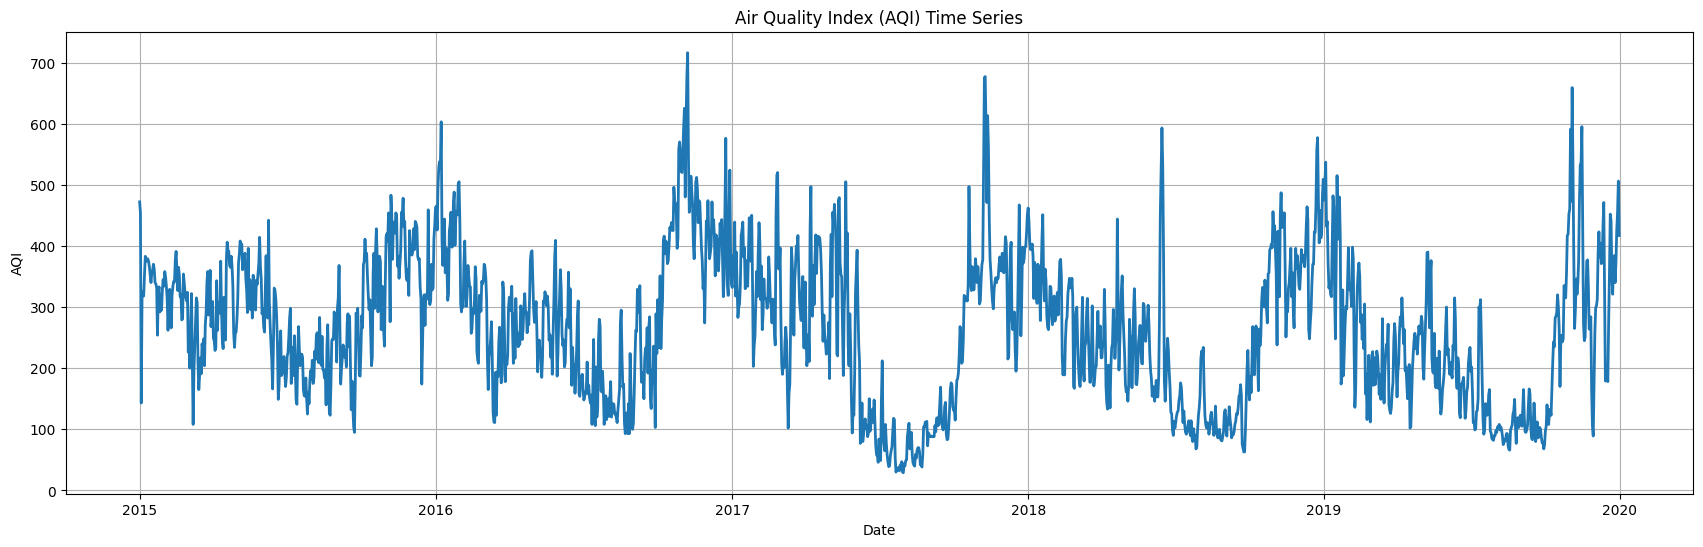

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file and parse the 'Date' column as datetime objects
df = pd.read_csv('air_quality_ts.csv', parse_dates=['Date'])

# Set the 'Date' column as the DataFrame index for time series plotting
df.set_index('Date', inplace=True)

# Create a plot of the AQI time series with a wider figure and no markers
plt.figure(figsize=(21, 6))
plt.plot(df['AQI'], linestyle='-', linewidth=2)  # Removed markers, increased line width for clarity
plt.title("Air Quality Index (AQI) Time Series")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.grid(True)
plt.show()


## 1.2 Seasonal Decomposition

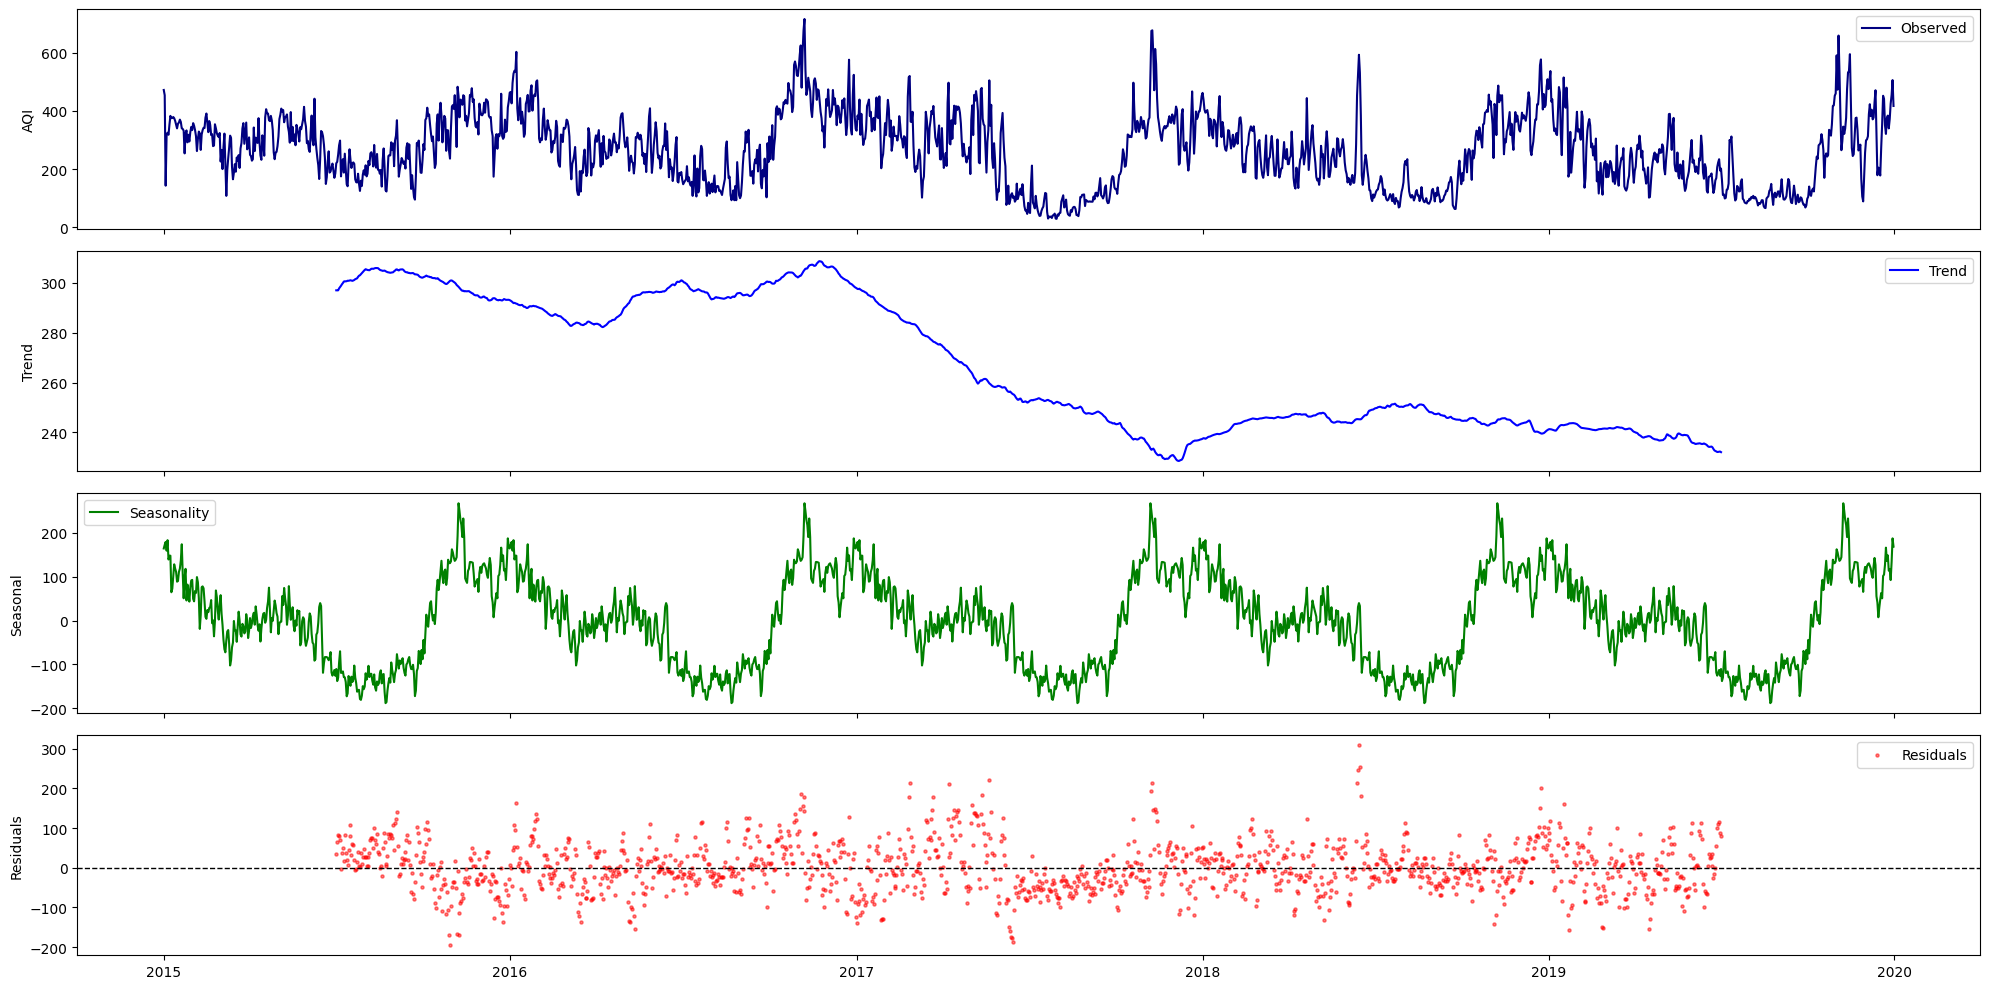

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Read the CSV file
df = pd.read_csv('/content/air_quality_ts.csv')

# Convert the 'Date' column to datetime and set it as the DataFrame index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Perform seasonal decomposition with a monthly period
decomposition = seasonal_decompose(df['AQI'], model='additive', period=365)

# Custom plot with wider figure and different colors
fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True)

# Plot observed in navy blue
axes[0].plot(df.index, decomposition.observed, color='navy', label='Observed')
axes[0].set_ylabel('AQI')
axes[0].legend()

# Plot trend
axes[1].plot(df.index, decomposition.trend, color='blue', label='Trend')
axes[1].set_ylabel('Trend')
axes[1].legend()

# Plot seasonal component
axes[2].plot(df.index, decomposition.seasonal, color='green', label='Seasonality')
axes[2].set_ylabel('Seasonal')
axes[2].legend()

# Plot residuals with smaller points
axes[3].scatter(df.index, decomposition.resid, color='red', s=5, alpha=0.5, label='Residuals')
axes[3].axhline(0, linestyle='--', color='black', linewidth=1)
axes[3].set_ylabel('Residuals')
axes[3].legend()

# Apply tight layout
plt.tight_layout()
plt.show()


## 1.3 Correlations

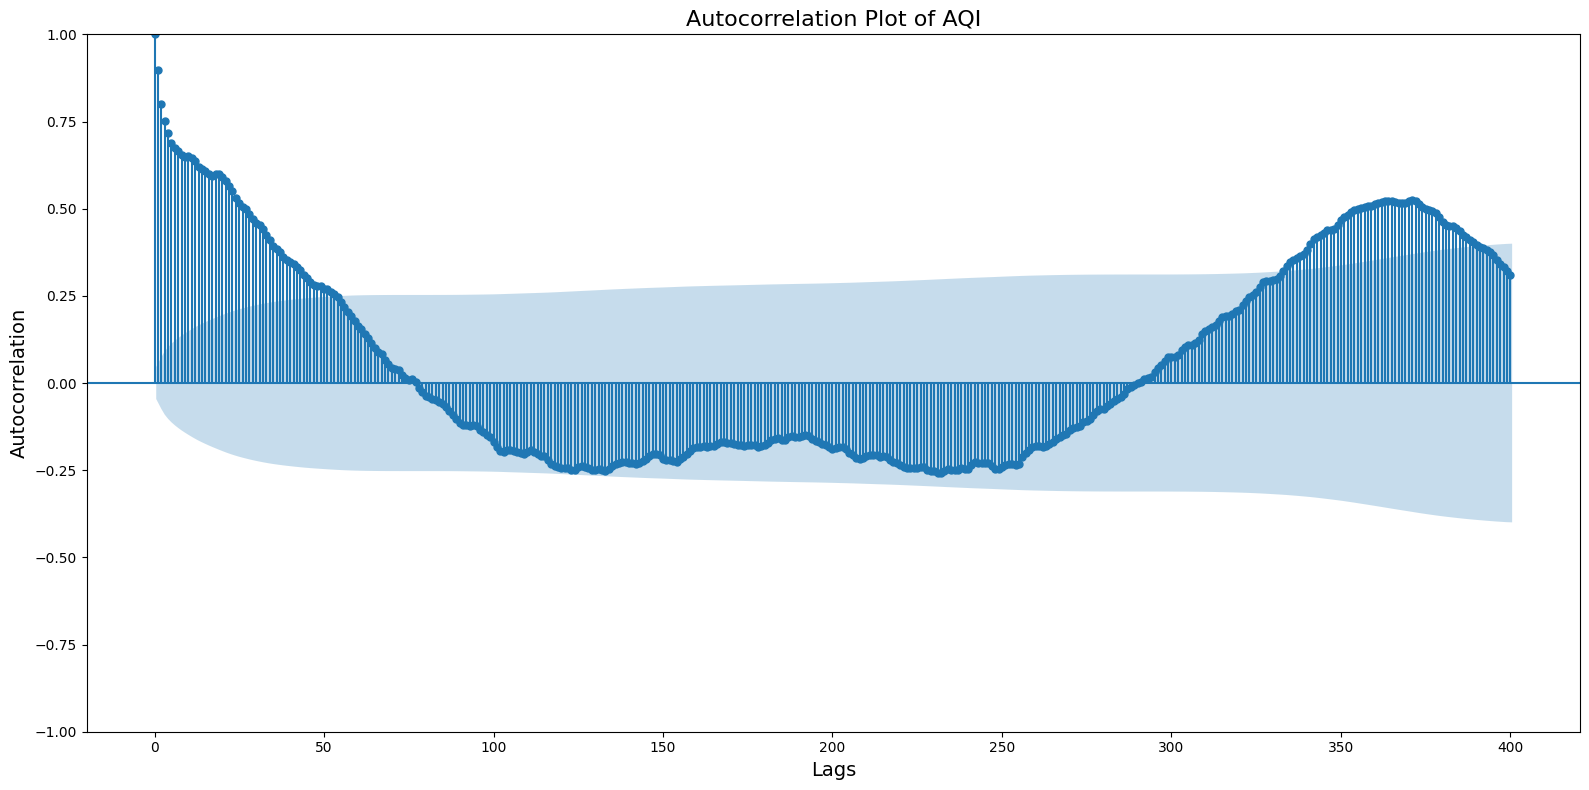

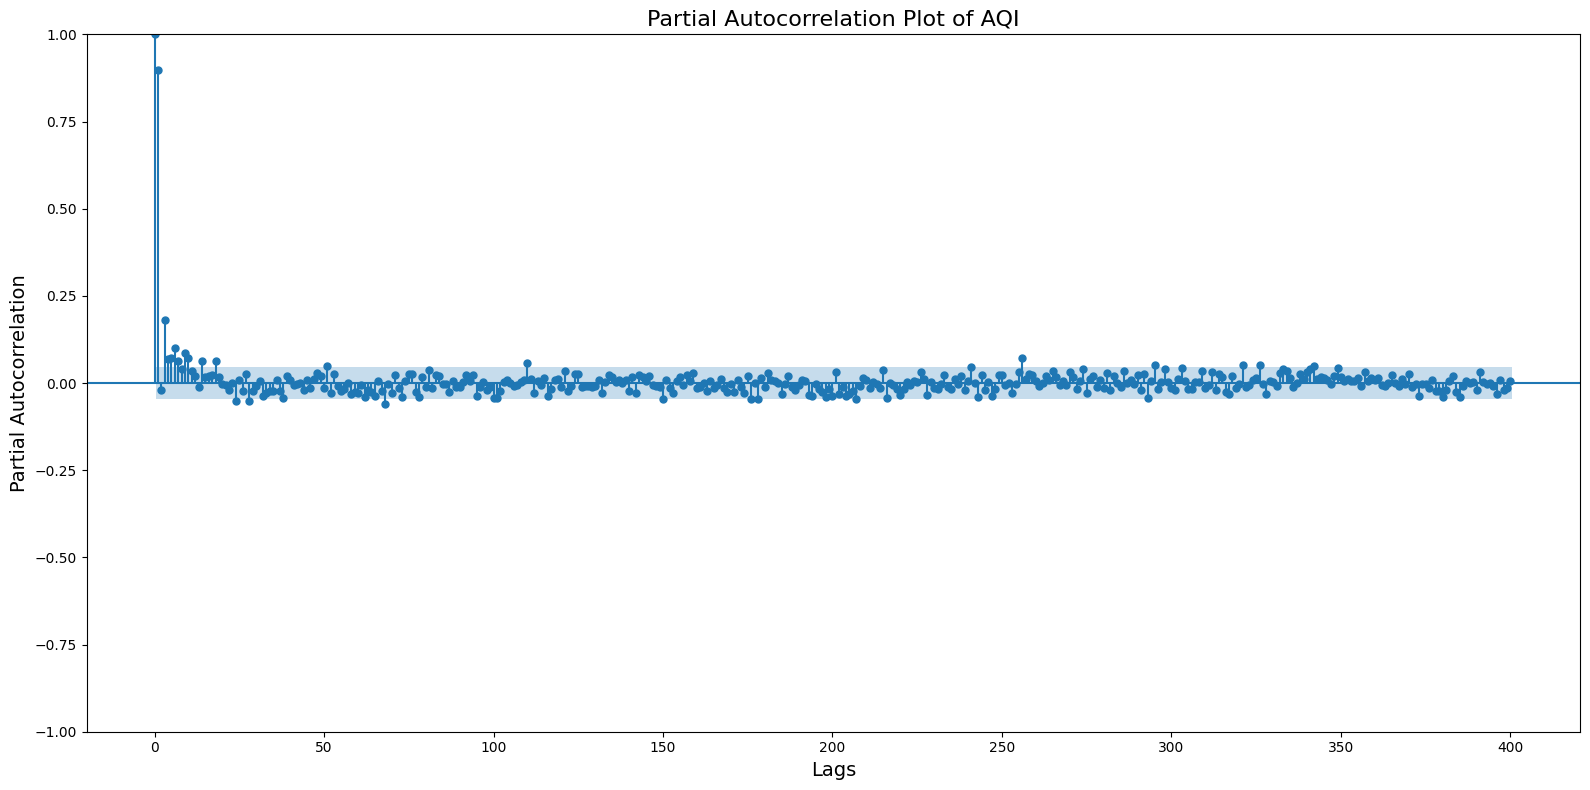

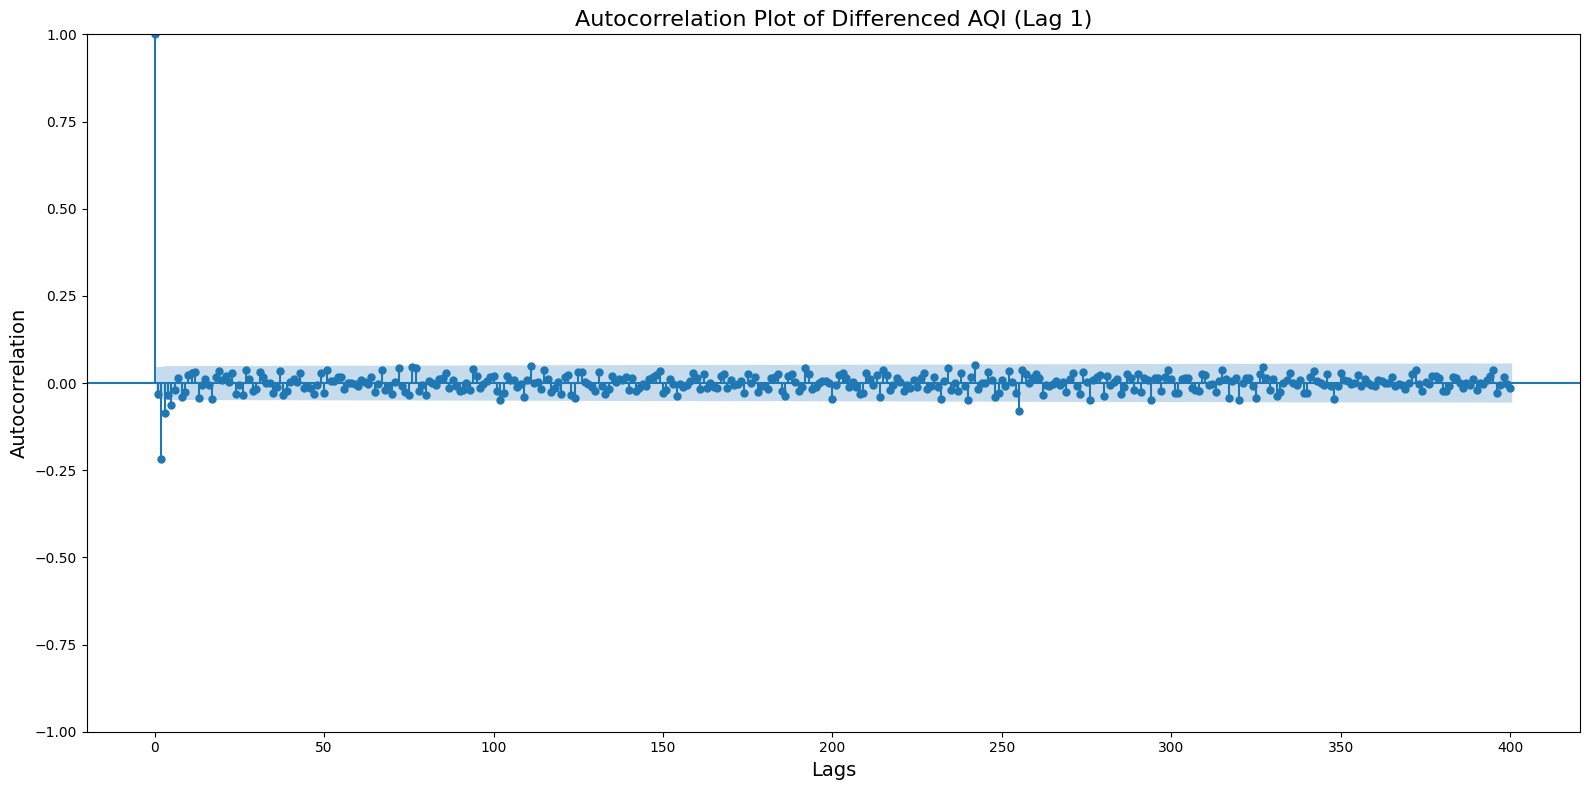

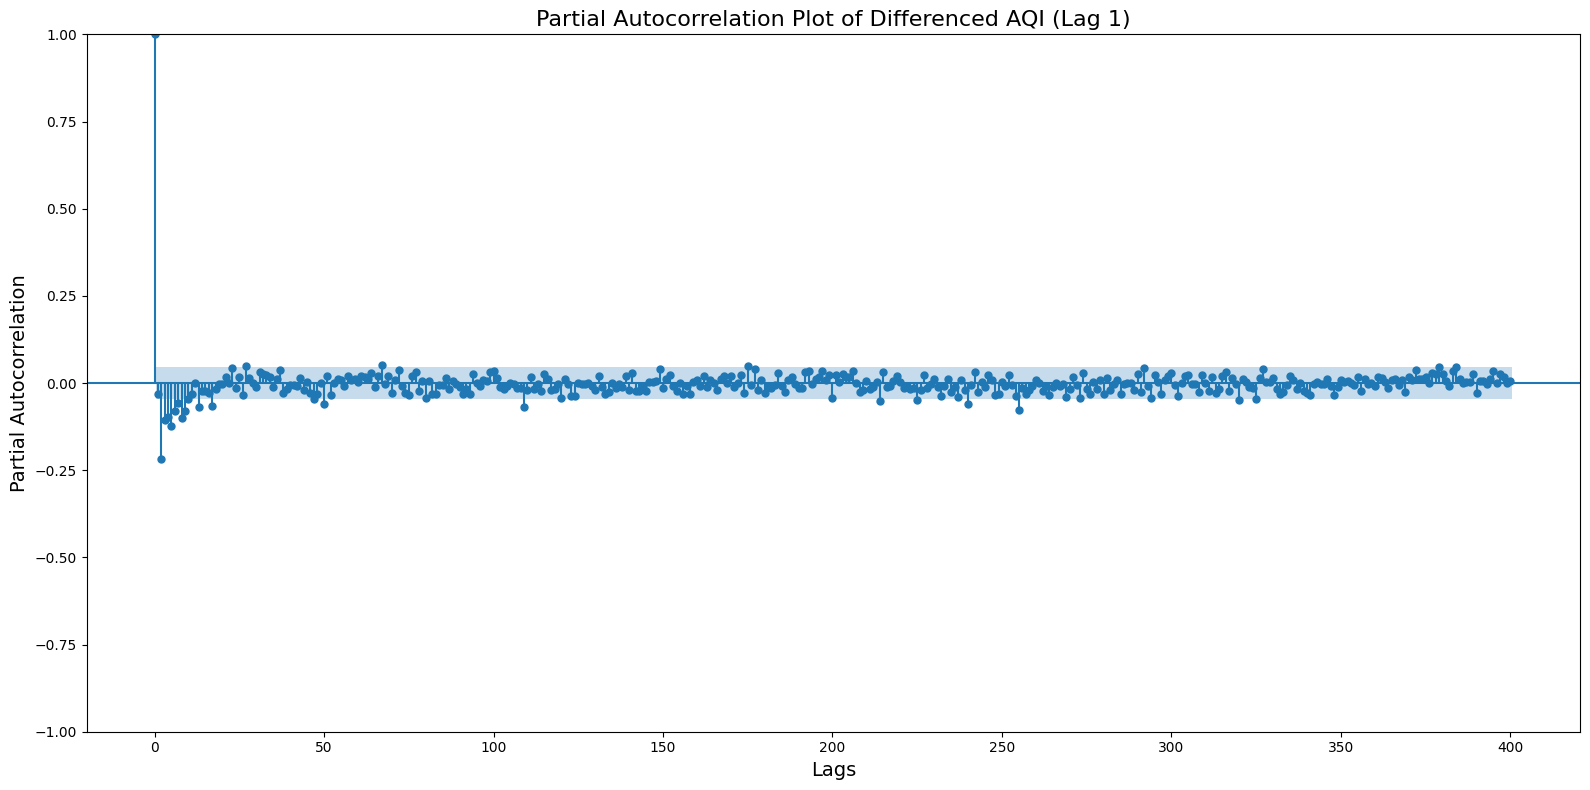

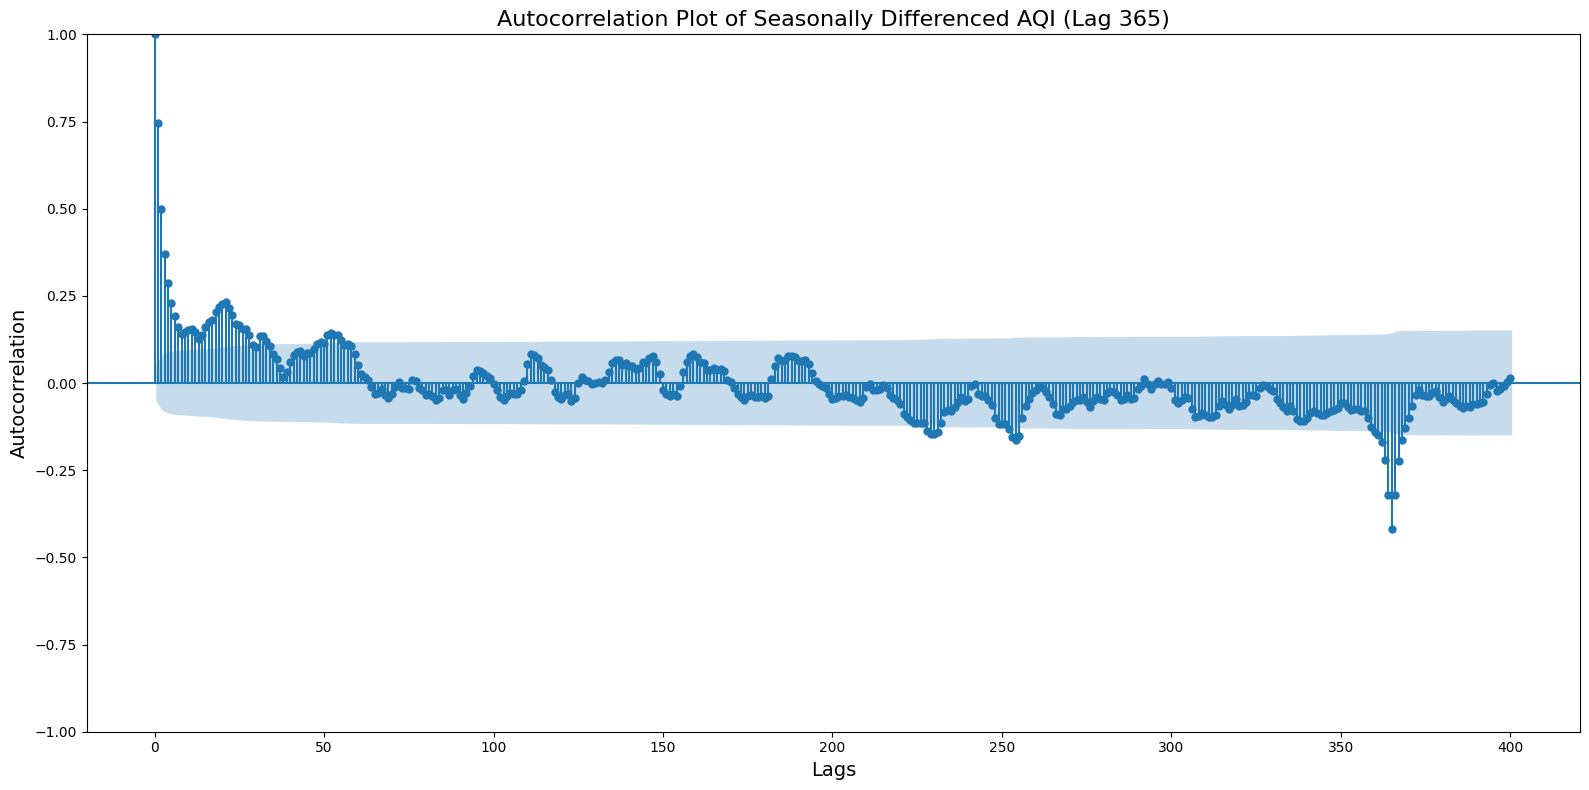

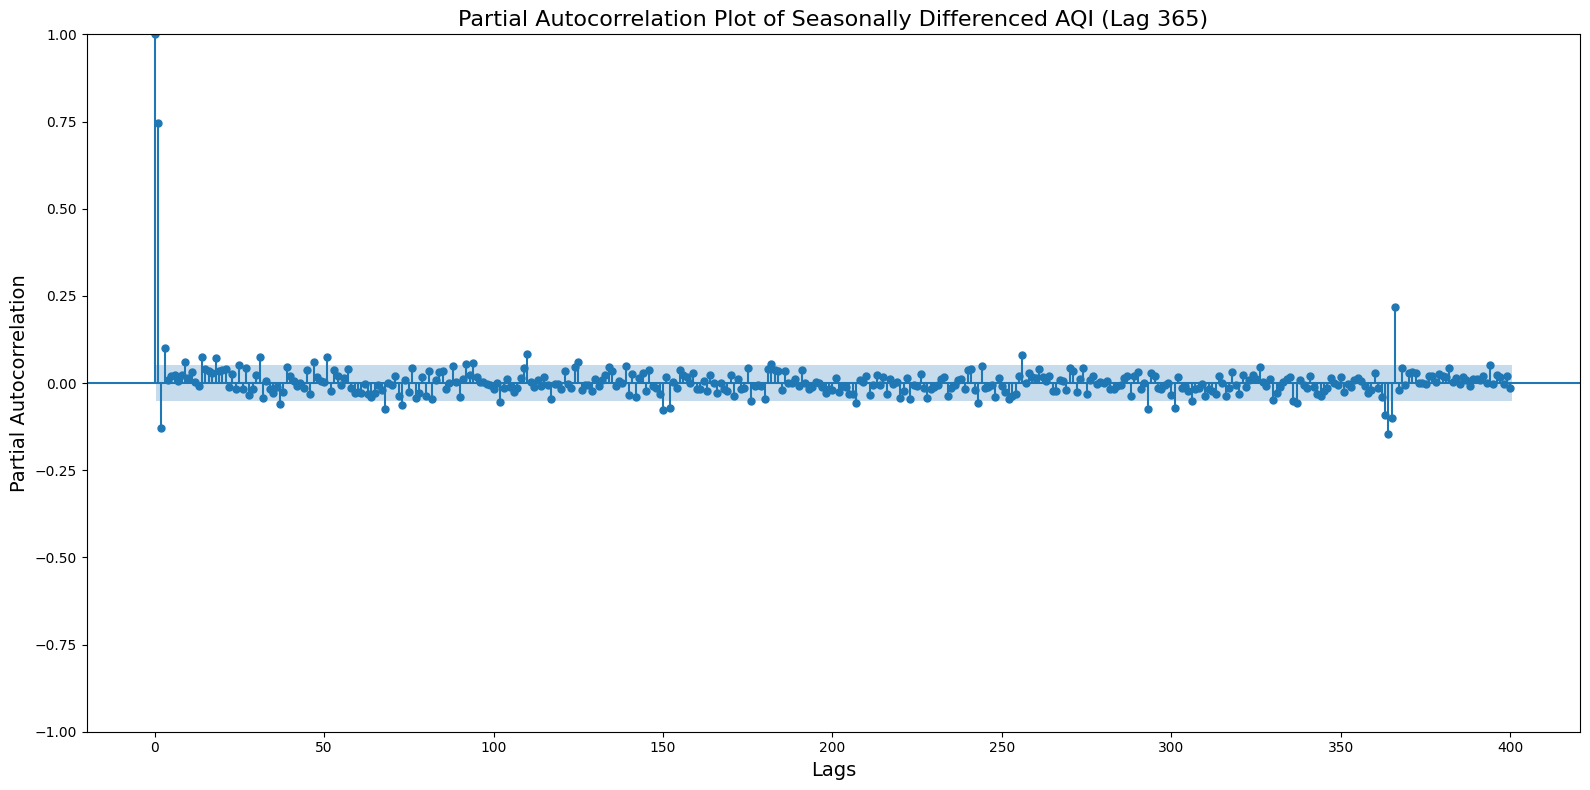

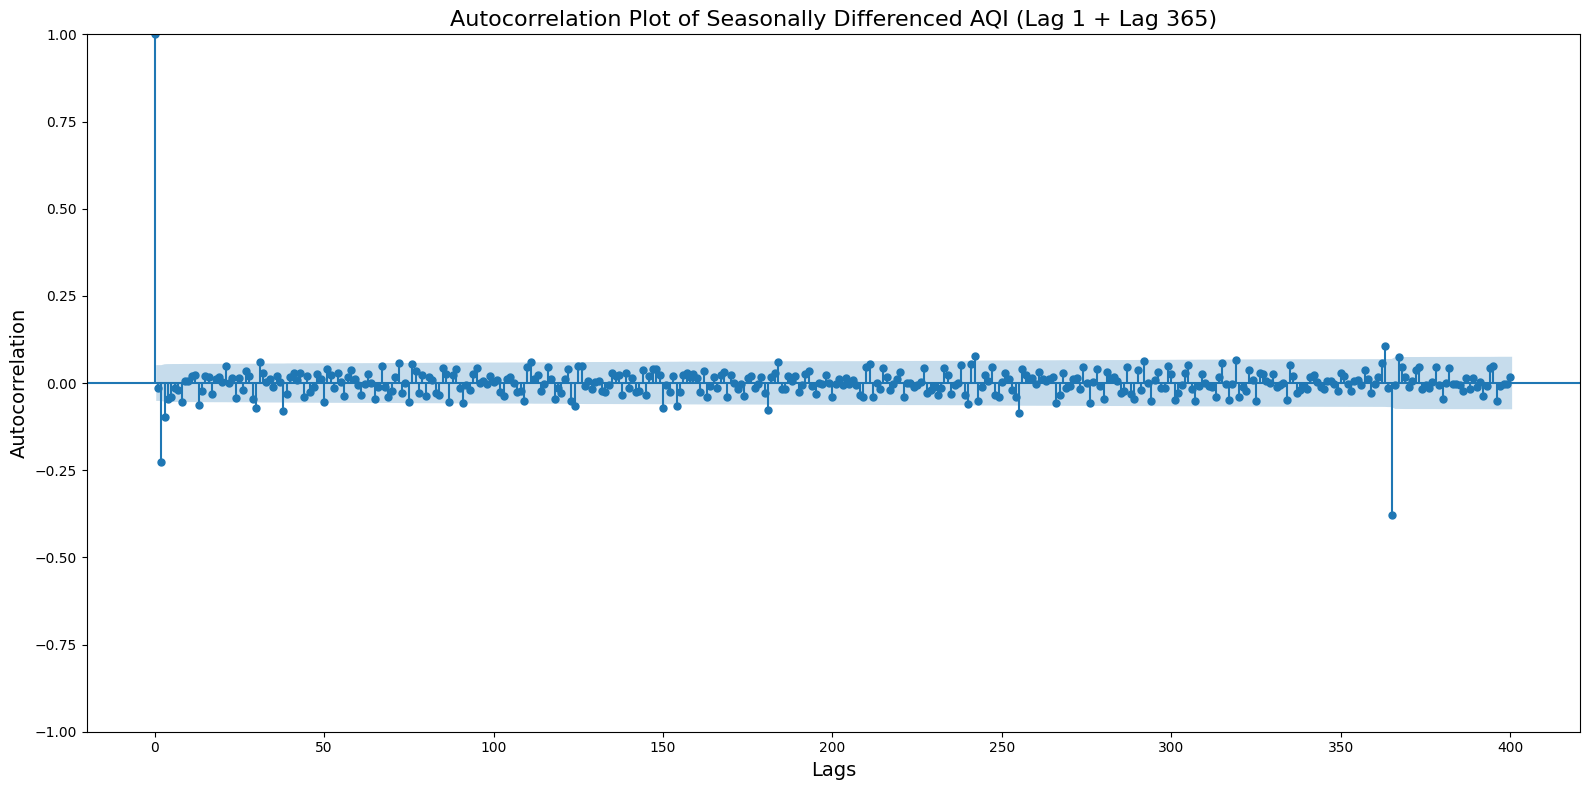

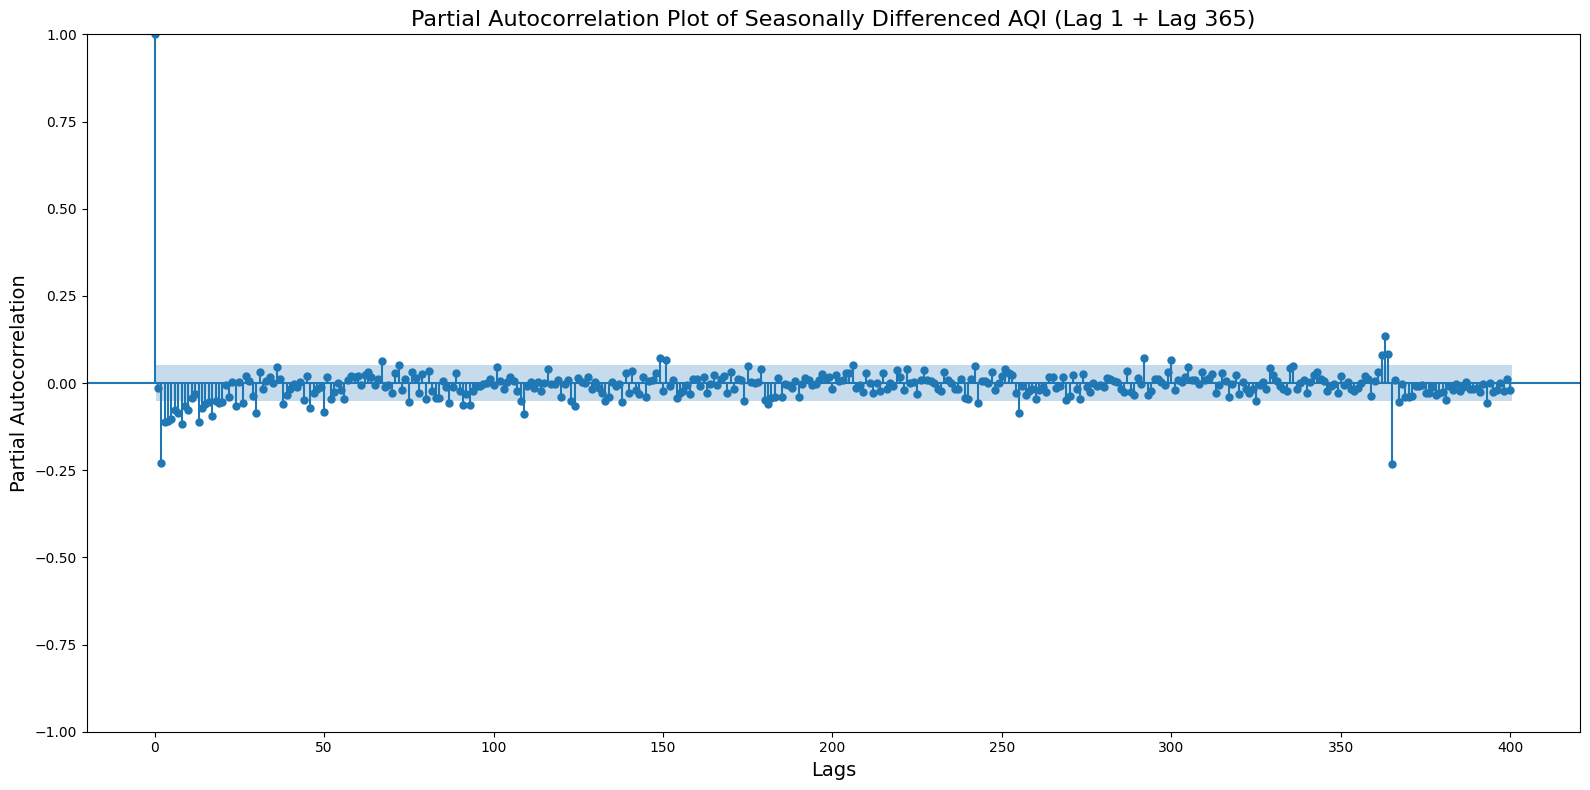

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Read the CSV file and convert 'Date' to datetime, then set as index
df = pd.read_csv('/content/air_quality_ts.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot the Autocorrelation Function (ACF) with a larger figure size
plt.figure(figsize=(16, 8))
plot_acf(df['AQI'], lags=400, ax=plt.gca())
plt.title("Autocorrelation Plot of AQI", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()

# Plot the Partial Autocorrelation Function (PACF) with a larger figure size
plt.figure(figsize=(16, 8))
plot_pacf(df['AQI'], lags=400, ax=plt.gca())
plt.title("Partial Autocorrelation Plot of AQI", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Partial Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()

df_diff1 = df['AQI'].diff().dropna()

df_diff_365= df['AQI'].diff(365).dropna()

df_diff1_365 = df_diff1.diff(365).dropna()

# Plot ACF and PACF for first-order differenced series
plt.figure(figsize=(16, 8))
plot_acf(df_diff1, lags=400, ax=plt.gca())
plt.title("Autocorrelation Plot of Differenced AQI (Lag 1)", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
plot_pacf(df_diff1, lags=400, ax=plt.gca())
plt.title("Partial Autocorrelation Plot of Differenced AQI (Lag 1)", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Partial Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()

# Plot ACF and PACF for seasonal differenced series
plt.figure(figsize=(16, 8))
plot_acf(df_diff_365, lags=400, ax=plt.gca())
plt.title("Autocorrelation Plot of Seasonally Differenced AQI (Lag 365)", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
plot_pacf(df_diff_365, lags=400, ax=plt.gca())
plt.title("Partial Autocorrelation Plot of Seasonally Differenced AQI (Lag 365)", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Partial Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()

# Plot ACF and PACF for seasonal differenced series
plt.figure(figsize=(16, 8))
plot_acf(df_diff1_365, lags=400, ax=plt.gca())
plt.title("Autocorrelation Plot of Seasonally Differenced AQI (Lag 1 + Lag 365)", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
plot_pacf(df_diff1_365, lags=400, ax=plt.gca())
plt.title("Partial Autocorrelation Plot of Seasonally Differenced AQI (Lag 1 + Lag 365)", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Partial Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()


## 1.4 Patterns

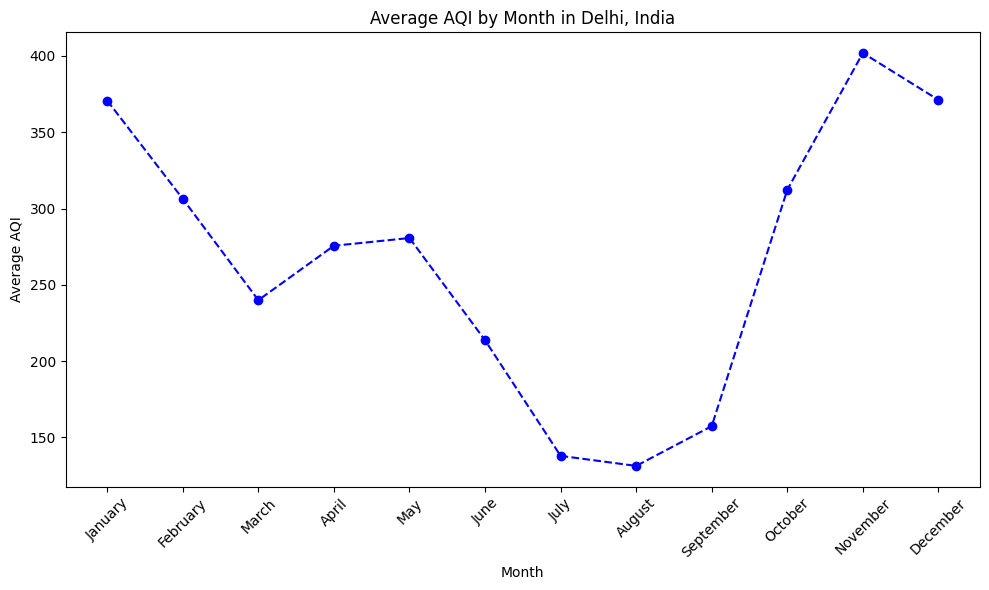

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Lecture du fichier CSV
df = pd.read_csv('/content/air_quality_ts.csv')

# Conversion de la colonne 'Date' en format datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extraction du mois (sous forme d'entier, de 1 à 12)
df['Month'] = df['Date'].dt.month

# Calcul de la moyenne de l'AQI par mois
monthly_avg = df.groupby('Month')['AQI'].mean()

# Dictionnaire de correspondance entre le numéro du mois et son nom
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
               5: 'May', 6: 'June', 7: 'July', 8: 'August',
               9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Renommage de l'index avec les noms des mois
monthly_avg.index = monthly_avg.index.map(month_names)

# Tracé du graphique en ligne avec des points reliés par une ligne en pointillé
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='--', color='blue')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.title('Average AQI by Month in Delhi, India')
plt.xticks(rotation=45)  # Rotation des labels pour une meilleure lisibilité
plt.tight_layout()
plt.show()


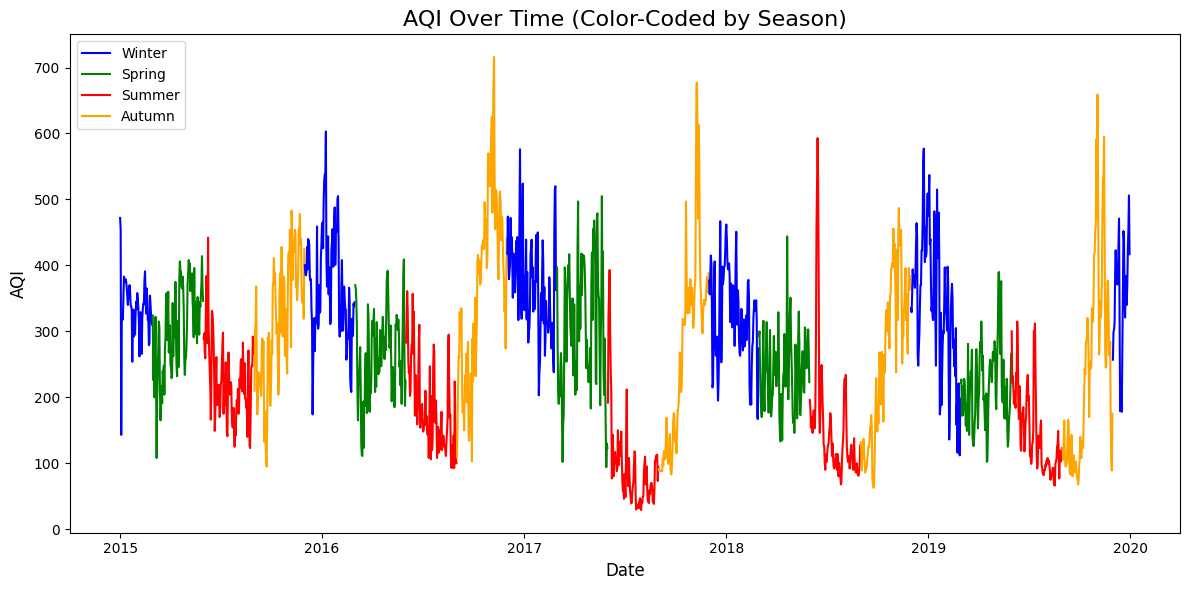

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read and Prepare Data
df = pd.read_csv('/content/air_quality_ts.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)  # Ensure chronological order

# 2) Define a Helper Function for Meteorological Seasons
#    (Northern Hemisphere logic)
def get_season(date):
    m = date.month
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Date'].apply(get_season)

# 3) Plot the Full Time Series, Color-Coded by Season
plt.figure(figsize=(12, 6))

# Colors (or line styles) for each season. Adjust as needed.
season_colors = {
    'Winter': 'blue',
    'Spring': 'green',
    'Summer': 'red',
    'Autumn': 'orange'
}

# We'll iterate through each season in chronological order
# to create contiguous line segments for that season.
# Conceptual Steps:
#   - We find consecutive rows for each season,
#   - Plot them as a line in that color,
#   - Move on to the next group.
prev_season = None
start_idx = 0

for i in range(len(df)):
    current_season = df['Season'].iloc[i]
    # Check if season changes OR we're at the last row
    if (i == len(df) - 1) or (current_season != df['Season'].iloc[i + 1]):
        # Plot the segment for the current season from 'start_idx' to 'i'
        subset = df.iloc[start_idx:i + 1]
        color = season_colors.get(current_season, 'black')
        plt.plot(subset['Date'], subset['AQI'], color=color)
        # Next segment starts at i+1
        start_idx = i + 1

plt.title('AQI Over Time (Color-Coded by Season)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)

# Add a legend with the color-season mapping.
for season, color in season_colors.items():
    plt.plot([], [], color=color, label=season)
plt.legend()

plt.tight_layout()
plt.show()


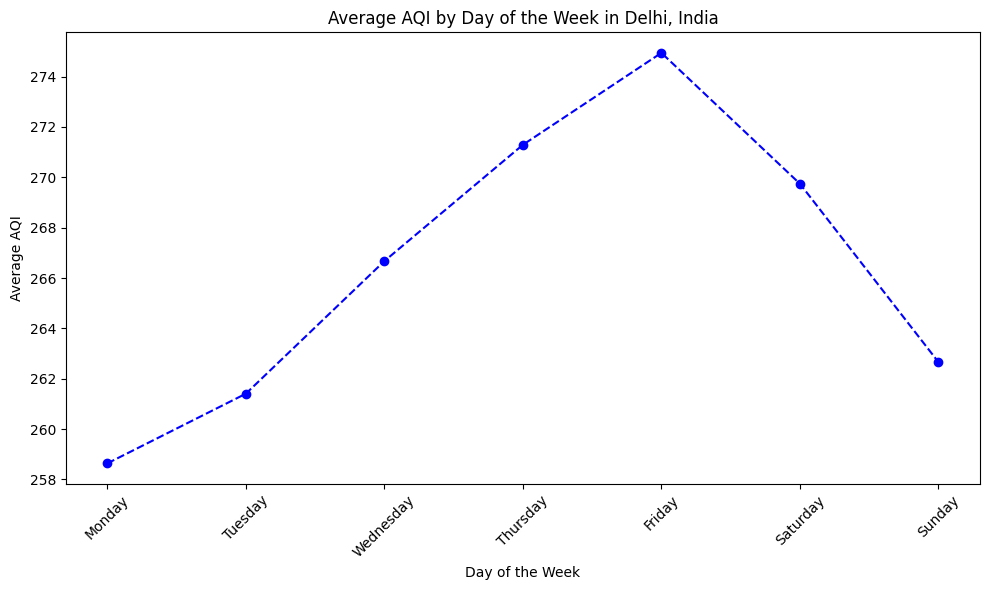

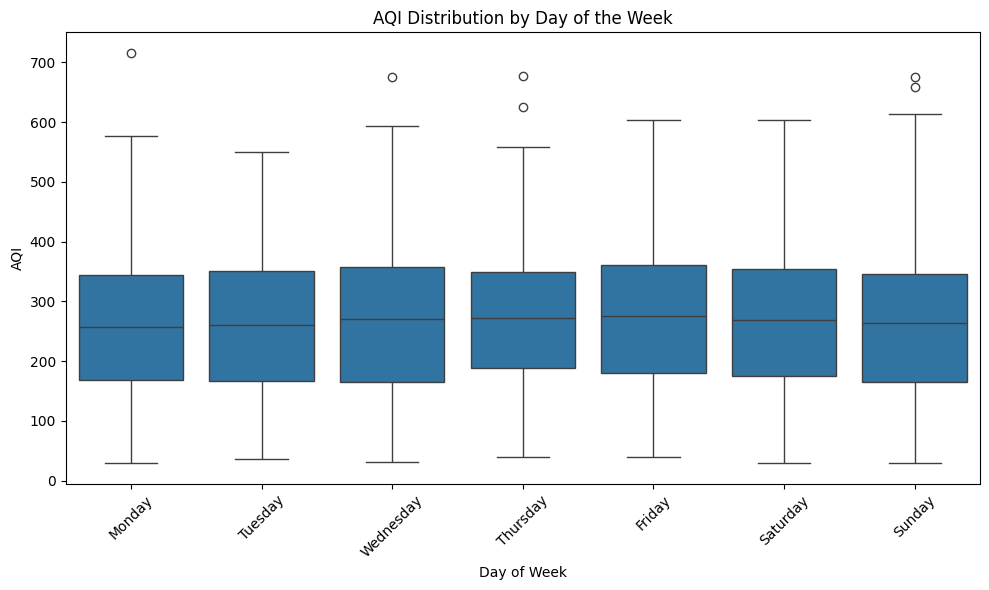

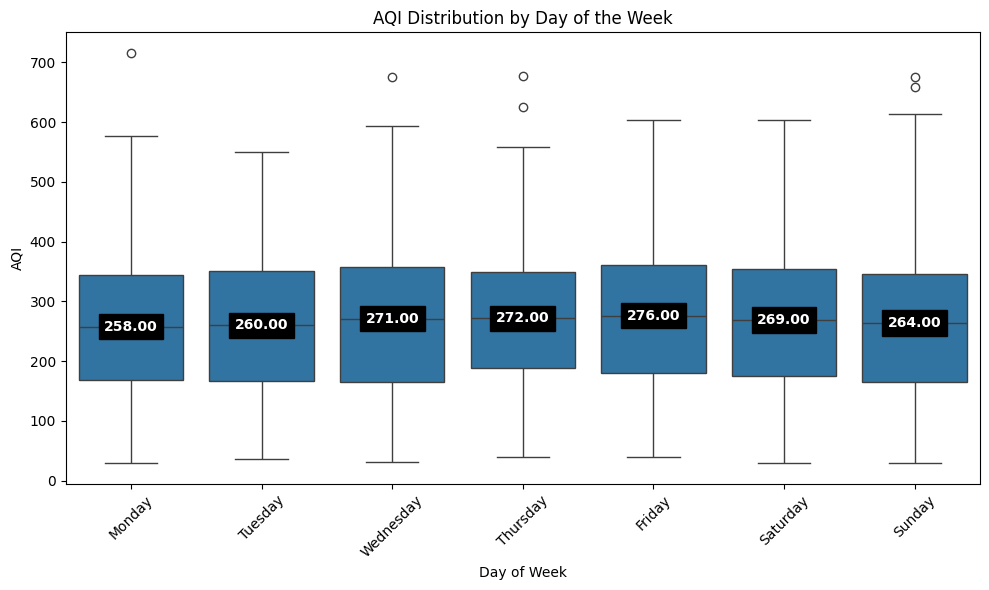

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Lecture du fichier CSV
df = pd.read_csv('/content/air_quality_ts.csv')

# Conversion de la colonne 'Date' en format datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extraction du nom du jour de la semaine
df['Day'] = df['Date'].dt.day_name()

# Calcul de la moyenne de l'AQI par jour de la semaine
daily_avg = df.groupby('Day')['AQI'].mean()

# Réindexation pour assurer l'ordre correct des jours de la semaine
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = daily_avg.reindex(order)

# Tracé du graphique en ligne avec des points reliés par une ligne en pointillé
plt.figure(figsize=(10, 6))
plt.plot(daily_avg.index, daily_avg.values, marker='o', linestyle='--', color='blue')
plt.xlabel('Day of the Week')
plt.ylabel('Average AQI')
plt.title('Average AQI by Day of the Week in Delhi, India')
plt.xticks(rotation=45)  # Rotation des labels pour une meilleure lisibilité
plt.tight_layout()
plt.show()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Date' to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Create a column for day of week name
df['DayOfWeek'] = df['Date'].dt.day_name()

# If you want a specific order: Monday -> Sunday
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='AQI', data=df, order=order_days)
plt.title('AQI Distribution by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Date' to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Create a column for day of week name
df['DayOfWeek'] = df['Date'].dt.day_name()

# Specify the order of days if desired
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday",
              "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10,6))

# Create the boxplot
ax = sns.boxplot(x='DayOfWeek', y='AQI', data=df, order=order_days)

# Calculate median AQI for each day
median_values = df.groupby('DayOfWeek')['AQI'].median()

# Annotate the median on the plot
for i, day in enumerate(order_days):
    median_val = median_values[day]
    # 'i' is the x-position for the category; 'median_val' is the y-position
    plt.text(
        i,                       # x-coordinate
        median_val,             # y-coordinate
        f'{median_val:.2f}',    # text to display (rounded to 2 decimals)
        ha='center',            # horizontal alignment
        va='center',            # vertical alignment
        color='white',          # text color
        fontweight='bold',
        bbox=dict(facecolor='black')  # background box for visibility
    )

plt.title('AQI Distribution by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## 1.5 More Visualizations

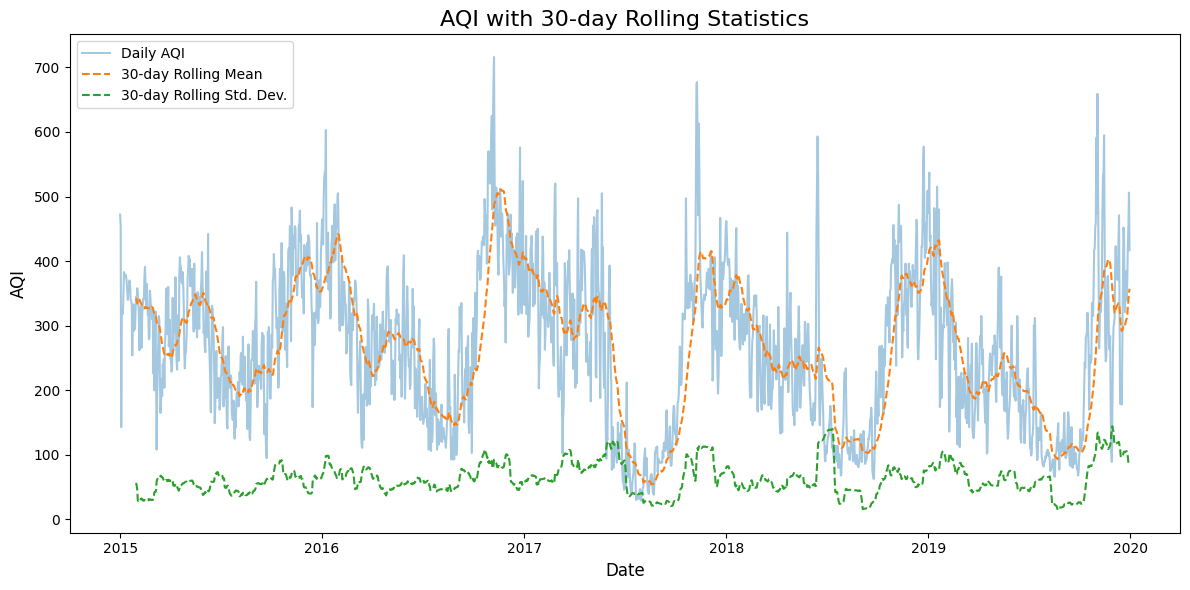

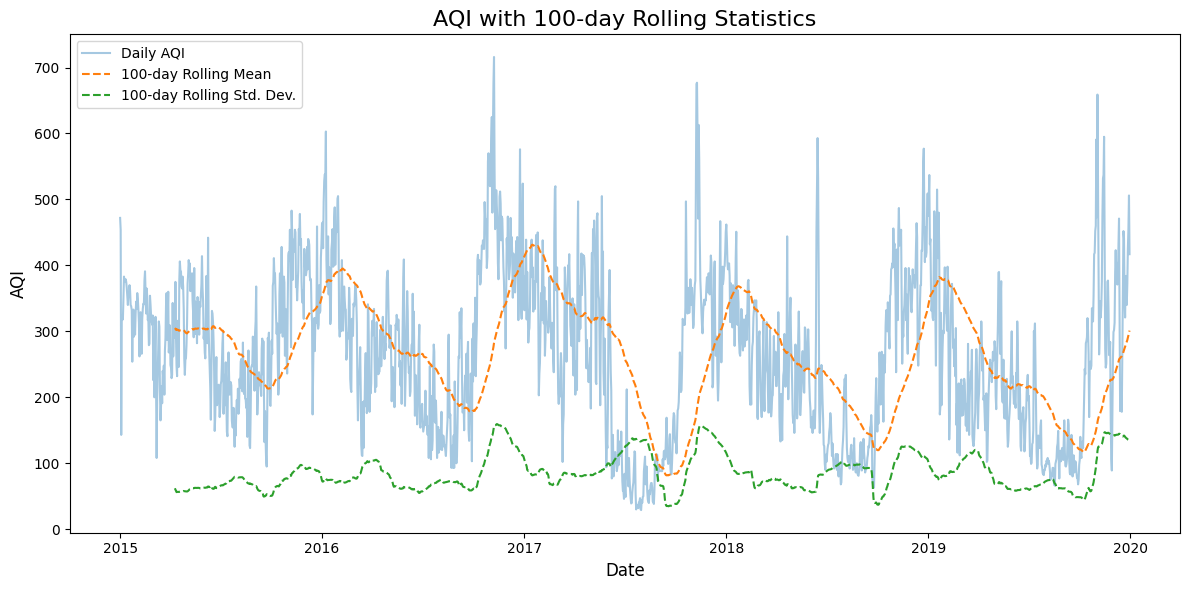

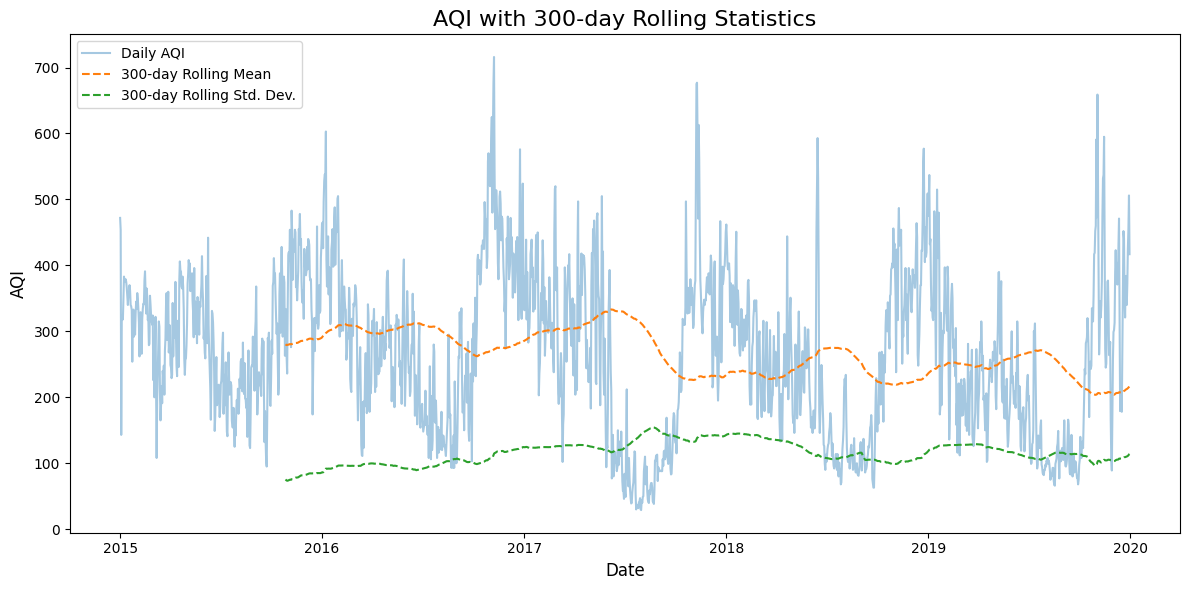

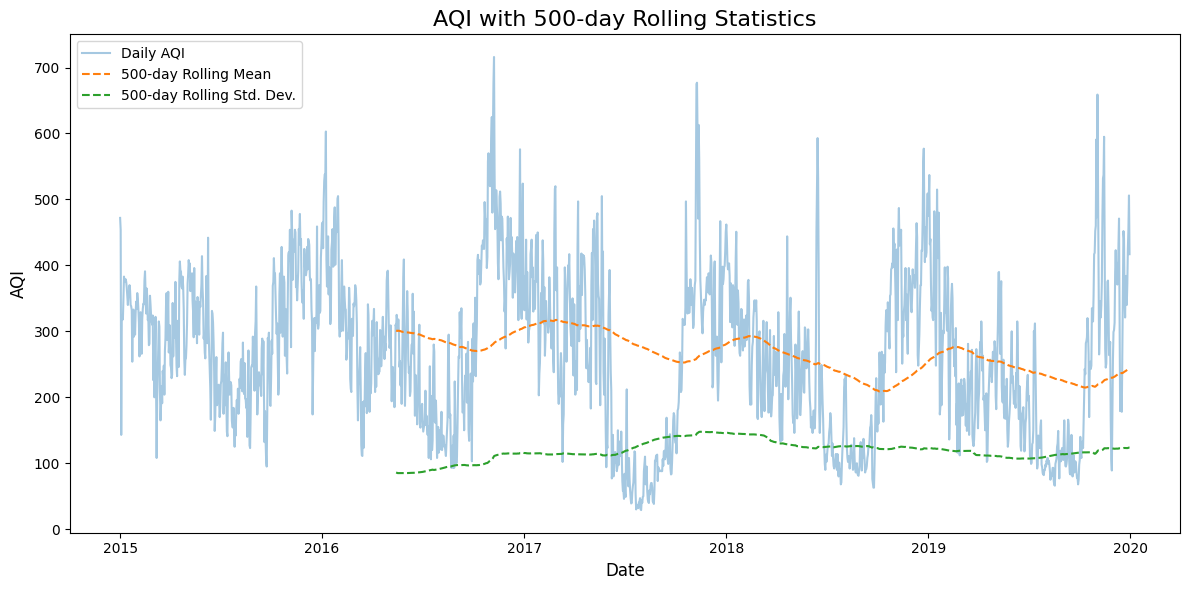

<Figure size 1200x600 with 0 Axes>

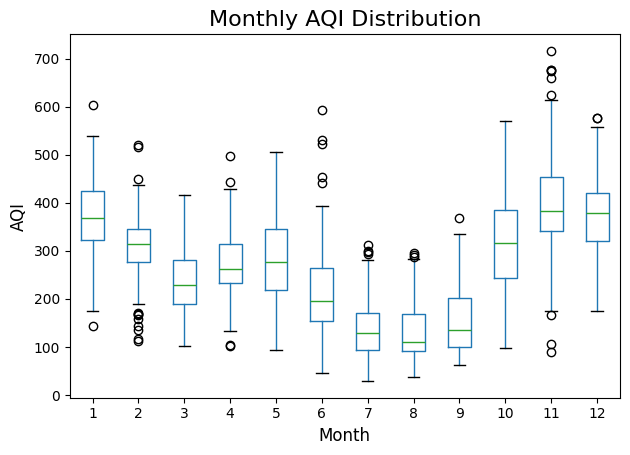

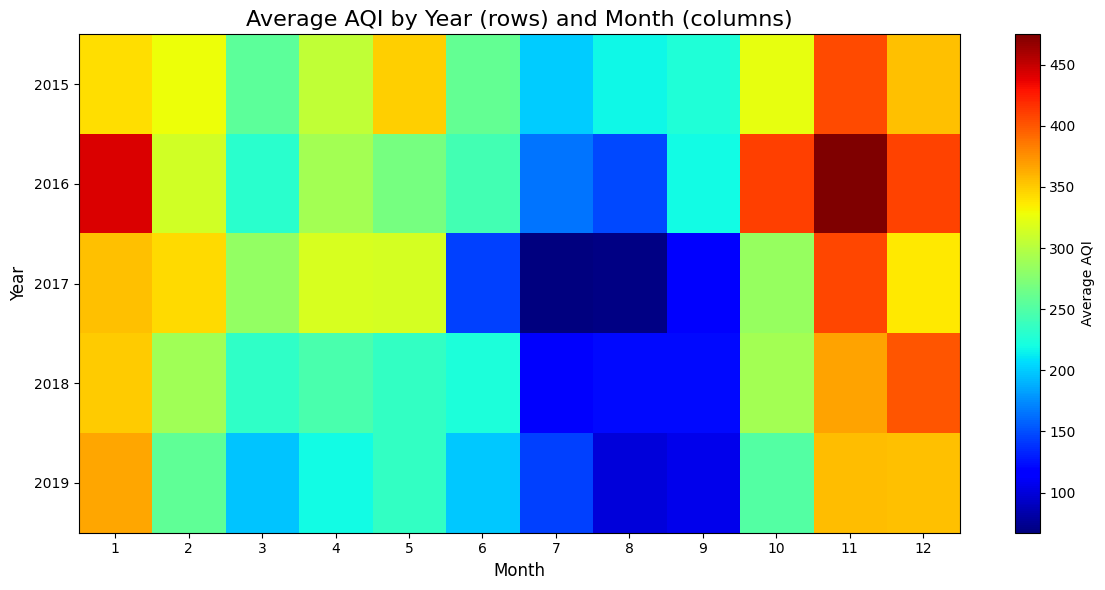

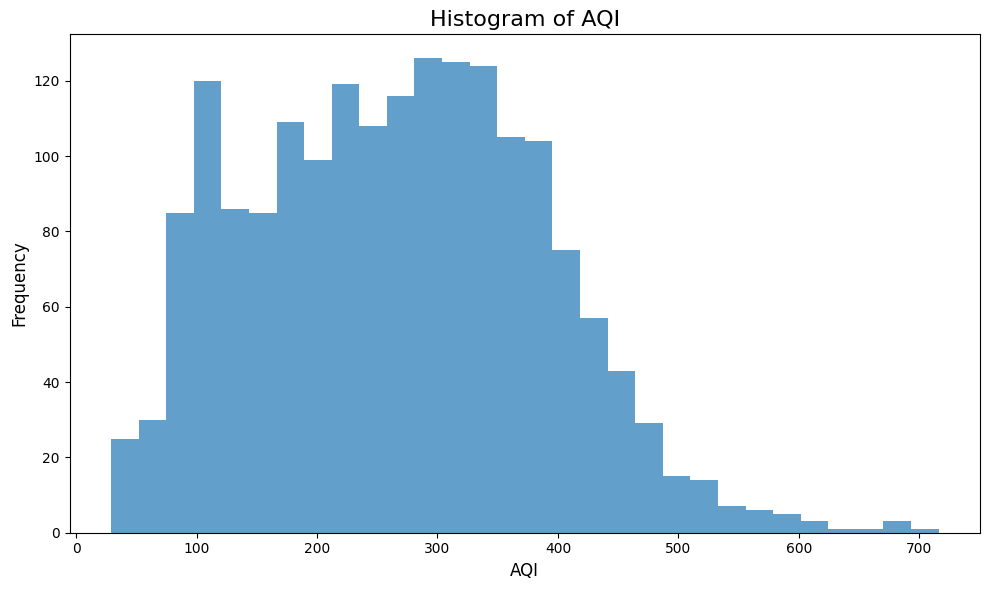

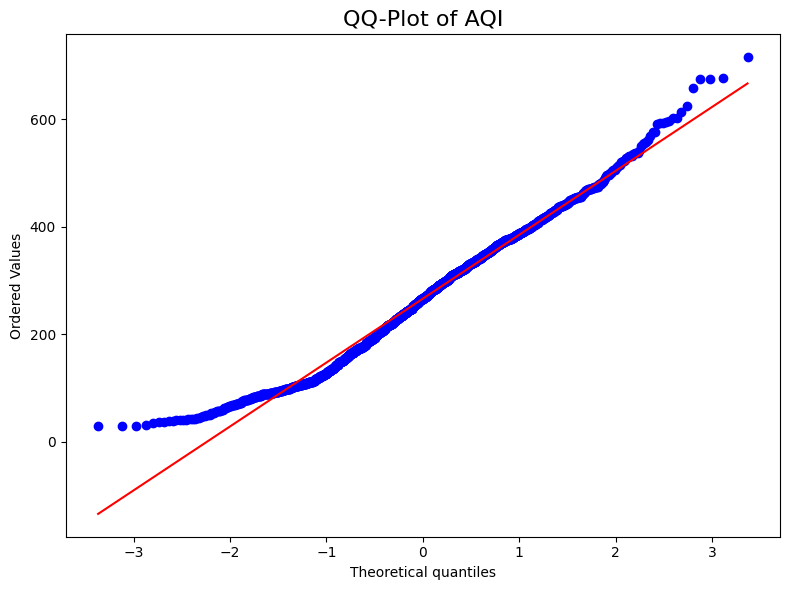

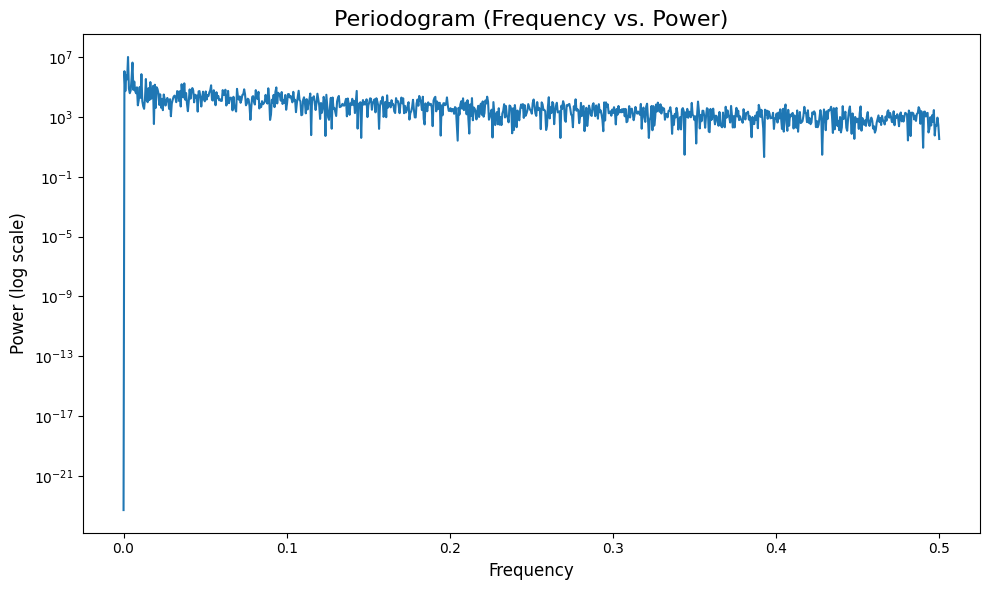

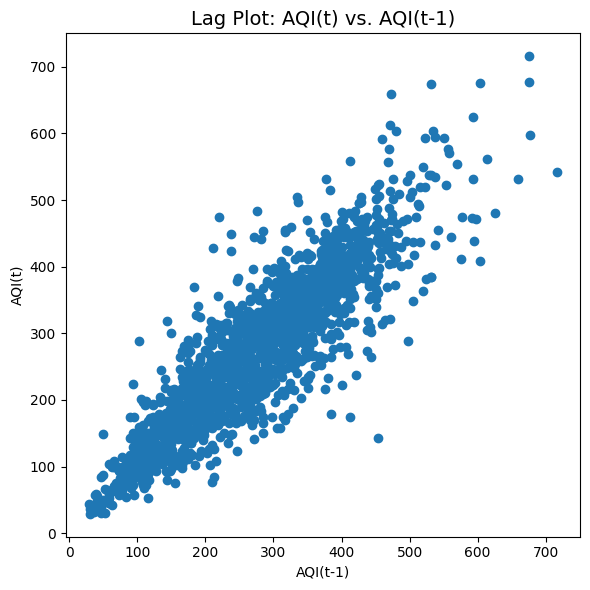

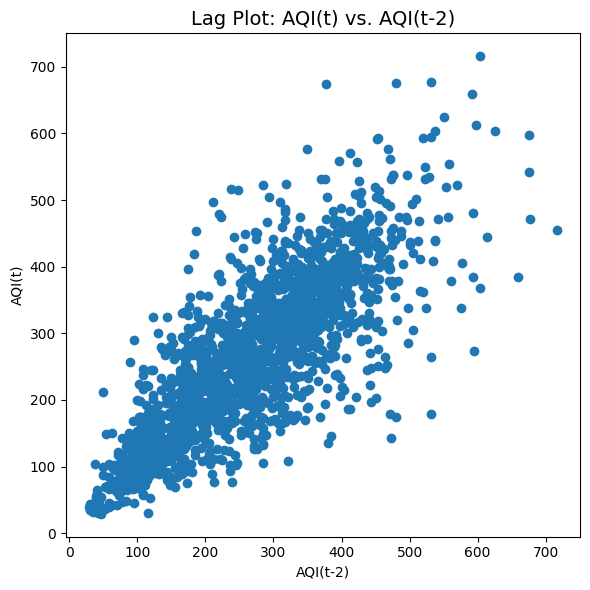

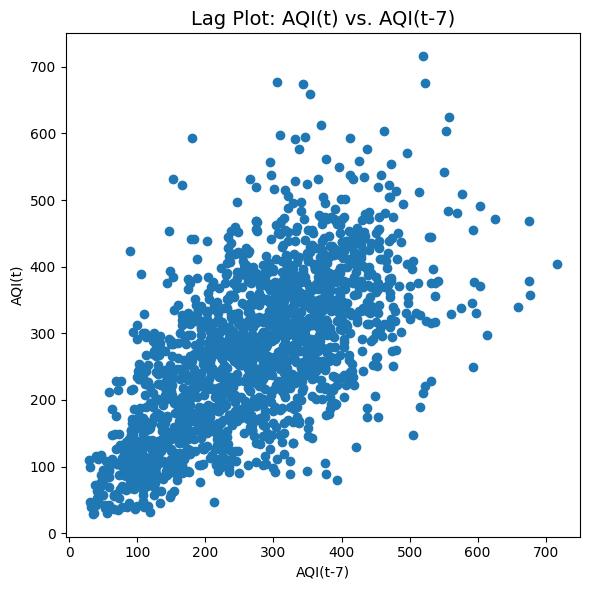

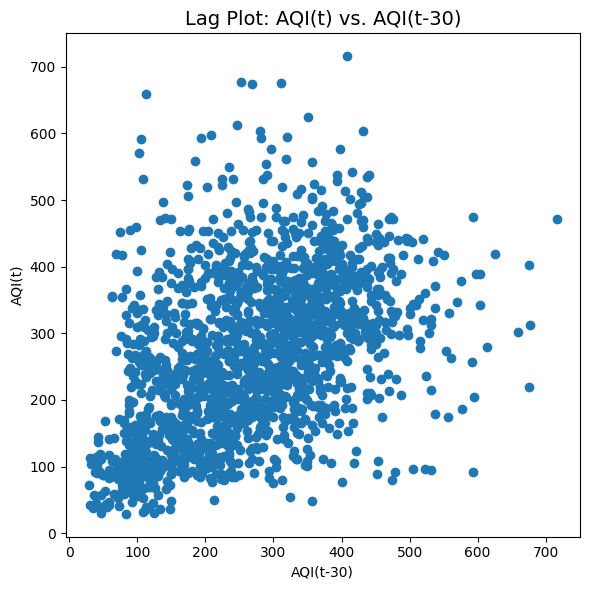

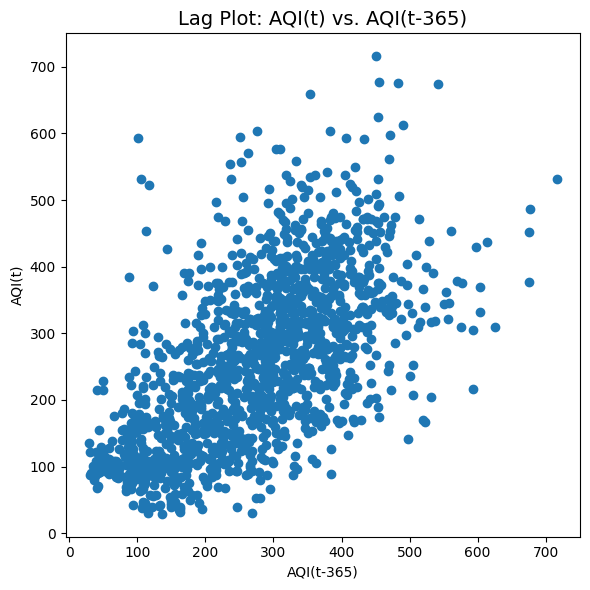

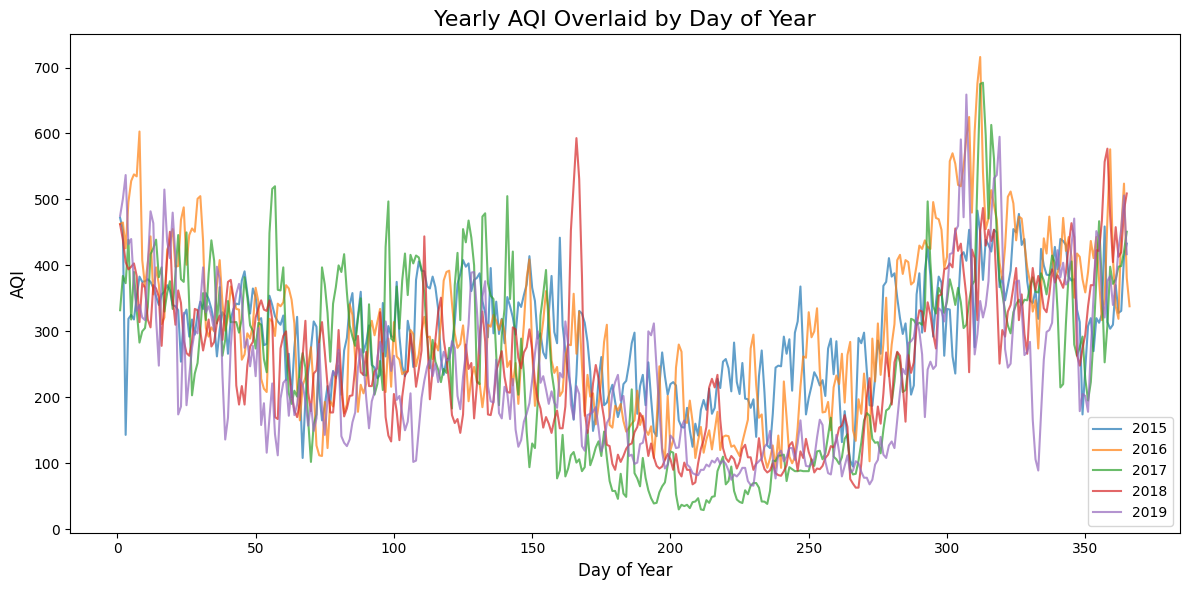

In [ ]:
###############################################################################
# ALL-IN-ONE CODE CELL FOR VARIOUS TIME SERIES PLOTS AND ANALYSES
# (Using only matplotlib for visualizations)
###############################################################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

# 1) READ AND PREPARE THE DATA
###############################################################################
# Adjust the file path as needed
df = pd.read_csv('/content/air_quality_ts.csv')

# Convert 'Date' to datetime and set it as the DataFrame index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure AQI column is numeric
df['AQI'] = pd.to_numeric(df['AQI'], errors='coerce')

# Drop any rows with NaN values (if necessary)
df.dropna(subset=['AQI'], inplace=True)

# Define the date range
start_date = "2015-01-01"
end_date = "2019-12-31"

# Filter the DataFrame within the date range
df = df.loc[start_date:end_date]



###############################################################################
# 3) ROLLING STATISTICS (MOVING AVERAGE & ROLLING STD)
#    Calculate and plot a 30-day rolling mean and std around the daily AQI
###############################################################################
df['RollingMean'] = df['AQI'].rolling(window=30).mean()
df['RollingStd']  = df['AQI'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(df['AQI'], label='Daily AQI', alpha=0.4)
plt.plot(df['RollingMean'], label='30-day Rolling Mean', linestyle='--')
plt.plot(df['RollingStd'], label='30-day Rolling Std. Dev.', linestyle='--')
plt.title('AQI with 30-day Rolling Statistics', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

###############################################################################
# 3.2) ROLLING STATISTICS (MOVING AVERAGE & ROLLING STD)
#    Calculate and plot a 100-day rolling mean and std around the daily AQI
###############################################################################
df['RollingMean'] = df['AQI'].rolling(window=100).mean()
df['RollingStd']  = df['AQI'].rolling(window=100).std()

plt.figure(figsize=(12, 6))
plt.plot(df['AQI'], label='Daily AQI', alpha=0.4)
plt.plot(df['RollingMean'], label='100-day Rolling Mean', linestyle='--')
plt.plot(df['RollingStd'], label='100-day Rolling Std. Dev.', linestyle='--')
plt.title('AQI with 100-day Rolling Statistics', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

###############################################################################
# 3.3) ROLLING STATISTICS (MOVING AVERAGE & ROLLING STD)
#    Calculate and plot a 300-day rolling mean and std around the daily AQI
###############################################################################
df['RollingMean'] = df['AQI'].rolling(window=300).mean()
df['RollingStd']  = df['AQI'].rolling(window=300).std()

plt.figure(figsize=(12, 6))
plt.plot(df['AQI'], label='Daily AQI', alpha=0.4)
plt.plot(df['RollingMean'], label='300-day Rolling Mean', linestyle='--')
plt.plot(df['RollingStd'], label='300-day Rolling Std. Dev.', linestyle='--')
plt.title('AQI with 300-day Rolling Statistics', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

###############################################################################
# 3.2) ROLLING STATISTICS (MOVING AVERAGE & ROLLING STD)
#    Calculate and plot a 100-day rolling mean and std around the daily AQI
###############################################################################
df['RollingMean'] = df['AQI'].rolling(window=500).mean()
df['RollingStd']  = df['AQI'].rolling(window=500).std()

plt.figure(figsize=(12, 6))
plt.plot(df['AQI'], label='Daily AQI', alpha=0.4)
plt.plot(df['RollingMean'], label='500-day Rolling Mean', linestyle='--')
plt.plot(df['RollingStd'], label='500-day Rolling Std. Dev.', linestyle='--')
plt.title('AQI with 500-day Rolling Statistics', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

###############################################################################
# 4) SEASONAL BOXPLOTS (BY MONTH)
#    Boxplot grouping daily AQI by month number (1–12)
###############################################################################
df['Month'] = df.index.month  # Extract month from date

# We'll create a simple boxplot grouped by month
# Because boxplot in pandas needs a groupby or a 'by' param, we can do:
# NOTE: df.boxplot(...) internally uses matplotlib
plt.figure(figsize=(12, 6))
df.boxplot(column='AQI', by='Month', grid=False)
plt.title('Monthly AQI Distribution', fontsize=16)
plt.suptitle('')  # Remove default title that Pandas boxplot adds
plt.xlabel('Month', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.tight_layout()
plt.show()

###############################################################################
# 5) HEATMAP FOR YEAR-MONTH PATTERNS (MATPLOTLIB IMPLEMENTATION)
#    Create a pivot table of mean AQI by year (rows) and month (columns)
#    Then visualize as a color-coded matrix with plt.imshow()
###############################################################################
df['Year'] = df.index.year
pivot_data = df.pivot_table(values='AQI', index='Year', columns='Month', aggfunc='mean')

# We'll convert the pivot table to a NumPy array for imshow
# (Make sure to handle potential NaN values by replacing them with a fill value)
matrix = pivot_data.values

plt.figure(figsize=(12, 6))
im = plt.imshow(matrix, aspect='auto', cmap='jet')  # 'jet' or another color map
plt.colorbar(im, label='Average AQI')
plt.title('Average AQI by Year (rows) and Month (columns)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)

# Ticks and labels for the x-axis (months) and y-axis (years)
xticks_positions = np.arange(len(pivot_data.columns))
yticks_positions = np.arange(len(pivot_data.index))

plt.xticks(xticks_positions, pivot_data.columns)
plt.yticks(yticks_positions, pivot_data.index)

plt.tight_layout()
plt.show()

###############################################################################
# 6) DISTRIBUTION PLOT (HISTOGRAM)
###############################################################################
plt.figure(figsize=(10, 6))
plt.hist(df['AQI'], bins=30, alpha=0.7)
plt.title('Histogram of AQI', fontsize=16)
plt.xlabel('AQI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

###############################################################################
# 7) QQ-PLOT
#    Compare data distribution to a normal distribution
###############################################################################
plt.figure(figsize=(8, 6))
stats.probplot(df['AQI'], dist="norm", plot=plt)
plt.title('QQ-Plot of AQI', fontsize=16)
plt.tight_layout()
plt.show()

###############################################################################
# 8) PERIODOGRAM (SPECTRAL ANALYSIS)
###############################################################################
# Convert series to a NumPy array, dropping NaNs just to be sure
series_clean = df['AQI'].dropna().values
freqs, power = periodogram(series_clean)

plt.figure(figsize=(10, 6))
plt.semilogy(freqs, power)  # semilogy for a log-scale on the y-axis
plt.title('Periodogram (Frequency vs. Power)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Power (log scale)', fontsize=12)
plt.tight_layout()
plt.show()

###############################################################################
# 9) LAG PLOTS FOR MULTIPLE LAGS
#    Demonstrate correlation at different lags
###############################################################################
lags = [1, 2, 7, 30, 365]  # For example: 1-day, 2-day, 7-day, and 30-day lag
for lag in lags:
    plt.figure(figsize=(6, 6))
    lag_plot(df['AQI'], lag=lag)
    plt.title(f'Lag Plot: AQI(t) vs. AQI(t-{lag})', fontsize=14)
    plt.xlabel(f'AQI(t-{lag})')
    plt.ylabel('AQI(t)')
    plt.tight_layout()
    plt.show()

###############################################################################
# 10) MULTI-YEAR OVERLAY
#     Plot each year separately but aligned by day of the year to compare seasonality
###############################################################################
df['DayOfYear'] = df.index.dayofyear
unique_years = sorted(df['Year'].unique())

plt.figure(figsize=(12, 6))
for year in unique_years:
    yearly_data = df[df['Year'] == year]
    plt.plot(yearly_data['DayOfYear'], yearly_data['AQI'], label=str(year), alpha=0.7)
plt.title('Yearly AQI Overlaid by Day of Year', fontsize=16)
plt.xlabel('Day of Year', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()






# Part 2 - Model Fitting

## SARIMA

ADF Statistic: -5.7516881719663715
p-value: 5.946224502985123e-07
Critical Values:
	1%: -3.4645146202692527
	5%: -2.8765564361715534
	10%: -2.5747745328940375
The series is stationary (reject the null hypothesis)


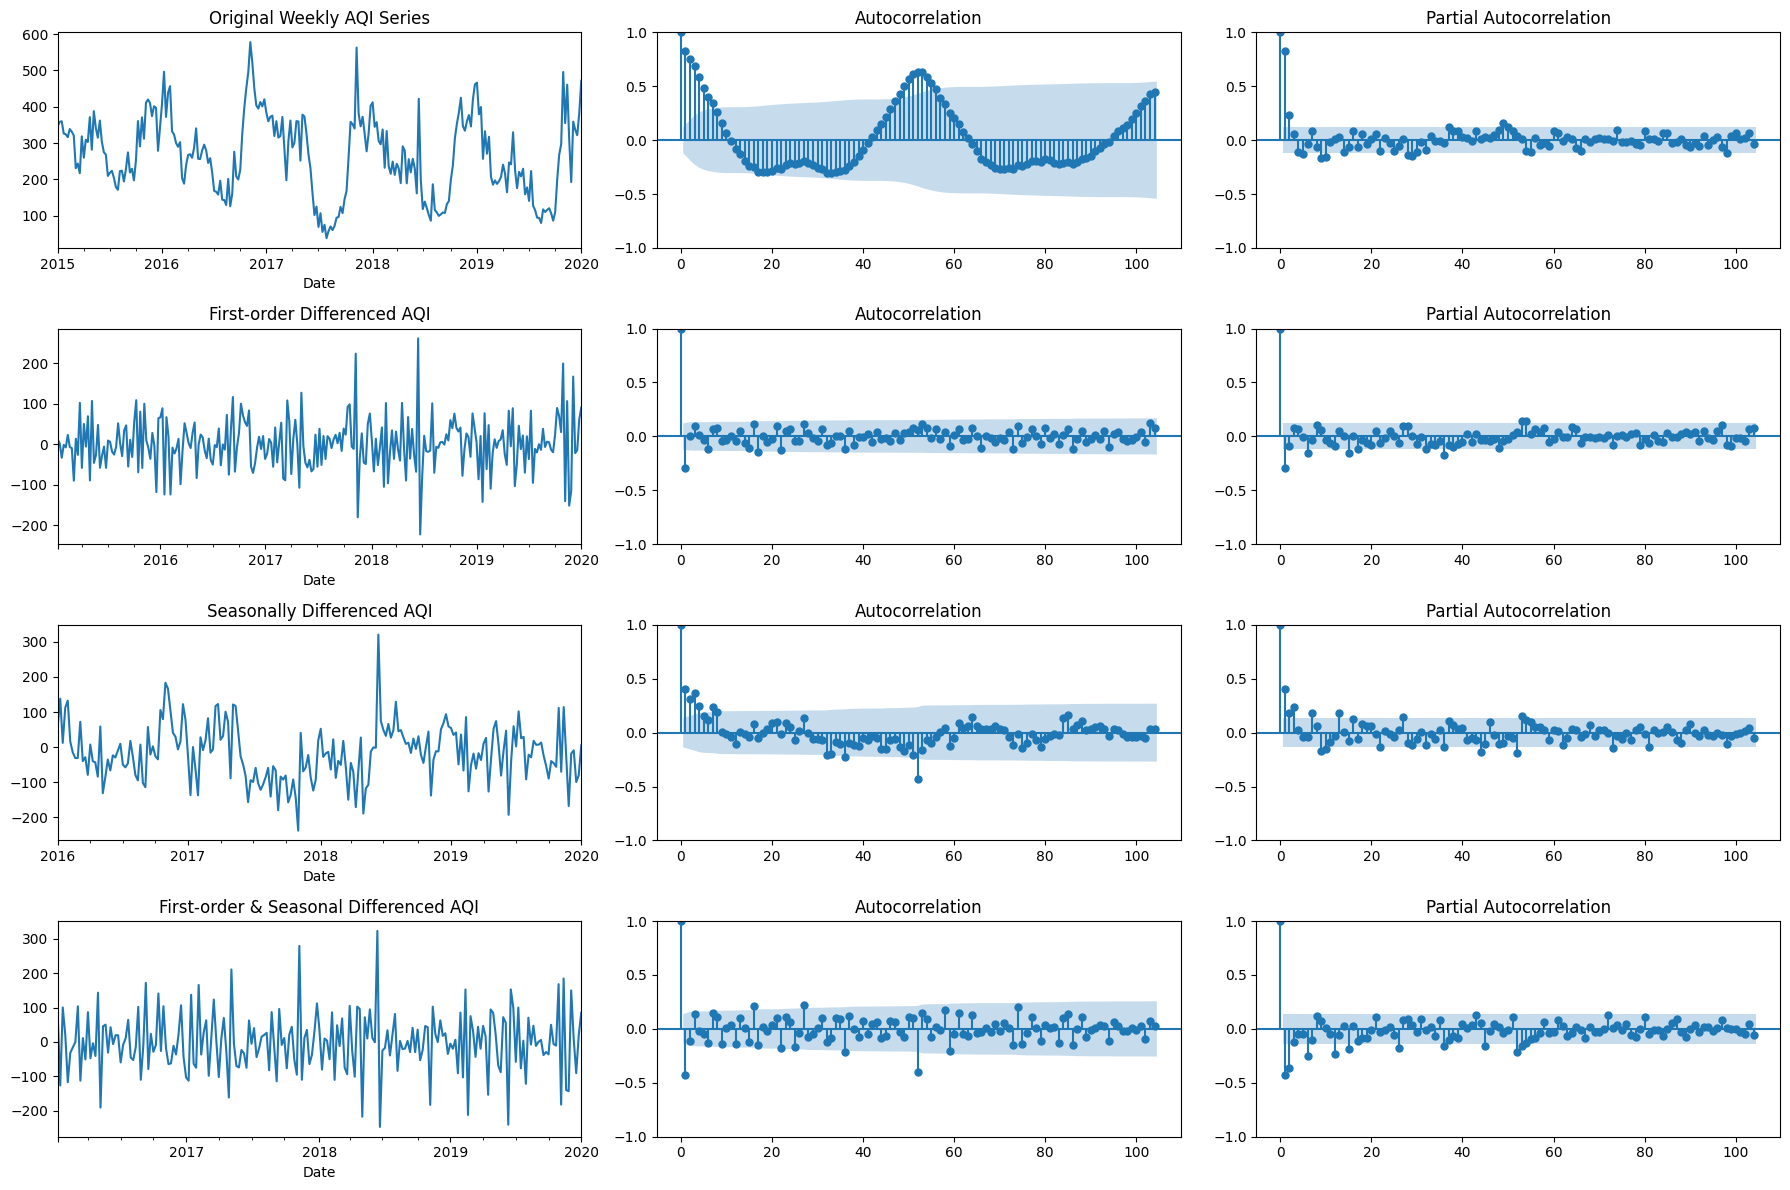

Train size: 209, Test size: 53
       order seasonal_order          AIC          BIC
3  (2, 1, 1)  (1, 1, 2, 52)   554.423467   567.807628
1  (2, 1, 1)  (0, 1, 2, 52)   556.801488   568.273626
2  (2, 1, 1)  (1, 1, 1, 52)  1110.313595  1126.063432
0  (2, 1, 1)  (0, 1, 1, 52)  1113.691056  1126.815920
Best SARIMA Model based on BIC on training data:
order                 (2, 1, 1)
seasonal_order    (1, 1, 2, 52)
AIC                  554.423467
BIC                  567.807628
Name: 3, dtype: object
                                        SARIMAX Results                                        
Dep. Variable:                                     AQI   No. Observations:                  209
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 52)   Log Likelihood                -270.212
Date:                                 Wed, 19 Mar 2025   AIC                            554.423
Time:                                         10:01:16   BIC                            567.808
Sample:            

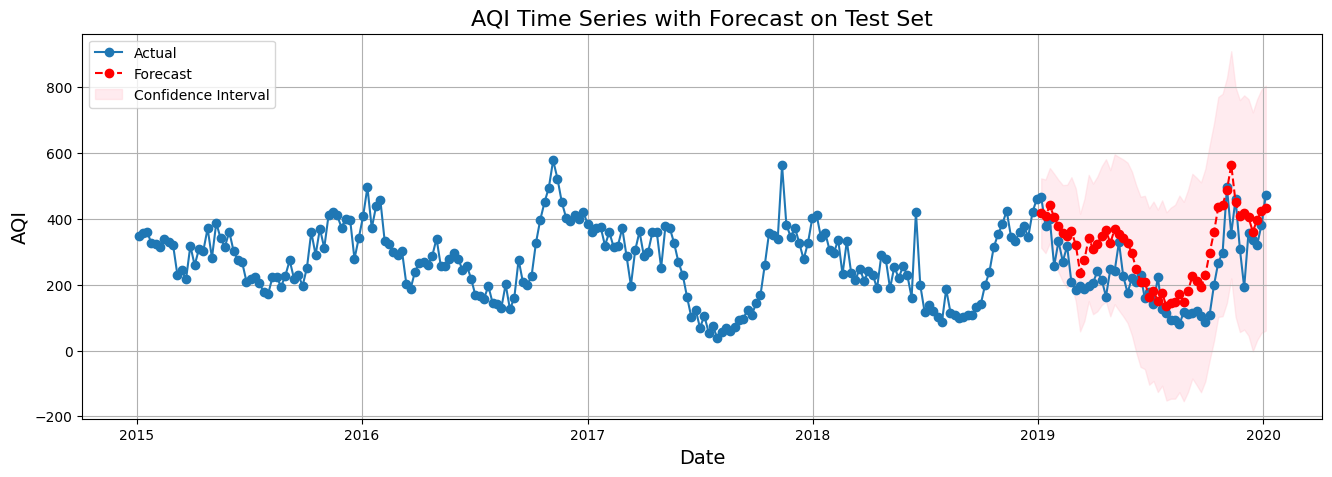

Test Error Metrics:
Mean Squared Error (MSE): 10635.5385
Root Mean Squared Error (RMSE): 103.1287
Mean Absolute Error (MAE): 86.2661


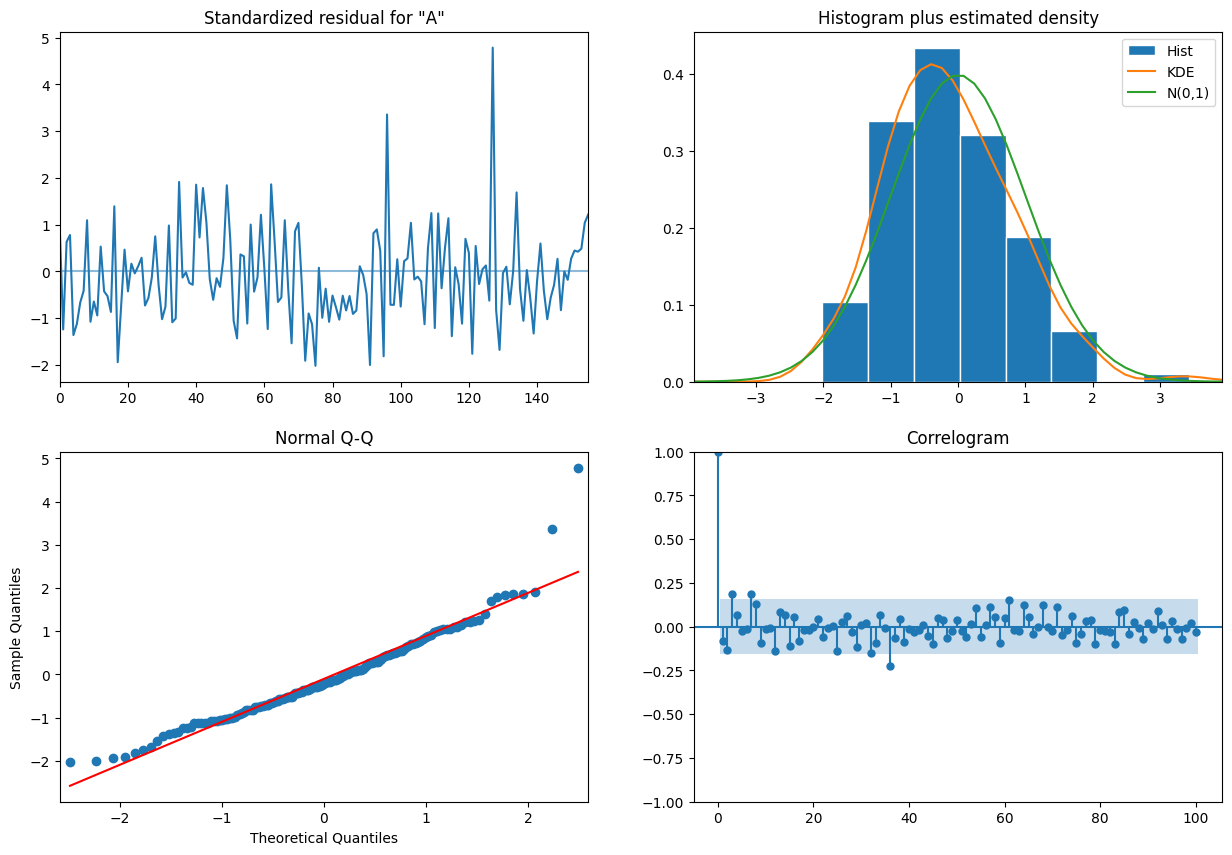

In [ ]:
# ------------------ FIRST SCENARIO, mixed components ------------------

import itertools
import warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

# Load the CSV file
file_path = "air_quality_ts.csv"
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data by week and compute the mean AQI
df_sarima = df['AQI'].resample('W').mean().reset_index()

# First-order differencing to remove trend
df_sarima['AQI_diff'] = df_sarima['AQI'].diff()

# Seasonal Differencing to Remove Seasonality (Assuming yearly seasonality in weekly data)
df_sarima['AQI_seasonal_diff'] = df_sarima['AQI'].diff(52)

# Seasonal Differencing to Remove Seasonality (Assuming yearly seasonality in weekly data)
df_sarima['AQI_diff_seasonal_diff'] = df_sarima['AQI_diff'].diff(52)

# ---- Perform ADF test ----

# Drop NA values resulting from differencing before ADF test
df_test = df_sarima['AQI_diff_seasonal_diff'].dropna()

# Perform ADF test on AQI_diff_seasonal_diff
adf_result = adfuller(df_test)

# Print the ADF test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

# Interpretation of results
if adf_result[1] <= 0.05:
    print("The series is stationary (reject the null hypothesis)")
else:
    print("The series is non-stationary (fail to reject the null hypothesis)")

# Increase the number of lags displayed in ACF and PACF plots
lags = 104  # Show up to one year of weekly lags

# Plot the series with extended lags for ACF and PACF
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Original Series
df_sarima.set_index('Date')['AQI'].plot(ax=axes[0, 0], title="Original Weekly AQI Series")
plot_acf(df_sarima['AQI'].dropna(), ax=axes[0, 1], lags=lags)
plot_pacf(df_sarima['AQI'].dropna(), ax=axes[0, 2], lags=lags)

# First-order Differenced Series
df_sarima.set_index('Date')['AQI_diff'].dropna().plot(ax=axes[1, 0], title="First-order Differenced AQI")
plot_acf(df_sarima['AQI_diff'].dropna(), ax=axes[1, 1], lags=lags)
plot_pacf(df_sarima['AQI_diff'].dropna(), ax=axes[1, 2], lags=lags)

# Seasonal Differenced Series
df_sarima.set_index('Date')['AQI_seasonal_diff'].dropna().plot(ax=axes[2, 0], title="Seasonally Differenced AQI")
plot_acf(df_sarima['AQI_seasonal_diff'].dropna(), ax=axes[2, 1], lags=lags)
plot_pacf(df_sarima['AQI_seasonal_diff'].dropna(), ax=axes[2, 2], lags=lags)

# First-order and Seasonal Differenced Series
df_sarima.set_index('Date')['AQI_diff_seasonal_diff'].dropna().plot(ax=axes[3, 0], title="First-order & Seasonal Differenced AQI")
plot_acf(df_sarima['AQI_diff_seasonal_diff'].dropna(), ax=axes[3, 1], lags=lags)
plot_pacf(df_sarima['AQI_diff_seasonal_diff'].dropna(), ax=axes[3, 2], lags=lags)

# Adjust layout
plt.tight_layout()
plt.show()

# ---- Train/Test Split ----
train_size = int(len(df_sarima) * 0.8)
train, test = df_sarima.iloc[:train_size], df_sarima.iloc[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

# ---- SARIMA Parameter Search on Training Data ----
p_values = [2]
d_values = [1]
q_values = [1]
P_values = [0,1]
D_values = [1]
Q_values = [1,2]
s = 52  # Seasonal period

# Generate all parameter combinations
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

results = []
for params in param_combinations:
    order = (params[0], params[1], params[2])
    seasonal_order = (params[3], params[4], params[5], s)
    try:
        model = sm.tsa.statespace.SARIMAX(
            train["AQI"],
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results_model = model.fit(disp=False)
        results.append({
            'order': order,
            'seasonal_order': seasonal_order,
            'AIC': results_model.aic,
            'BIC': results_model.bic
        })
    except Exception as e:
        print(f"Failed to fit SARIMA{order} x {seasonal_order}: {e}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='BIC')
print(results_df)

# Select best model based on BIC
best_model = results_df.iloc[0]
print("Best SARIMA Model based on BIC on training data:")
print(best_model)

# ---- Fit the Best Model on Training Data ----
best_order = best_model['order']
best_seasonal_order = best_model['seasonal_order']
final_model = sm.tsa.statespace.SARIMAX(
    train["AQI"],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_results = final_model.fit(disp=False)
print(final_results.summary())

# ---- Forecast on the Test Set ----
forecast_results = final_results.get_forecast(steps=len(test))
forecast = forecast_results.predicted_mean
forecast_conf_int = forecast_results.conf_int()

# ---- Plot the Entire Series and Forecast for the Test Period ----
plt.figure(figsize=(16, 5))
plt.plot(df_sarima['Date'], df_sarima['AQI'], label='Actual', marker='o', linestyle='-')
plt.plot(test['Date'], forecast, label='Forecast', marker='o', linestyle='--', color='red')
plt.fill_between(test['Date'],
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("AQI Time Series with Forecast on Test Set", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("AQI", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# ---- Compute Error Metrics on Test Set ----
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Get actual values from the test set and forecasted values
y_true = test['AQI'].values
y_pred = forecast.values

# Compute metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("Test Error Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot diagnostic plots for the residuals
final_model = sm.tsa.statespace.SARIMAX(
    train["AQI"],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_invertibility=False
)
final_results = final_model.fit(disp=False)
final_results.plot_diagnostics(figsize=(15, 10), lags=100)
plt.show()

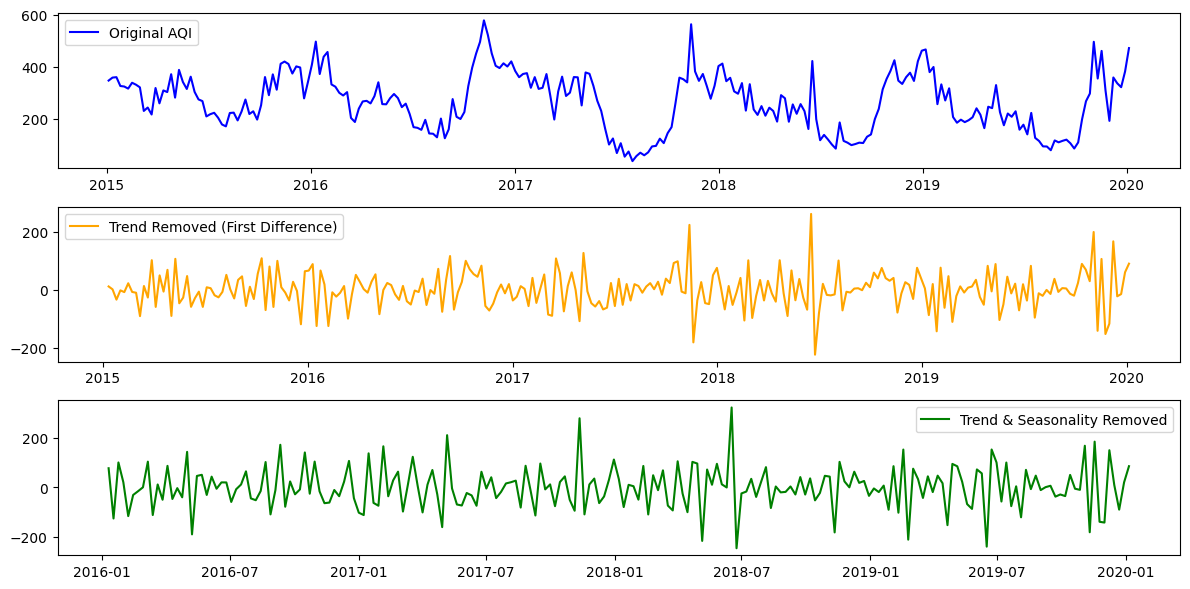

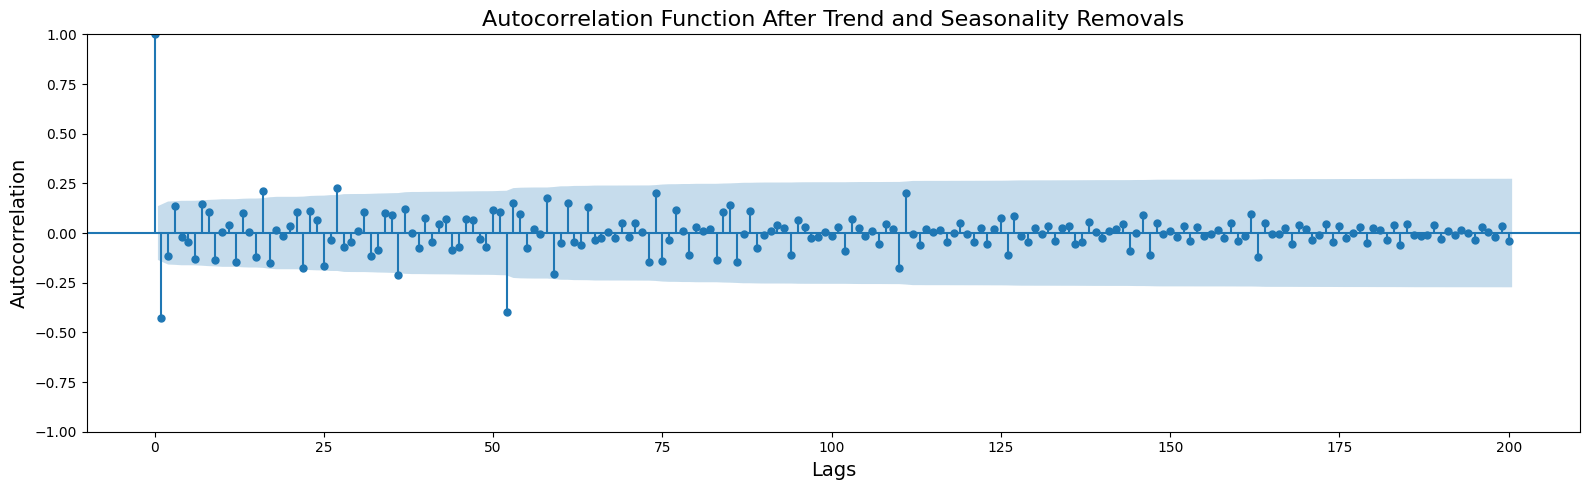

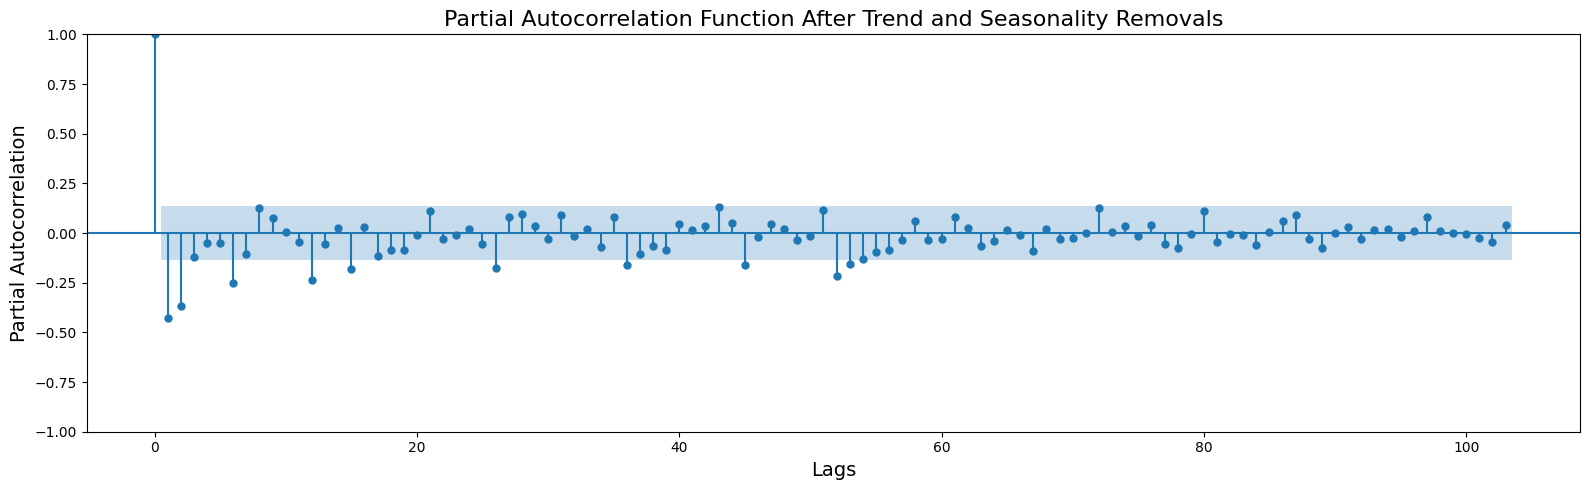

Train size: 209, Test size: 53
       order seasonal_order          AIC          BIC
1  (0, 1, 1)  (0, 1, 2, 52)   554.149860   561.797952
0  (0, 1, 1)  (0, 1, 1, 52)  1112.875831  1120.750750
Best SARIMA Model based on BIC on training data:
order                 (0, 1, 1)
seasonal_order    (0, 1, 2, 52)
AIC                   554.14986
BIC                  561.797952
Name: 1, dtype: object


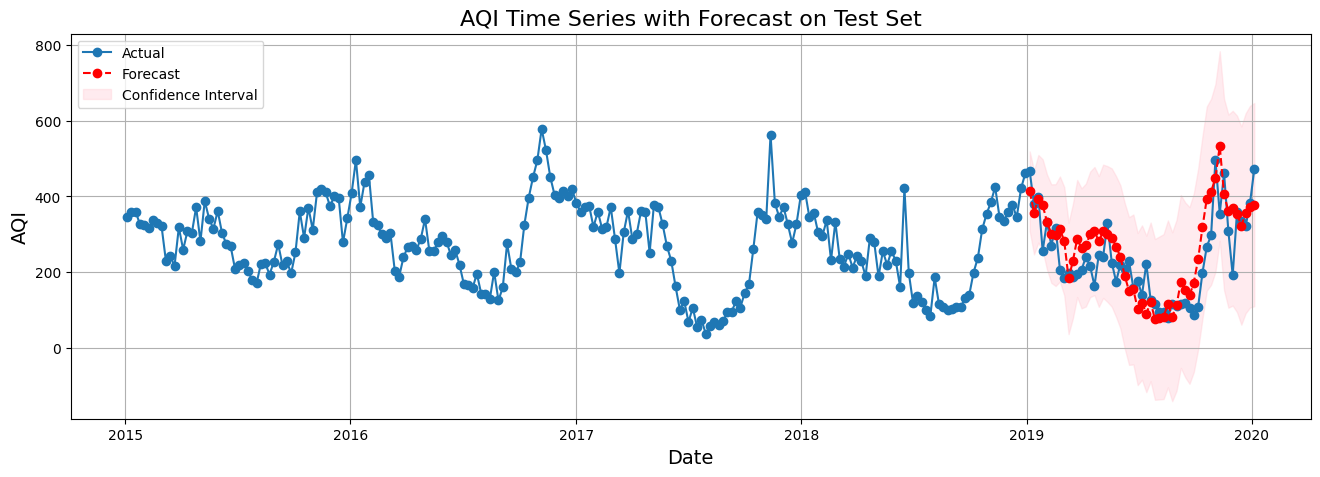

Test Error Metrics:
Mean Squared Error (MSE): 5496.0928
Root Mean Squared Error (RMSE): 74.1356
Mean Absolute Error (MAE): 57.8642


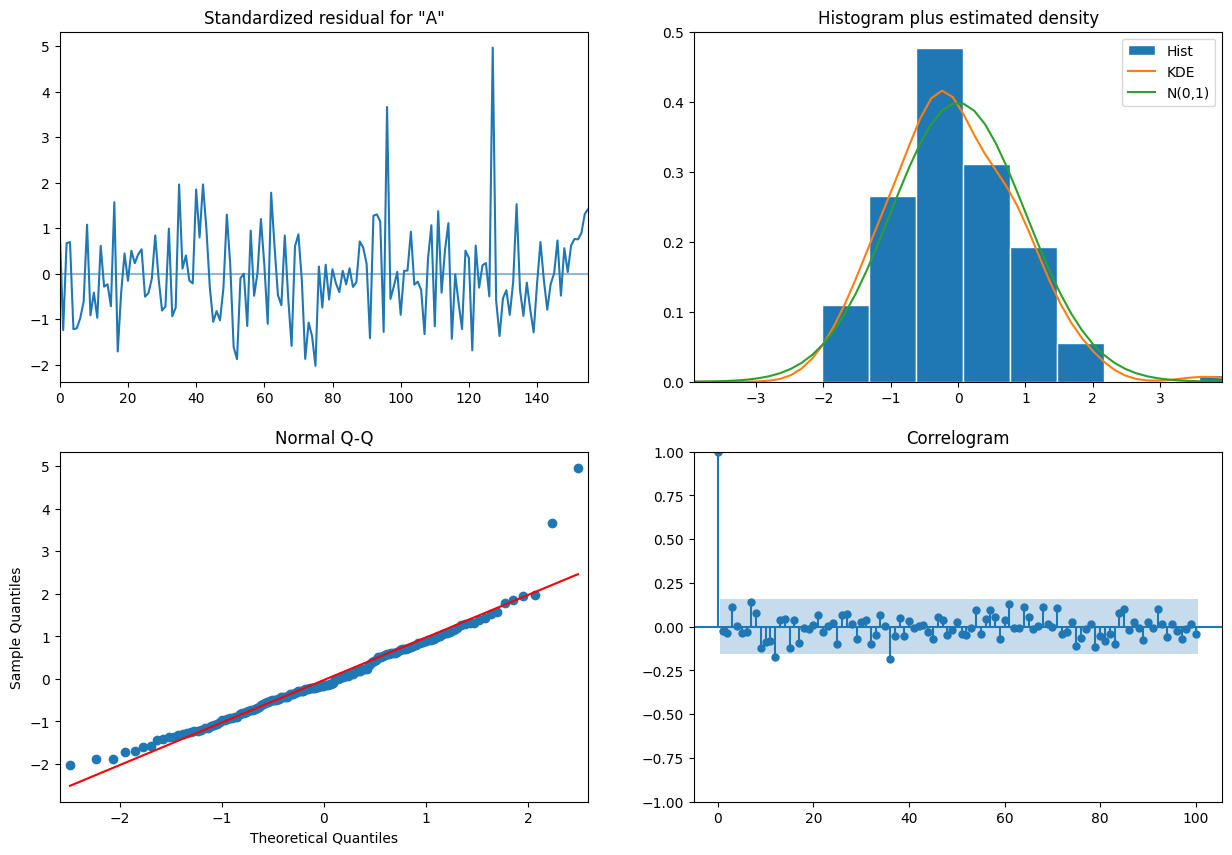

In [ ]:
# ------------------ SECOND SCENARIO, only dominant components ------------------

import itertools
import warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

# Read the CSV file and preprocess the data
df = pd.read_csv('/content/air_quality_ts.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample data by week and compute the mean AQI
df_sarima = df['AQI'].resample('W').mean().reset_index()

# First-order differencing to remove trend
df_sarima['AQI_diff'] = df_sarima['AQI'].diff()

# Seasonal Differencing to Remove Seasonality (Assuming yearly seasonality in weekly data)
df_sarima['AQI_seasonal_diff'] = df_sarima['AQI_diff'].diff(52)

# Plot the series before and after removing trend and seasonality
plt.figure(figsize=(12, 6))

# Original AQI
plt.subplot(3, 1, 1)
plt.plot(df_sarima['Date'], df_sarima['AQI'], label='Original AQI', color='blue')
plt.legend()

# First differencing
plt.subplot(3, 1, 2)
plt.plot(df_sarima['Date'], df_sarima['AQI_diff'], label='Trend Removed (First Difference)', color='orange')
plt.legend()

# Seasonal differencing
plt.subplot(3, 1, 3)
plt.plot(df_sarima['Date'], df_sarima['AQI_seasonal_diff'], label='Trend & Seasonality Removed', color='green')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the Autocorrelation Function (ACF) with 70 lags
plt.figure(figsize=(16, 5))
plot_acf(df_sarima['AQI_seasonal_diff'].dropna(), lags=200, ax=plt.gca())
plt.title("Autocorrelation Function After Trend and Seasonality Removals", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()

# Plot the Partial Autocorrelation Function (PACF) with 70 lags
plt.figure(figsize=(16, 5))
plot_pacf(df_sarima['AQI_seasonal_diff'].dropna(), lags=103, ax=plt.gca())
plt.title("Partial Autocorrelation Function After Trend and Seasonality Removals", fontsize=16)
plt.xlabel("Lags", fontsize=14)
plt.ylabel("Partial Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()

# ---- Train/Test Split ----
train_size = int(len(df_sarima) * 0.8)
train, test = df_sarima.iloc[:train_size], df_sarima.iloc[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

# ---- SARIMA Parameter Search on Training Data ----
p_values = [0]
d_values = [1]
q_values = [1]
P_values = [0]
D_values = [1]
Q_values = [1,2]
s = 52  # Seasonal period

# Generate all parameter combinations
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))

results = []
for params in param_combinations:
    order = (params[0], params[1], params[2])
    seasonal_order = (params[3], params[4], params[5], s)
    try:
        model = sm.tsa.statespace.SARIMAX(
            train["AQI"],
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results_model = model.fit(disp=False)
        results.append({
            'order': order,
            'seasonal_order': seasonal_order,
            'AIC': results_model.aic,
            'BIC': results_model.bic
        })
    except Exception as e:
        print(f"Failed to fit SARIMA{order} x {seasonal_order}: {e}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='BIC')
print(results_df)

# Select best model based on BIC
best_model = results_df.iloc[0]
print("Best SARIMA Model based on BIC on training data:")
print(best_model)

# ---- Fit the Best Model on Training Data ----
best_order = best_model['order']
best_seasonal_order = best_model['seasonal_order']
final_model = sm.tsa.statespace.SARIMAX(
    train["AQI"],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_results = final_model.fit(disp=False)

# ---- Forecast on the Test Set ----
forecast_results = final_results.get_forecast(steps=len(test))
forecast = forecast_results.predicted_mean
forecast_conf_int = forecast_results.conf_int()

# ---- Plot the Entire Series and Forecast for the Test Period ----
plt.figure(figsize=(16, 5))
plt.plot(df_sarima['Date'], df_sarima['AQI'], label='Actual', marker='o', linestyle='-')
plt.plot(test['Date'], forecast, label='Forecast', marker='o', linestyle='--', color='red')
plt.fill_between(test['Date'],
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("AQI Time Series with Forecast on Test Set", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("AQI", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# ---- Compute Error Metrics on Test Set ----
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Get actual values from the test set and forecasted values
y_true = test['AQI'].values
y_pred = forecast.values

# Compute metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("Test Error Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot diagnostic plots for the residuals
final_model = sm.tsa.statespace.SARIMAX(
    train["AQI"],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_invertibility=False
)
final_results = final_model.fit(disp=False)
final_results.plot_diagnostics(figsize=(15, 10), lags=100)
plt.show()

## PROPHET

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1kina2jy/o45p59q2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1kina2jy/cn_c2kkh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95253', 'data', 'file=/tmp/tmp1kina2jy/o45p59q2.json', 'init=/tmp/tmp1kina2jy/cn_c2kkh.json', 'output', 'file=/tmp/tmp1kina2jy/prophet_modeln6j1qioh/prophet_model-20250319100538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:05:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 6015.972265456654
MAE: 60.31496951604172
RMSE: 77.56269893097232


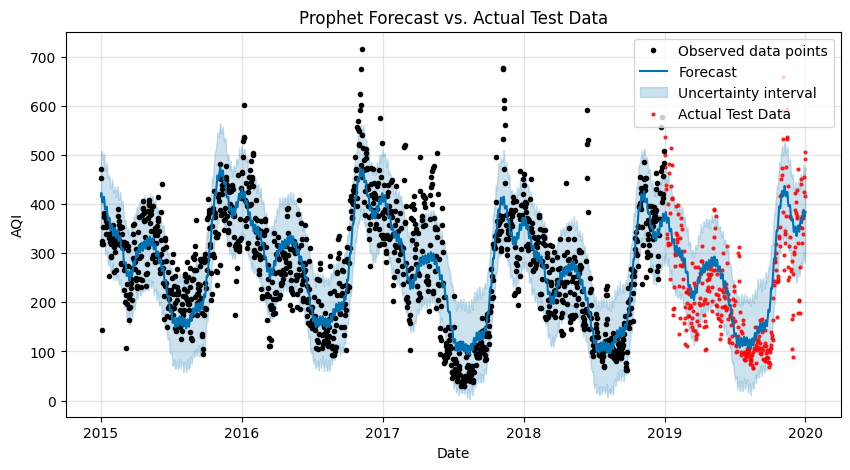

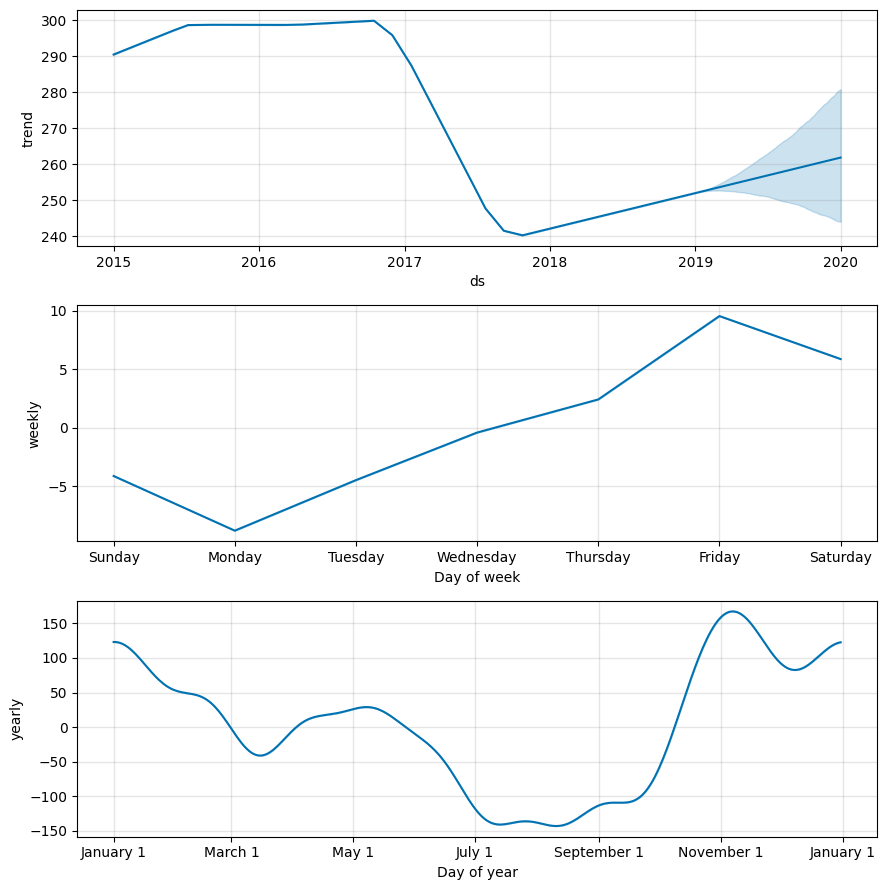

In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly

# Read the CSV file (adjust the path if necessary)
df = pd.read_csv('/content/air_quality_ts.csv')

# Convert 'Date' to datetime and rename columns for Prophet
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.rename(columns={'Date': 'ds', 'AQI': 'y'})
df = df[['ds', 'y']]

# Sort the dataframe in case it's not in chronological order
df = df.sort_values('ds').reset_index(drop=True)

# Calculate the index for an 80/20 split
split_idx = int(0.8 * len(df))

# Split data into training (first 80%) and test (remaining 20%)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Instantiate and fit the Prophet model on the training data
m = Prophet(yearly_seasonality=True)
m.fit(train)

# Create a future dataframe that extends to cover the test period.
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)

# Extract forecast values for the test period
forecast_test = forecast.iloc[-len(test):]  # last len(test) rows

# Compute error metrics comparing the actual test values with the forecast
mse = mean_squared_error(test['y'], forecast_test['yhat'])
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mse)

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)

# Plot the forecast and overlay the actual test data with smaller red points
fig, ax = plt.subplots(figsize=(10, 5))
m.plot(forecast, ax=ax)  # Prophet's built-in plot

# Overlay actual test data with smaller points
ax.scatter(test['ds'], test['y'], color='red', label='Actual Test Data', marker='o', s=4, alpha=0.8)

# Add labels and legend
ax.set_title("Prophet Forecast vs. Actual Test Data")
ax.set_xlabel("Date")
ax.set_ylabel("AQI")
ax.legend()
plt.show()

# Plot forecast components (trend, yearly seasonality, etc.)
fig2 = m.plot_components(forecast)
plt.show()

# Optionally, if you want interactive plots (e.g., in a Jupyter Notebook), use Plotly:
fig_interactive = plot_plotly(m, forecast)
fig_interactive.show()

fig_components_interactive = plot_components_plotly(m, forecast)
fig_components_interactive.show()


## Fourier

  Model Type  k           MSE        RMSE         MAE  \
0   Original  1  15709.976351  125.339445  106.356905   
1   Original  2  11677.489132  108.062432   90.121774   
2   Original  3  10430.788788  102.131233   82.669510   
3   Original  4   8798.038539   93.797860   75.127537   
4   Original  5   8338.558376   91.315707   72.145229   

                                            Forecast  
0  [274.9125176016682, 274.9125176016682, 274.912...  
1  [327.0218006879001, 327.1527589767133, 327.268...  
2  [379.1310837741305, 379.39300035175967, 379.62...  
3  [382.3049365339813, 381.3906143713571, 380.443...  
4  [385.47878929385377, 383.388228390962, 381.262...  

Best Original Fourier Model:
  Model Type  k          MSE       RMSE        MAE  \
4   Original  5  8338.558376  91.315707  72.145229   

                                            Forecast  
4  [385.47878929385377, 383.388228390962, 381.262...  

Best Detrended Fourier Model:
    Model Type  k           MSE        RMSE    

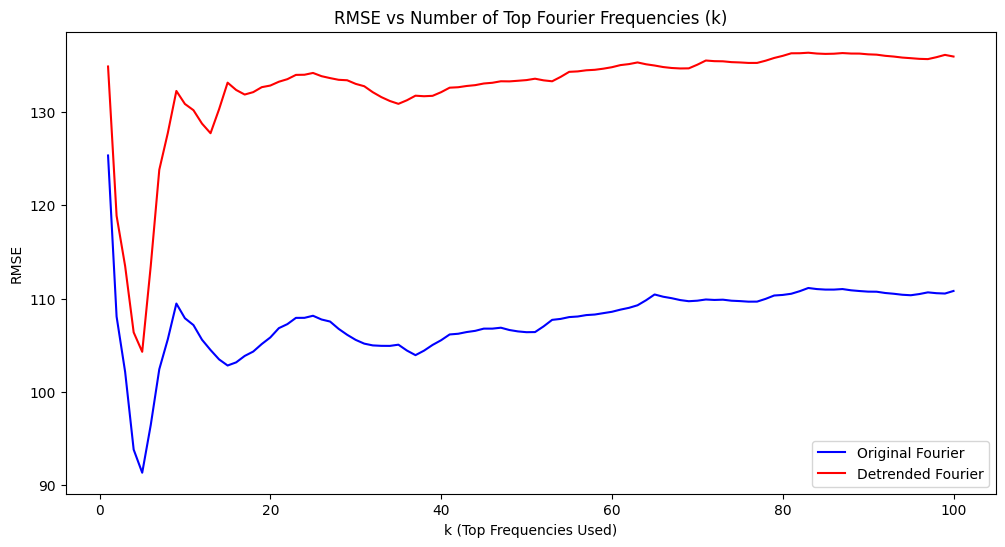

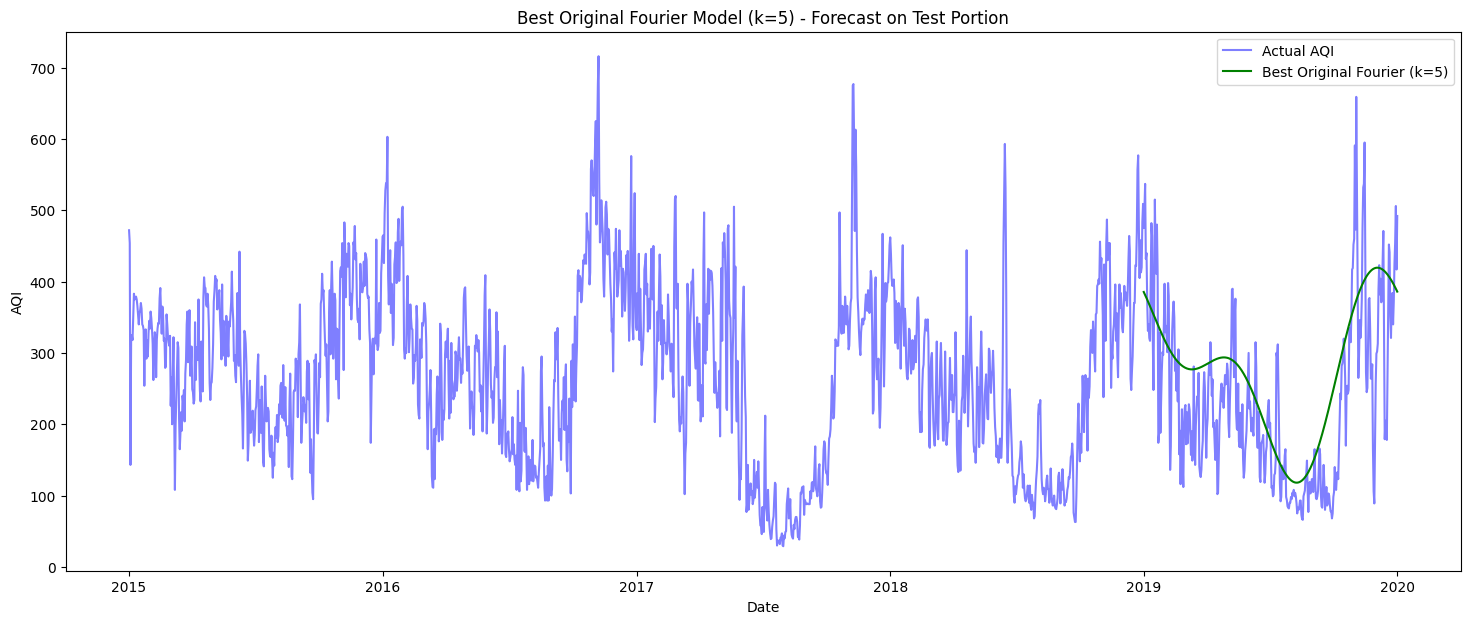

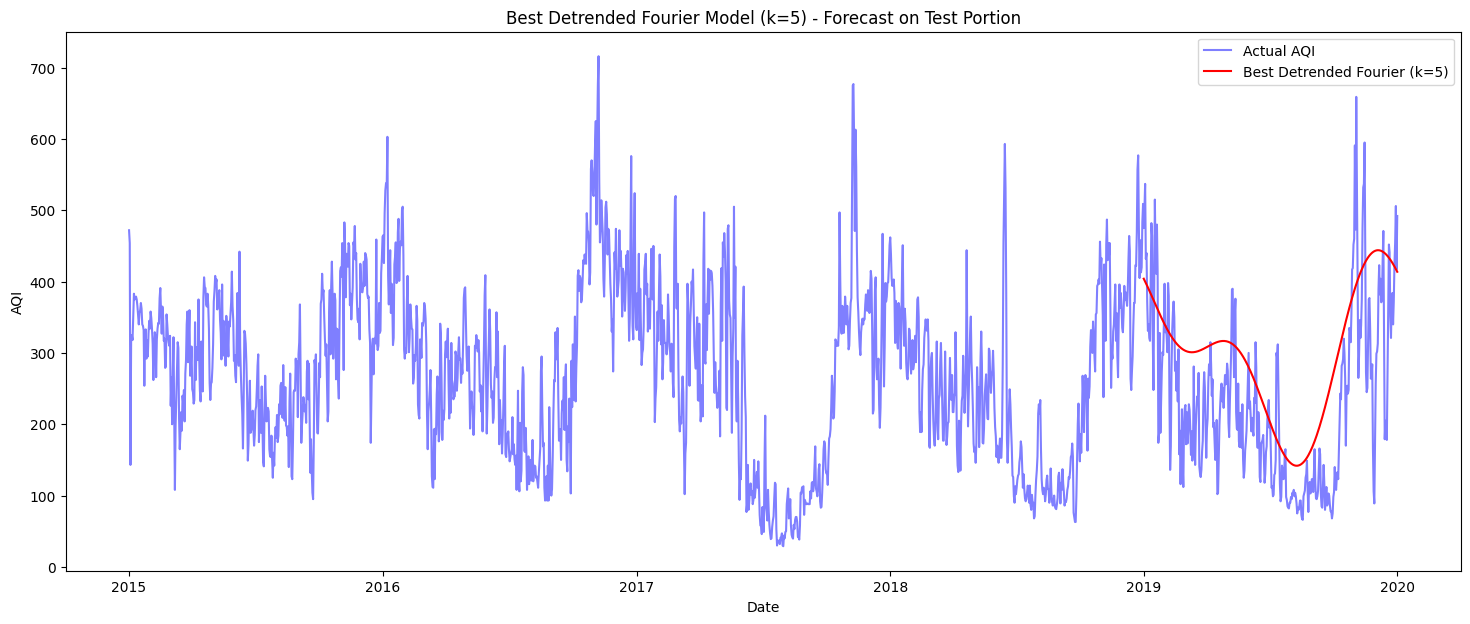

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------------------------
# Load and Prepare the Dataset
# ---------------------------
df = pd.read_csv('/content/air_quality_ts.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
aqi = df[['AQI']]

# ---------------------------
# Train/Test Split (80/20)
# ---------------------------
n = len(aqi)
n_train = int(n * 0.8)
train = aqi.iloc[:n_train]
test = aqi.iloc[n_train:]
T_total = n_train + len(test)  # total number of points (train + test)

# ---------------------------
# Define a Fourier Forecast Function
# ---------------------------
def fourier_forecast(filtered_fft, N_train, T_total):
    """
    Given a filtered FFT (of length N_train) from training data,
    compute the Fourier reconstruction (and extrapolation) for T_total points.
    """
    t = np.arange(T_total)
    m = np.arange(N_train)
    exp_term = np.exp(2j * np.pi * np.outer(m, t) / N_train)
    forecast = np.dot(filtered_fft, exp_term) / N_train
    return forecast.real

# ---------------------------
# Container for Model Evaluation Results
# ---------------------------
results = []  # List to store error metrics

# ---------------------------
# Loop Over Two Model Types:
#   (1) "Original": Fourier reconstruction on the raw training series
#   (2) "Detrended": Remove a linear trend from the training data, forecast in the detrended domain, and add back the trend.
# ---------------------------
k_values = list(range(1, 101))  # k from 1 to 100

for model_type in ['Original', 'Detrended']:
    for k in k_values:

        if model_type == 'Original':
            # Fourier on Original Series (Training Data)
            series_train = train['AQI'].values
            fft_train = np.fft.fft(series_train)
            magnitude = np.abs(fft_train)
            sorted_indices = np.argsort(magnitude)[::-1]
            top_k_indices = sorted_indices[:k]

            # Filter the FFT: only keep top k frequencies
            filtered_fft = np.zeros_like(fft_train, dtype=complex)
            filtered_fft[top_k_indices] = fft_train[top_k_indices]

            # Forecast the full series (training + forecast period)
            forecast_full = fourier_forecast(filtered_fft, n_train, T_total)
            forecast_test = forecast_full[n_train:]

        elif model_type == 'Detrended':
            # Fourier on Detrended Series (Training Data)
            series_train = train['AQI'].values
            time_idx_train = np.arange(n_train)
            slope = (series_train[-1] - series_train[0]) / (n_train - 1)
            trend_train = slope * time_idx_train
            detrended_train = series_train - trend_train

            fft_train = np.fft.fft(detrended_train)
            magnitude = np.abs(fft_train)
            sorted_indices = np.argsort(magnitude)[::-1]
            top_k_indices = sorted_indices[:k]
            filtered_fft = np.zeros_like(fft_train, dtype=complex)
            filtered_fft[top_k_indices] = fft_train[top_k_indices]

            forecast_detrended_full = fourier_forecast(filtered_fft, n_train, T_total)
            time_idx_full = np.arange(T_total)
            trend_full = slope * time_idx_full
            forecast_full = forecast_detrended_full + trend_full
            forecast_test = forecast_full[n_train:]

        # Compute error metrics
        mse = mean_squared_error(test['AQI'].values, forecast_test)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test['AQI'].values, forecast_test)

        # Store the results
        results.append({
            'Model Type': model_type,
            'k': k,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'Forecast': forecast_test  # Store forecast for later use
        })

# ---------------------------
# Convert results to DataFrame and Display Results
# ---------------------------
results_df = pd.DataFrame(results)

print(results_df.head(5))

# Find the best model for each type
best_original_model = results_df[results_df['Model Type'] == 'Original'].nsmallest(1, 'RMSE')
best_detrended_model = results_df[results_df['Model Type'] == 'Detrended'].nsmallest(1, 'RMSE')

# Display the best models
print("\nBest Original Fourier Model:")
print(best_original_model)

print("\nBest Detrended Fourier Model:")
print(best_detrended_model)

# ---------------------------
# Plot RMSE vs k for Both Models
# ---------------------------
plt.figure(figsize=(12, 6))
plt.plot(results_df[results_df['Model Type'] == 'Original']['k'],
         results_df[results_df['Model Type'] == 'Original']['RMSE'],
         label="Original Fourier", color="blue")

plt.plot(results_df[results_df['Model Type'] == 'Detrended']['k'],
         results_df[results_df['Model Type'] == 'Detrended']['RMSE'],
         label="Detrended Fourier", color="red")

plt.xlabel("k (Top Frequencies Used)")
plt.ylabel("RMSE")
plt.title("RMSE vs Number of Top Fourier Frequencies (k)")
plt.legend()
plt.show()

# ---------------------------
# Plot the Best Two Models
# ---------------------------
best_original_k = best_original_model['k'].values[0]
best_detrended_k = best_detrended_model['k'].values[0]

# Retrieve the best forecasts
best_original_forecast = best_original_model['Forecast'].values[0]
best_detrended_forecast = best_detrended_model['Forecast'].values[0]

# Plot for Best Original Fourier Model
plt.figure(figsize=(18, 7))
plt.plot(aqi.index, aqi['AQI'], label='Actual AQI', color='blue', alpha=0.5)
plt.plot(aqi.index[n_train:], best_original_forecast, label=f'Best Original Fourier (k={best_original_k})', color='green')
plt.title(f"Best Original Fourier Model (k={best_original_k}) - Forecast on Test Portion")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()

# Plot for Best Detrended Fourier Model
plt.figure(figsize=(18, 7))
plt.plot(aqi.index, aqi['AQI'], label='Actual AQI', color='blue', alpha=0.5)
plt.plot(aqi.index[n_train:], best_detrended_forecast, label=f'Best Detrended Fourier (k={best_detrended_k})', color='red')
plt.title(f"Best Detrended Fourier Model (k={best_detrended_k}) - Forecast on Test Portion")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()


## Regression with Fourier terms

Approach 1: Linear Trend Only RMSE:
                     RMSE
Lasso         118.234818
Ridge         118.234890
Linear        118.234890
SVR           118.555955
XGBoost       248.911992
RandomForest  289.154576
DecisionTree  300.360285
Best model for Linear Trend Only according to RMSE: Lasso


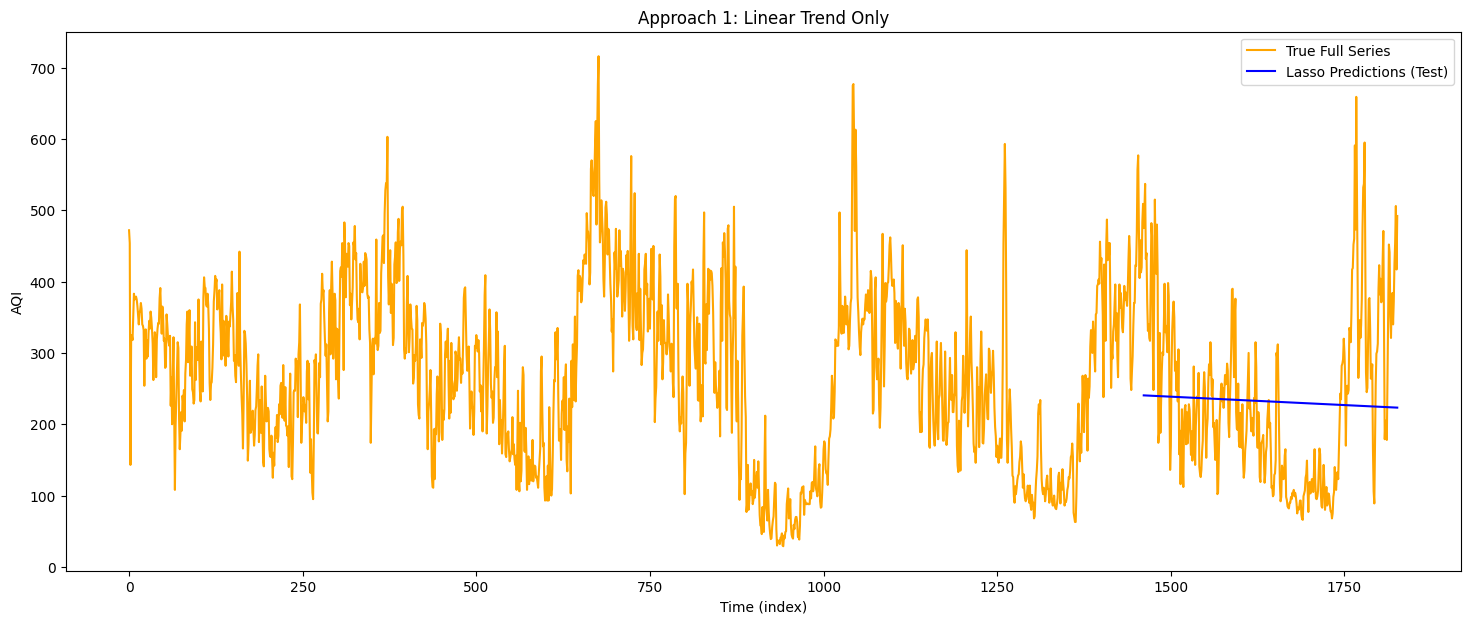

Approach 2: Linear Trend + Annual Seasonality RMSE:
                     RMSE
Ridge          74.760403
Linear         74.762605
Lasso          75.528279
SVR            78.323229
RandomForest  109.098193
XGBoost       115.473200
DecisionTree  165.433170
Best model for Linear Trend + Annual Seasonality according to RMSE: Ridge


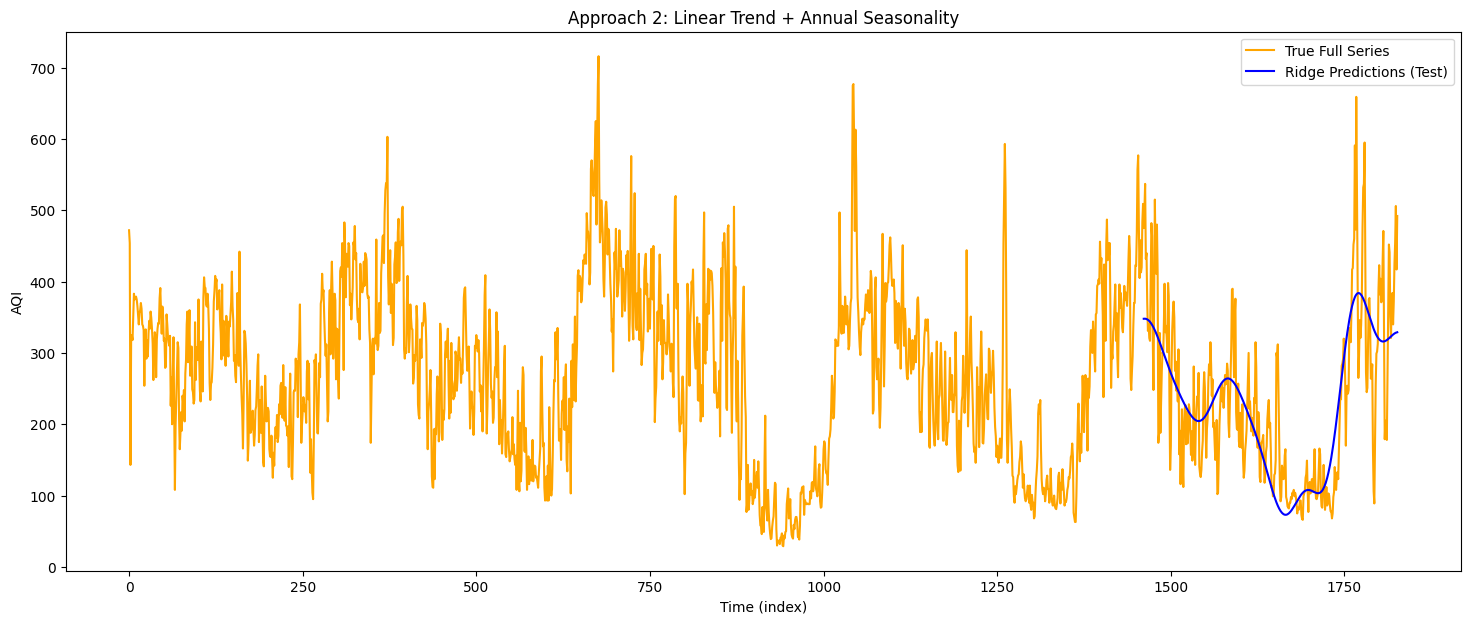

Approach 3: Linear Trend + Annual Seasonality + AR(1) RMSE:
                     RMSE
Ridge          73.378496
Linear         73.385861
SVR            75.655396
Lasso          76.014345
RandomForest   87.913970
XGBoost        90.062754
DecisionTree  123.009385
Best model for Linear Trend + Annual Seasonality + AR(1) according to RMSE: Ridge


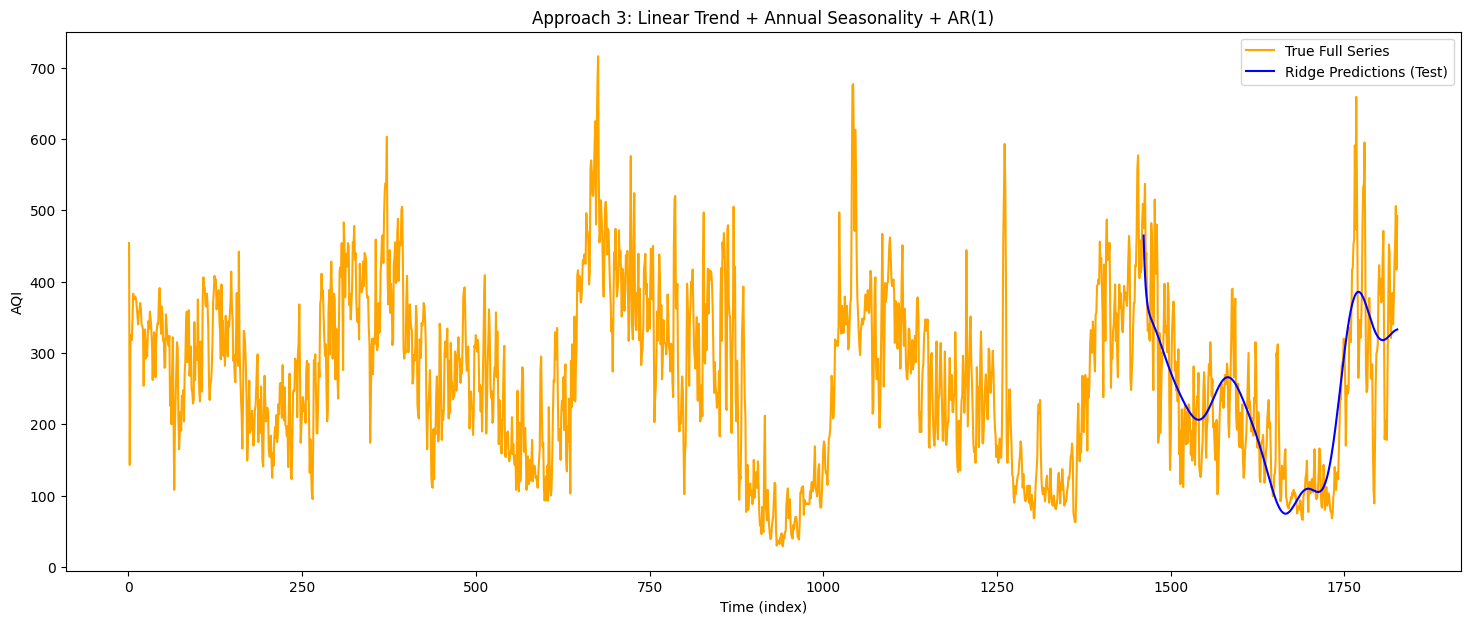

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# ======================================================
# 1. READ & PREPARE THE DATA
# ======================================================
df = pd.read_csv('/content/air_quality_ts.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# ======================================================
# 2. TRAIN-TEST SPLIT (80/20)
# ======================================================
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# ======================================================
# 3. HELPER FUNCTIONS
# ======================================================
def fit_regression_model(model_name, X, y):
    """
    Fits a regression model based on the given model name and data.
    Returns the fitted model.
    """
    models = {
        'Linear': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'RandomForest': RandomForestRegressor(),
        'SVR': SVR(kernel='linear'),
        'DecisionTree': DecisionTreeRegressor(),
        'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
    }
    if model_name not in models:
        raise ValueError(f"Invalid model name '{model_name}'. Choose from: {list(models.keys())}")
    model = models[model_name]
    model.fit(X, y)
    return model

def plot_full_series(train_series, test_series, y_pred, model_name, title):
    """
    Plots the full time series (concatenated train and test) and overlays the model predictions on the test portion.
    """
    full_series = pd.concat([train_series, test_series])
    plt.figure(figsize=(18, 7))
    plt.plot(full_series.index, full_series, label="True Full Series", color='orange')
    plt.plot(test_series.index, y_pred, label=f"{model_name} Predictions (Test)", color='blue')
    plt.xlabel('Time (index)')
    plt.ylabel('AQI')
    plt.title(title)
    plt.legend()
    plt.show()

models_names_list = ['Linear', 'Ridge', 'Lasso', 'RandomForest', 'SVR', 'DecisionTree', 'XGBoost']

# ======================================================
# 4. APPROACH 1: LINEAR TREND ONLY
# ======================================================
# Create a design matrix with an intercept + a linear time index
time_index = np.arange(len(df))  # 0, 1, 2, ..., N-1
X_linear = np.column_stack([np.ones(len(df)), time_index])

train_X_linear = X_linear[:split_index]
train_y_linear = train_df['AQI']
test_X_linear = X_linear[split_index:]
test_y_linear = test_df['AQI']

metrics_linear = {'MSE': {}, 'RMSE': {}, 'MAE': {}}
y_pred_linear = {}

for model_name in models_names_list:
    model = fit_regression_model(model_name, train_X_linear, train_y_linear)
    pred = model.predict(test_X_linear)
    y_pred_linear[model_name] = pred
    mse = mean_squared_error(test_y_linear, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_y_linear, pred)
    metrics_linear['MSE'][model_name] = mse
    metrics_linear['RMSE'][model_name] = rmse
    metrics_linear['MAE'][model_name] = mae

# Create and display RMSE table for Approach 1
rmse_linear_res = pd.DataFrame({'RMSE': metrics_linear['RMSE']}, index=models_names_list)
rmse_linear_res = rmse_linear_res.sort_values(by='RMSE')
print("Approach 1: Linear Trend Only RMSE:\n", rmse_linear_res)

# Identify best model according to RMSE for Approach 1
best_model_name_linear = min(metrics_linear['RMSE'], key=metrics_linear['RMSE'].get)
print("Best model for Linear Trend Only according to RMSE:", best_model_name_linear)

# Plot full time series with predictions (test portion) for best model (Approach 1)
plot_full_series(train_df['AQI'], test_y_linear, y_pred_linear[best_model_name_linear],
                 best_model_name_linear, "Approach 1: Linear Trend Only")

# ======================================================
# 5. APPROACH 2: LINEAR TREND + ANNUAL SEASONALITY (T = 365)
# ======================================================
# Create Fourier features for an annual cycle on daily data
num_harmonics = 6
T = 365  # annual cycle for daily data
lambdas = 2 * np.pi * np.arange(1, num_harmonics + 1) / T

# Build the Fourier features
X_seasonality = []
for t in time_index:
    cos_sin_terms = []
    for lam in lambdas:
        cos_sin_terms.append(np.cos(lam * t))
        cos_sin_terms.append(np.sin(lam * t))
    X_seasonality.append(cos_sin_terms)
X_seasonality = np.array(X_seasonality)

# Combine linear trend and Fourier seasonality features
X_linear_seasonality = np.concatenate([X_linear, X_seasonality], axis=1)

train_X_linear_seasonality = X_linear_seasonality[:split_index]
train_y_linear_seasonality = train_df['AQI']
test_X_linear_seasonality = X_linear_seasonality[split_index:]
test_y_linear_seasonality = test_df['AQI']

metrics_linear_seasonality = {'MSE': {}, 'RMSE': {}, 'MAE': {}}
y_pred_linear_seasonality = {}

for model_name in models_names_list:
    model = fit_regression_model(model_name, train_X_linear_seasonality, train_y_linear_seasonality)
    pred = model.predict(test_X_linear_seasonality)
    y_pred_linear_seasonality[model_name] = pred
    mse = mean_squared_error(test_y_linear_seasonality, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_y_linear_seasonality, pred)
    metrics_linear_seasonality['MSE'][model_name] = mse
    metrics_linear_seasonality['RMSE'][model_name] = rmse
    metrics_linear_seasonality['MAE'][model_name] = mae

# Create and display RMSE table for Approach 2
rmse_linear_seasonality_res = pd.DataFrame({'RMSE': metrics_linear_seasonality['RMSE']}, index=models_names_list)
rmse_linear_seasonality_res = rmse_linear_seasonality_res.sort_values(by='RMSE')
print("Approach 2: Linear Trend + Annual Seasonality RMSE:\n", rmse_linear_seasonality_res)

# Identify best model according to RMSE for Approach 2
best_model_name_linear_seasonality = min(metrics_linear_seasonality['RMSE'], key=metrics_linear_seasonality['RMSE'].get)
print("Best model for Linear Trend + Annual Seasonality according to RMSE:", best_model_name_linear_seasonality)

# Plot full time series with predictions (test portion) for best model (Approach 2)
plot_full_series(train_df['AQI'], test_y_linear_seasonality, y_pred_linear_seasonality[best_model_name_linear_seasonality],
                 best_model_name_linear_seasonality, "Approach 2: Linear Trend + Annual Seasonality")

# ======================================================
# 6. APPROACH 3: LINEAR TREND + ANNUAL SEASONALITY + AR(1)
# ======================================================
# Create a design matrix including linear+seasonality features at time t and the lagged AQI value (from time t-1)
X_AR = np.concatenate([X_linear_seasonality[1:], df['AQI'].values[:-1].reshape(-1, 1)], axis=1)

# Note: because of the lag, we adjust the train/test split accordingly
train_X_AR = X_AR[:split_index - 1]
train_y_AR = train_df['AQI'][1:]
test_X_AR = X_AR[split_index - 1:]
test_y_AR = test_df['AQI']

metrics_AR = {'MSE': {}, 'RMSE': {}, 'MAE': {}}
y_pred_AR = {}

for model_name in models_names_list:
    model = fit_regression_model(model_name, train_X_AR, train_y_AR)
    # Iterative forecasting: the predicted value becomes the lag for the next step
    predictions = []
    current_x = test_X_AR[0].copy()
    first_pred = model.predict(current_x.reshape(1, -1))[0]
    predictions.append(first_pred)
    for i in range(1, len(test_X_AR)):
        current_x = test_X_AR[i].copy()
        current_x[-1] = predictions[-1]
        pred = model.predict(current_x.reshape(1, -1))[0]
        predictions.append(pred)
    predictions = np.array(predictions)
    y_pred_AR[model_name] = predictions
    mse = mean_squared_error(test_y_AR, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_y_AR, predictions)
    metrics_AR['MSE'][model_name] = mse
    metrics_AR['RMSE'][model_name] = rmse
    metrics_AR['MAE'][model_name] = mae

# Create and display RMSE table for Approach 3
rmse_AR_res = pd.DataFrame({'RMSE': metrics_AR['RMSE']}, index=models_names_list)
rmse_AR_res = rmse_AR_res.sort_values(by='RMSE')
print("Approach 3: Linear Trend + Annual Seasonality + AR(1) RMSE:\n", rmse_AR_res)

# Identify best model according to RMSE for Approach 3
best_model_name_AR = min(metrics_AR['RMSE'], key=metrics_AR['RMSE'].get)
print("Best model for Linear Trend + Annual Seasonality + AR(1) according to RMSE:", best_model_name_AR)

# For AR approach, we use its specific training series (train_y_AR) and test series (test_y_AR)
plot_full_series(train_y_AR, test_y_AR, y_pred_AR[best_model_name_AR],
                 best_model_name_AR, "Approach 3: Linear Trend + Annual Seasonality + AR(1)")


## Neural Network

First Attempt

 11%|█         | 11/100 [00:01<00:08, 10.79it/s]


Epoch [10/100], Loss: 0.0247


 21%|██        | 21/100 [00:01<00:08,  9.76it/s]


Epoch [20/100], Loss: 0.0221


 33%|███▎      | 33/100 [00:02<00:04, 13.73it/s]


Epoch [30/100], Loss: 0.0126


 43%|████▎     | 43/100 [00:03<00:03, 15.53it/s]


Epoch [40/100], Loss: 0.0210


 53%|█████▎    | 53/100 [00:04<00:03, 15.48it/s]


Epoch [50/100], Loss: 0.0102


 61%|██████    | 61/100 [00:04<00:03, 12.44it/s]


Epoch [60/100], Loss: 0.0132


 71%|███████   | 71/100 [00:05<00:02, 10.48it/s]


Epoch [70/100], Loss: 0.0201


 81%|████████  | 81/100 [00:06<00:01, 13.85it/s]


Epoch [80/100], Loss: 0.0122


 91%|█████████ | 91/100 [00:07<00:01,  7.73it/s]


Epoch [90/100], Loss: 0.0125


100%|██████████| 100/100 [00:09<00:00, 10.87it/s]



Epoch [100/100], Loss: 0.0163
Test Loss: 0.0155


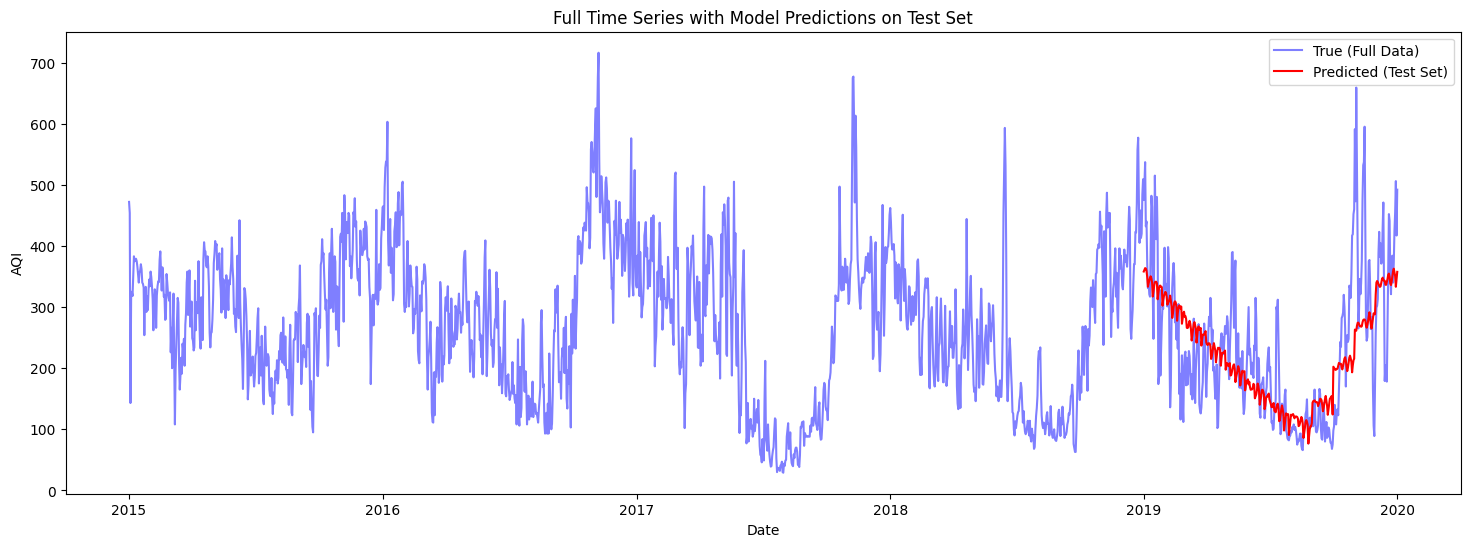

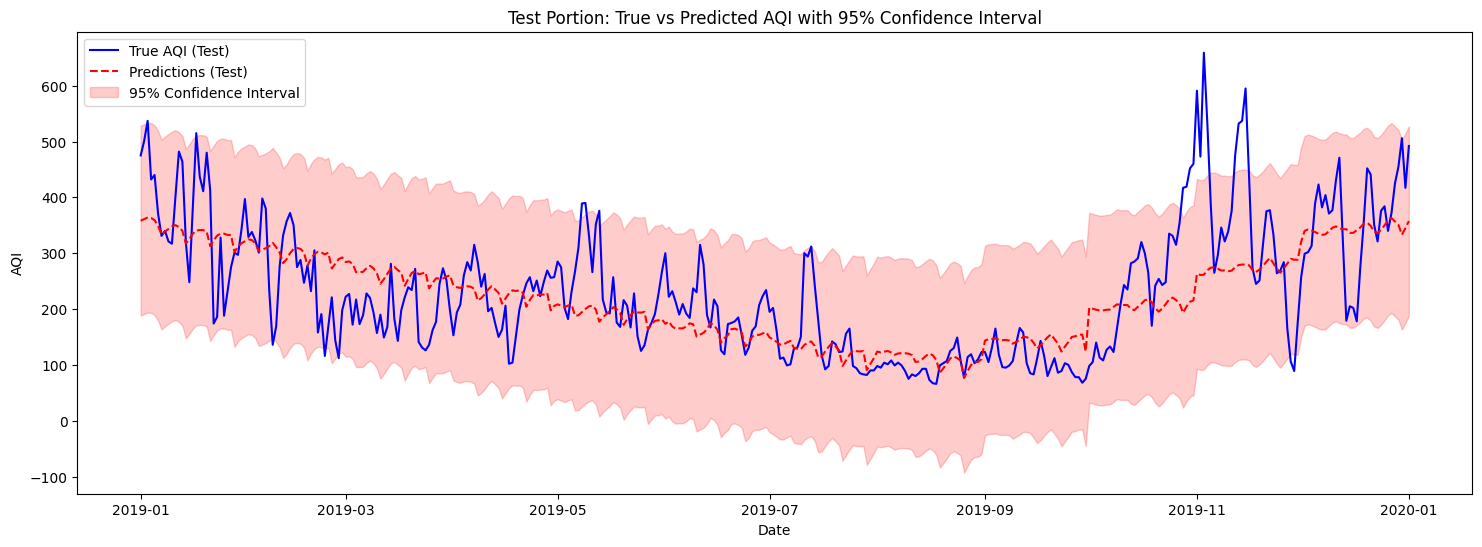

MSE: 7593.0716
RMSE: 87.1382
MAE: 63.5655
Overestimation Error: 55.7600
Underestimation Error: 71.0371


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import os

df = pd.read_csv('/content/air_quality_ts.csv')
df.rename(columns={'AQI': 'y'}, inplace=True)
df = df.sort_values('Date')
df.reset_index(inplace=True, drop=True)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df.head(5)

columns = ['y']
df=df[columns]

def add_features(df):
  df = df.copy()
  df['dayofweek'] = df.index.dayofweek
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofmonth'] = df.index.day

  return df

df = add_features(df)

df.loc[:, 'year'] = (df['year'] - 2000.0)/20
df.loc[:, 'y'] = df['y'] / 700
df.loc[:, 'dayofmonth'] = df['dayofmonth'] / 30.0
df.loc[:, 'dayofweek'] = df['dayofweek'] / 7.0
df.loc[:, 'month'] = df['month'] / 12

df_train = df.loc[df.index < '01-01-2019']
df_test = df.loc[df.index >= '01-01-2019']
X_train = df_train.drop('y', axis=1).values
y_train = df_train['y'].values
X_test = df_test.drop('y', axis=1).values
y_test = df_test['y'].values

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

class MSELoss(nn.Module):
    def __init__(self):
      super(MSELoss, self).__init__()
    def forward(self, y_pred, y_true):
      return torch.mean((y_pred - y_true)**2)

class myNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(myNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        # possibly add dropout or normalization, maybe more hidden layers

model = myNN(input_size=X_train.shape[1], hidden_size=100, output_size=1)
sum(p.numel() for p in model.parameters() if p.requires_grad)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
criterion = MSELoss()

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
model = model.to(device)
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

class my_dataset(Dataset):
    def __init__(self, X, y):
      self.X = X
      self.y = y
    def __len__(self):
      return len(self.X)
    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

train_set = my_dataset(X_train, y_train)
test_set = my_dataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

from tqdm import tqdm
# Training loop
for epoch in tqdm(range(num_epochs)):
    for (x,y) in train_loader:
      x,y = x.to(device), y.to(device)
      model.train()
      optimizer.zero_grad()
      outputs = model(x)
      loss = criterion(outputs.squeeze(), y)
      loss.backward()
      optimizer.step()
    if not (epoch+1)%10:
        print(f'\nEpoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

y_pred_nn = []
model.eval()

with torch.no_grad():
  for (x,y) in test_loader:
    x,y = x.to(device), y.to(device)
    y_pred_tensor = model(x)
    y_pred_nn.extend(y_pred_tensor.squeeze().detach().cpu().numpy().tolist())
    test_loss = criterion(y_pred_tensor.squeeze(), y)

print(f'Test Loss: {criterion(torch.tensor(y_pred_nn), y_test):.4f}')

plt.figure(figsize=(18,6))
plt.plot(df.index, df['y'] * 700, label='True (Full Data)', color='b', alpha=0.5)
plt.plot(df_test.index, np.array(y_pred_nn) * 700, label='Predicted (Test Set)', color='r')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Full Time Series with Model Predictions on Test Set')
plt.legend()
plt.show()

# Compute 95% confidence interval
y_pred_actual = np.array(y_pred_nn) * 700
y_test_actual = np.array(y_test) * 700

# Estimate standard deviation of residuals
residuals = y_test_actual - y_pred_actual
std_residuals = np.std(residuals)

# Compute confidence intervals
confidence_interval = 1.96 * std_residuals  # 1.96 for 95% confidence
upper_bound = y_pred_actual + confidence_interval
lower_bound = y_pred_actual - confidence_interval

# Plot focusing on the test portion only with confidence bounds
plt.figure(figsize=(18,6))
plt.plot(df_test.index, df_test['y'] * 700, label='True AQI (Test)', color='b')
plt.plot(df_test.index, y_pred_actual, label='Predictions (Test)', color='r', linestyle='--')
plt.fill_between(df_test.index, lower_bound, upper_bound, color='r', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Test Portion: True vs Predicted AQI with 95% Confidence Interval')
plt.legend()
plt.show()



from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert predictions and true values back to original scale
y_test_actual = np.array(y_test) * 700
y_pred_actual = np.array(y_pred_nn) * 700

# Compute metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

# Compute Overestimation and Underestimation Errors
overestimation_errors = np.where(y_pred_actual > y_test_actual, np.abs(y_pred_actual - y_test_actual), np.nan)
underestimation_errors = np.where(y_pred_actual < y_test_actual, np.abs(y_pred_actual - y_test_actual), np.nan)

# Mean Absolute Overestimation Error (only where y_pred > y_test)
overestimation_error = np.nanmean(overestimation_errors)  # Use nanmean to ignore NaNs

# Mean Absolute Underestimation Error (only where y_pred < y_test)
underestimation_error = np.nanmean(underestimation_errors)  # Use nanmean to ignore NaNs

print(f'Overestimation Error: {overestimation_error:.4f}')
print(f'Underestimation Error: {underestimation_error:.4f}')




Second Attempt

  6%|▌         | 12/200 [00:00<00:12, 15.20it/s]


Epoch [10/200], Loss: 0.0120


 12%|█▏        | 23/200 [00:01<00:08, 21.97it/s]


Epoch [20/200], Loss: 0.0152


 18%|█▊        | 35/200 [00:01<00:06, 26.45it/s]


Epoch [30/200], Loss: 0.0139


 22%|██▏       | 44/200 [00:02<00:05, 26.86it/s]


Epoch [40/200], Loss: 0.0128


 26%|██▋       | 53/200 [00:02<00:05, 26.72it/s]


Epoch [50/200], Loss: 0.0136


 32%|███▎      | 65/200 [00:02<00:04, 27.54it/s]


Epoch [60/200], Loss: 0.0144


 37%|███▋      | 74/200 [00:03<00:04, 26.09it/s]


Epoch [70/200], Loss: 0.0105


 42%|████▏     | 83/200 [00:03<00:04, 26.80it/s]


Epoch [80/200], Loss: 0.0086


 47%|████▋     | 94/200 [00:03<00:03, 29.37it/s]


Epoch [90/200], Loss: 0.0085


 52%|█████▏    | 104/200 [00:04<00:03, 27.57it/s]


Epoch [100/200], Loss: 0.0162


 56%|█████▋    | 113/200 [00:04<00:03, 26.98it/s]


Epoch [110/200], Loss: 0.0084


 62%|██████▏   | 123/200 [00:04<00:02, 28.89it/s]


Epoch [120/200], Loss: 0.0056


 68%|██████▊   | 136/200 [00:05<00:02, 28.39it/s]


Epoch [130/200], Loss: 0.0091


 72%|███████▎  | 145/200 [00:05<00:01, 28.34it/s]


Epoch [140/200], Loss: 0.0098


 78%|███████▊  | 155/200 [00:06<00:01, 27.95it/s]


Epoch [150/200], Loss: 0.0127


 82%|████████▎ | 165/200 [00:06<00:01, 28.89it/s]


Epoch [160/200], Loss: 0.0055


 88%|████████▊ | 175/200 [00:06<00:00, 29.66it/s]


Epoch [170/200], Loss: 0.0105


 92%|█████████▏| 184/200 [00:07<00:00, 28.77it/s]


Epoch [180/200], Loss: 0.0092


 97%|█████████▋| 194/200 [00:07<00:00, 27.72it/s]


Epoch [190/200], Loss: 0.0178


100%|██████████| 200/200 [00:07<00:00, 26.25it/s]



Epoch [200/200], Loss: 0.0078
Test Loss: 0.0130


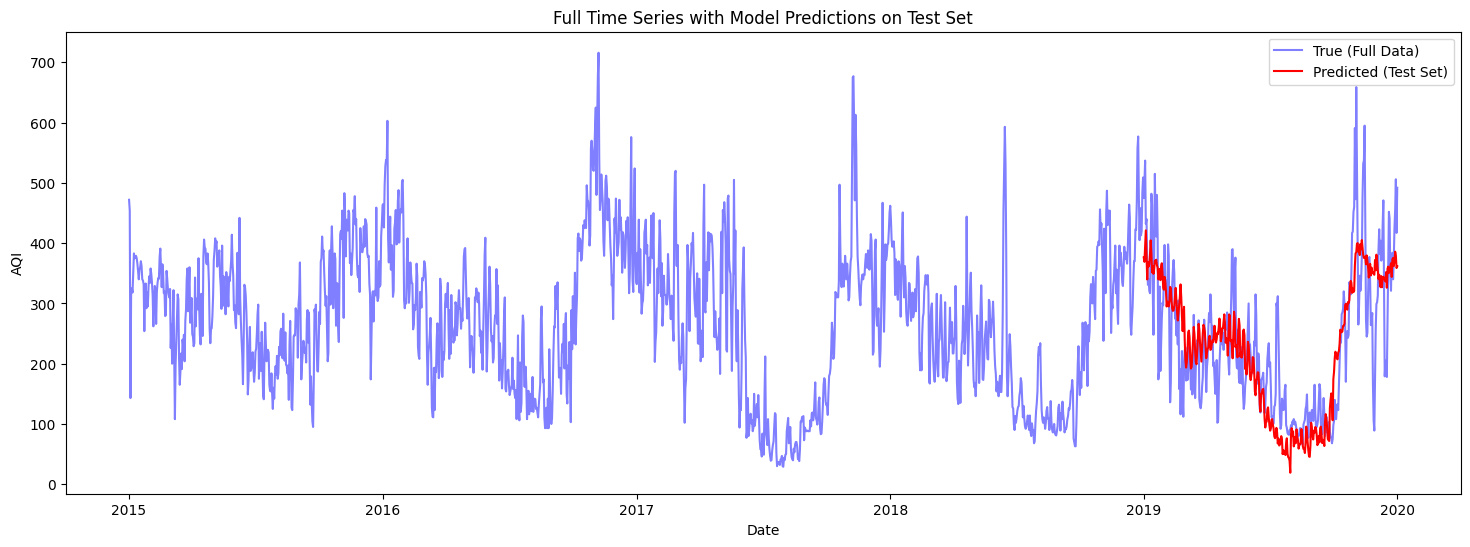

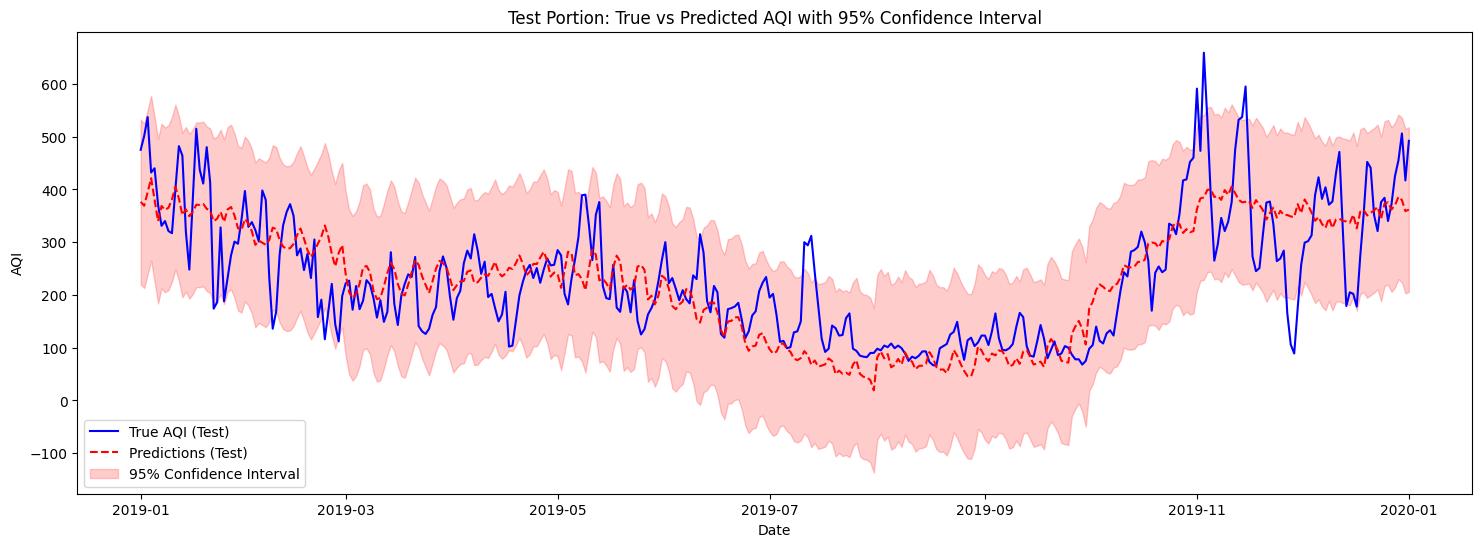

MSE: 6346.8145
RMSE: 79.6669
MAE: 60.9652
Overestimation Error: 65.9844
Underestimation Error: 57.0234


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pltwha
import statsmodels
import os

df = pd.read_csv('/content/air_quality_ts.csv')
df.rename(columns={'AQI': 'y'}, inplace=True)
df = df.sort_values('Date')
df.reset_index(inplace=True, drop=True)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df.head(5)

columns = ['y']
df=df[columns]

def add_features(df):
  df = df.copy()
  df['dayofweek'] = df.index.dayofweek
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofmonth'] = df.index.day

  # Day of year cyclic features (annual seasonality)
  df['dayofyear_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
  df['dayofyear_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365)

  # Month cyclic encoding
  df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
  df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

  # Day of week cyclic encoding
  df['dow_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
  df['dow_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

  return df

df = add_features(df)

df.loc[:, 'year'] = (df['year'] - 2000.0)/20
df.loc[:, 'y'] = df['y'] / 700
df.loc[:, 'dayofmonth'] = df['dayofmonth'] / 30.0
df.loc[:, 'dayofweek'] = df['dayofweek'] / 7.0
df.loc[:, 'month'] = df['month'] / 12

df_train = df.loc[df.index < '01-01-2019']
df_test = df.loc[df.index >= '01-01-2019']
X_train = df_train.drop('y', axis=1).values
y_train = df_train['y'].values
X_test = df_test.drop('y', axis=1).values
y_test = df_test['y'].values

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

class MSELoss(nn.Module):
    def __init__(self):
      super(MSELoss, self).__init__()
    def forward(self, y_pred, y_true):
      return torch.mean((y_pred - y_true)**2)

class myNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(myNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        # possibly add dropout or normalization, maybe more hidden layers

model = myNN(input_size=X_train.shape[1], hidden_size=100, output_size=1)
sum(p.numel() for p in model.parameters() if p.requires_grad)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 200
criterion = MSELoss()

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
model = model.to(device)
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

class my_dataset(Dataset):
    def __init__(self, X, y):
      self.X = X
      self.y = y
    def __len__(self):
      return len(self.X)
    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

train_set = my_dataset(X_train, y_train)
test_set = my_dataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

from tqdm import tqdm
# Training loop
for epoch in tqdm(range(num_epochs)):
    for (x,y) in train_loader:
      x,y = x.to(device), y.to(device)
      model.train()
      optimizer.zero_grad()
      outputs = model(x)
      loss = criterion(outputs.squeeze(), y)
      loss.backward()
      optimizer.step()
    if not (epoch+1)%10:
        print(f'\nEpoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

y_pred_nn = []
model.eval()

with torch.no_grad():
  for (x,y) in test_loader:
    x,y = x.to(device), y.to(device)
    y_pred_tensor = model(x)
    y_pred_nn.extend(y_pred_tensor.squeeze().detach().cpu().numpy().tolist())
    test_loss = criterion(y_pred_tensor.squeeze(), y)

print(f'Test Loss: {criterion(torch.tensor(y_pred_nn), y_test):.4f}')

plt.figure(figsize=(18,6))
plt.plot(df.index, df['y'] * 700, label='True (Full Data)', color='b', alpha=0.5)
plt.plot(df_test.index, np.array(y_pred_nn) * 700, label='Predicted (Test Set)', color='r')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Full Time Series with Model Predictions on Test Set')
plt.legend()
plt.show()

# Compute 95% confidence interval
y_pred_actual = np.array(y_pred_nn) * 700
y_test_actual = np.array(y_test) * 700

# Estimate standard deviation of residuals
residuals = y_test_actual - y_pred_actual
std_residuals = np.std(residuals)

# Compute confidence intervals
confidence_interval = 1.96 * std_residuals  # 1.96 for 95% confidence
upper_bound = y_pred_actual + confidence_interval
lower_bound = y_pred_actual - confidence_interval

# Plot focusing on the test portion only with confidence bounds
plt.figure(figsize=(18,6))
plt.plot(df_test.index, df_test['y'] * 700, label='True AQI (Test)', color='b')
plt.plot(df_test.index, y_pred_actual, label='Predictions (Test)', color='r', linestyle='--')
plt.fill_between(df_test.index, lower_bound, upper_bound, color='r', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Test Portion: True vs Predicted AQI with 95% Confidence Interval')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert predictions and true values back to original scale
y_test_actual = np.array(y_test) * 700
y_pred_actual = np.array(y_pred_nn) * 700

# Compute metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

# Compute Overestimation and Underestimation Errors
overestimation_errors = np.where(y_pred_actual > y_test_actual, np.abs(y_pred_actual - y_test_actual), np.nan)
underestimation_errors = np.where(y_pred_actual < y_test_actual, np.abs(y_pred_actual - y_test_actual), np.nan)

# Mean Absolute Overestimation Error (only where y_pred > y_test)
overestimation_error = np.nanmean(overestimation_errors)  # Use nanmean to ignore NaNs

# Mean Absolute Underestimation Error (only where y_pred < y_test)
underestimation_error = np.nanmean(underestimation_errors)  # Use nanmean to ignore NaNs

print(f'Overestimation Error: {overestimation_error:.4f}')
print(f'Underestimation Error: {underestimation_error:.4f}')




Third Attempt

<ipython-input-15-8cb2ade70b4b>:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.75 0.75 0.75 ... 0.95 0.95 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'year'] = (df['year'] - 2000.0) / 20
<ipython-input-15-8cb2ade70b4b>:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.03333333 0.06666667 0.1        ... 1.         1.03333333 0.03333333]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'dayofmonth'] = df['dayofmonth'] / 30.0
<ipython-input-15-8cb2ade70b4b>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.42857143 0.57142857 0.71428571 ... 0.         0.14285714 0.28571429]' has dtype incompatible with int32, please explicitly cast to a compatible dtype 

Epoch [10/500], Train Loss: 0.0550, Test Loss: 0.0194


  4%|▍         | 21/500 [00:02<01:06,  7.18it/s]

Epoch [20/500], Train Loss: 0.0285, Test Loss: 0.0189


  6%|▌         | 30/500 [00:04<01:35,  4.94it/s]

Epoch [30/500], Train Loss: 0.0224, Test Loss: 0.0163


  8%|▊         | 41/500 [00:06<01:12,  6.37it/s]

Epoch [40/500], Train Loss: 0.0184, Test Loss: 0.0154


 10%|█         | 51/500 [00:08<01:04,  7.00it/s]

Epoch [50/500], Train Loss: 0.0167, Test Loss: 0.0152


 12%|█▏        | 62/500 [00:09<00:41, 10.46it/s]

Epoch [60/500], Train Loss: 0.0149, Test Loss: 0.0143


 14%|█▍        | 72/500 [00:09<00:29, 14.43it/s]

Epoch [70/500], Train Loss: 0.0132, Test Loss: 0.0136


 16%|█▋        | 82/500 [00:10<00:27, 15.24it/s]

Epoch [80/500], Train Loss: 0.0130, Test Loss: 0.0136


 18%|█▊        | 92/500 [00:11<00:27, 15.02it/s]

Epoch [90/500], Train Loss: 0.0131, Test Loss: 0.0133


 20%|██        | 102/500 [00:11<00:25, 15.36it/s]

Epoch [100/500], Train Loss: 0.0131, Test Loss: 0.0131


 22%|██▏       | 112/500 [00:12<00:25, 15.27it/s]

Epoch [110/500], Train Loss: 0.0127, Test Loss: 0.0135


 24%|██▍       | 122/500 [00:13<00:25, 14.79it/s]

Epoch [120/500], Train Loss: 0.0124, Test Loss: 0.0133


 26%|██▋       | 132/500 [00:13<00:24, 15.21it/s]

Epoch [130/500], Train Loss: 0.0123, Test Loss: 0.0134


 28%|██▊       | 142/500 [00:14<00:23, 15.22it/s]

Epoch [140/500], Train Loss: 0.0118, Test Loss: 0.0132


 30%|███       | 152/500 [00:15<00:23, 14.68it/s]

Epoch [150/500], Train Loss: 0.0121, Test Loss: 0.0131


 32%|███▏      | 162/500 [00:15<00:23, 14.27it/s]

Epoch [160/500], Train Loss: 0.0120, Test Loss: 0.0132


 34%|███▍      | 172/500 [00:16<00:27, 12.05it/s]

Epoch [170/500], Train Loss: 0.0120, Test Loss: 0.0133


 36%|███▋      | 182/500 [00:17<00:29, 10.65it/s]

Epoch [180/500], Train Loss: 0.0113, Test Loss: 0.0131


 38%|███▊      | 192/500 [00:18<00:22, 13.90it/s]

Epoch [190/500], Train Loss: 0.0124, Test Loss: 0.0131


 40%|████      | 202/500 [00:19<00:19, 14.97it/s]

Epoch [200/500], Train Loss: 0.0113, Test Loss: 0.0129


 42%|████▏     | 212/500 [00:19<00:19, 14.68it/s]

Epoch [210/500], Train Loss: 0.0116, Test Loss: 0.0129


 44%|████▍     | 222/500 [00:20<00:18, 14.84it/s]

Epoch [220/500], Train Loss: 0.0114, Test Loss: 0.0128


 46%|████▋     | 232/500 [00:21<00:17, 15.34it/s]

Epoch [230/500], Train Loss: 0.0109, Test Loss: 0.0127


 48%|████▊     | 242/500 [00:21<00:17, 15.14it/s]

Epoch [240/500], Train Loss: 0.0111, Test Loss: 0.0123


 50%|█████     | 252/500 [00:22<00:16, 14.99it/s]

Epoch [250/500], Train Loss: 0.0116, Test Loss: 0.0123


 52%|█████▏    | 262/500 [00:23<00:15, 15.27it/s]

Epoch [260/500], Train Loss: 0.0104, Test Loss: 0.0122


 54%|█████▍    | 272/500 [00:23<00:15, 15.04it/s]

Epoch [270/500], Train Loss: 0.0114, Test Loss: 0.0121


 56%|█████▋    | 282/500 [00:24<00:14, 15.15it/s]

Epoch [280/500], Train Loss: 0.0109, Test Loss: 0.0121


 58%|█████▊    | 292/500 [00:25<00:13, 15.23it/s]

Epoch [290/500], Train Loss: 0.0106, Test Loss: 0.0121


 60%|██████    | 302/500 [00:25<00:13, 15.01it/s]

Epoch [300/500], Train Loss: 0.0107, Test Loss: 0.0121


 62%|██████▏   | 312/500 [00:26<00:12, 15.16it/s]

Epoch [310/500], Train Loss: 0.0101, Test Loss: 0.0127


 64%|██████▍   | 322/500 [00:27<00:11, 15.28it/s]

Epoch [320/500], Train Loss: 0.0109, Test Loss: 0.0128


 66%|██████▋   | 332/500 [00:27<00:11, 15.22it/s]

Epoch [330/500], Train Loss: 0.0103, Test Loss: 0.0124


 68%|██████▊   | 342/500 [00:28<00:13, 11.94it/s]

Epoch [340/500], Train Loss: 0.0101, Test Loss: 0.0132


 70%|███████   | 352/500 [00:29<00:13, 10.93it/s]

Epoch [350/500], Train Loss: 0.0096, Test Loss: 0.0130


 72%|███████▏  | 362/500 [00:30<00:10, 13.16it/s]

Epoch [360/500], Train Loss: 0.0101, Test Loss: 0.0125


 74%|███████▍  | 372/500 [00:30<00:08, 14.44it/s]

Epoch [370/500], Train Loss: 0.0099, Test Loss: 0.0130


 76%|███████▋  | 382/500 [00:31<00:07, 15.14it/s]

Epoch [380/500], Train Loss: 0.0100, Test Loss: 0.0132


 78%|███████▊  | 392/500 [00:32<00:07, 15.06it/s]

Epoch [390/500], Train Loss: 0.0096, Test Loss: 0.0137


 80%|████████  | 402/500 [00:32<00:06, 15.08it/s]

Epoch [400/500], Train Loss: 0.0097, Test Loss: 0.0132


 82%|████████▏ | 412/500 [00:33<00:05, 15.16it/s]

Epoch [410/500], Train Loss: 0.0097, Test Loss: 0.0130


 84%|████████▍ | 422/500 [00:34<00:05, 15.09it/s]

Epoch [420/500], Train Loss: 0.0089, Test Loss: 0.0134


 86%|████████▋ | 432/500 [00:34<00:04, 15.20it/s]

Epoch [430/500], Train Loss: 0.0088, Test Loss: 0.0138


 88%|████████▊ | 442/500 [00:35<00:03, 15.24it/s]

Epoch [440/500], Train Loss: 0.0093, Test Loss: 0.0133


 90%|█████████ | 452/500 [00:36<00:03, 14.82it/s]

Epoch [450/500], Train Loss: 0.0086, Test Loss: 0.0132


 92%|█████████▏| 462/500 [00:36<00:02, 14.81it/s]

Epoch [460/500], Train Loss: 0.0086, Test Loss: 0.0141


 94%|█████████▍| 472/500 [00:37<00:01, 15.29it/s]

Epoch [470/500], Train Loss: 0.0084, Test Loss: 0.0149


 96%|█████████▋| 482/500 [00:38<00:01, 14.74it/s]

Epoch [480/500], Train Loss: 0.0086, Test Loss: 0.0142


 98%|█████████▊| 492/500 [00:38<00:00, 14.51it/s]

Epoch [490/500], Train Loss: 0.0084, Test Loss: 0.0146


100%|██████████| 500/500 [00:39<00:00, 12.67it/s]


Epoch [500/500], Train Loss: 0.0083, Test Loss: 0.0137

Loaded best model state based on test loss for predictions.


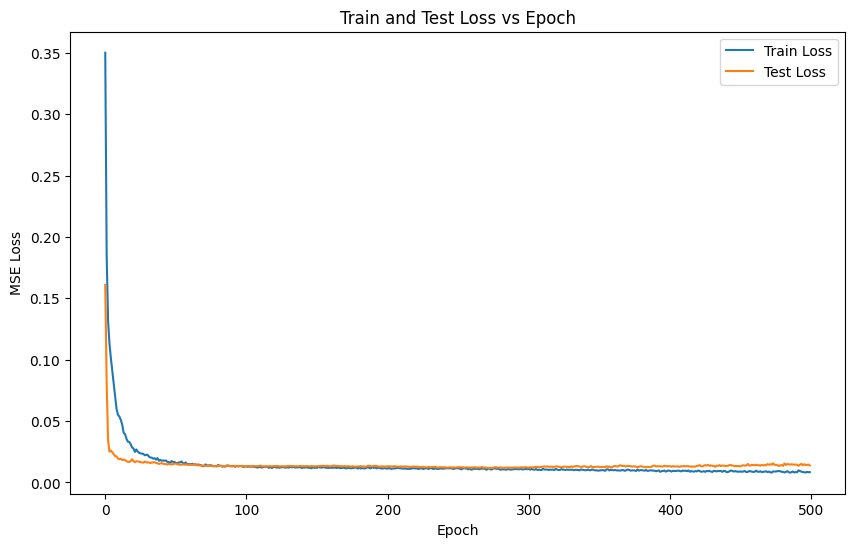

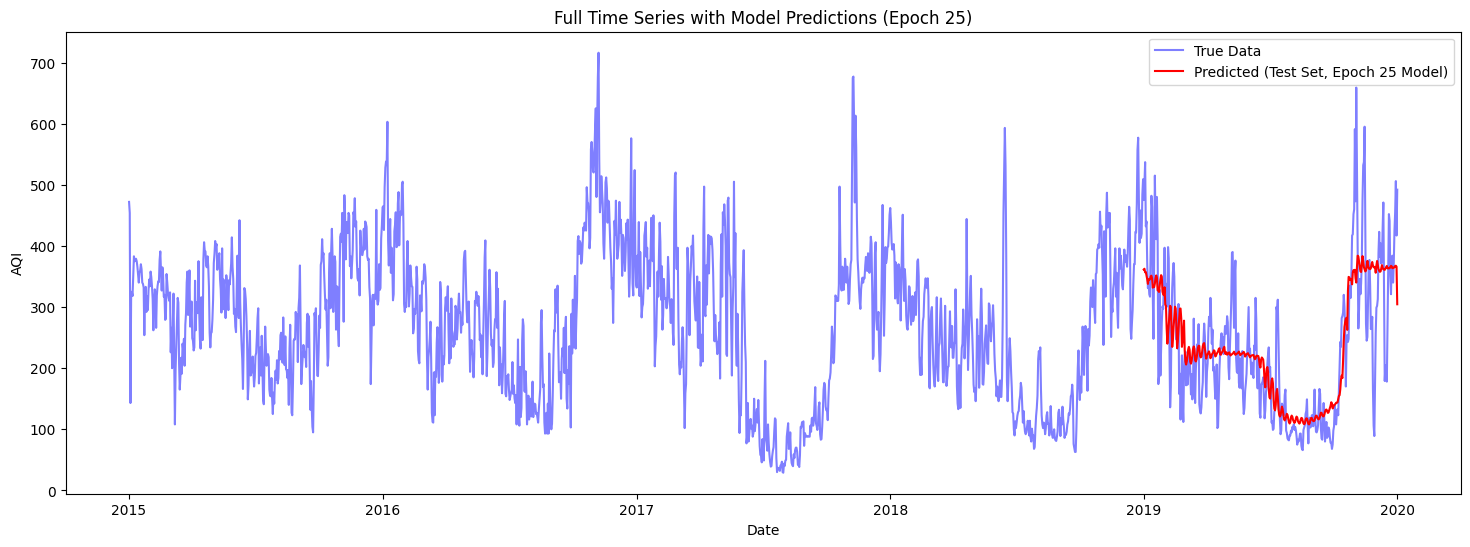

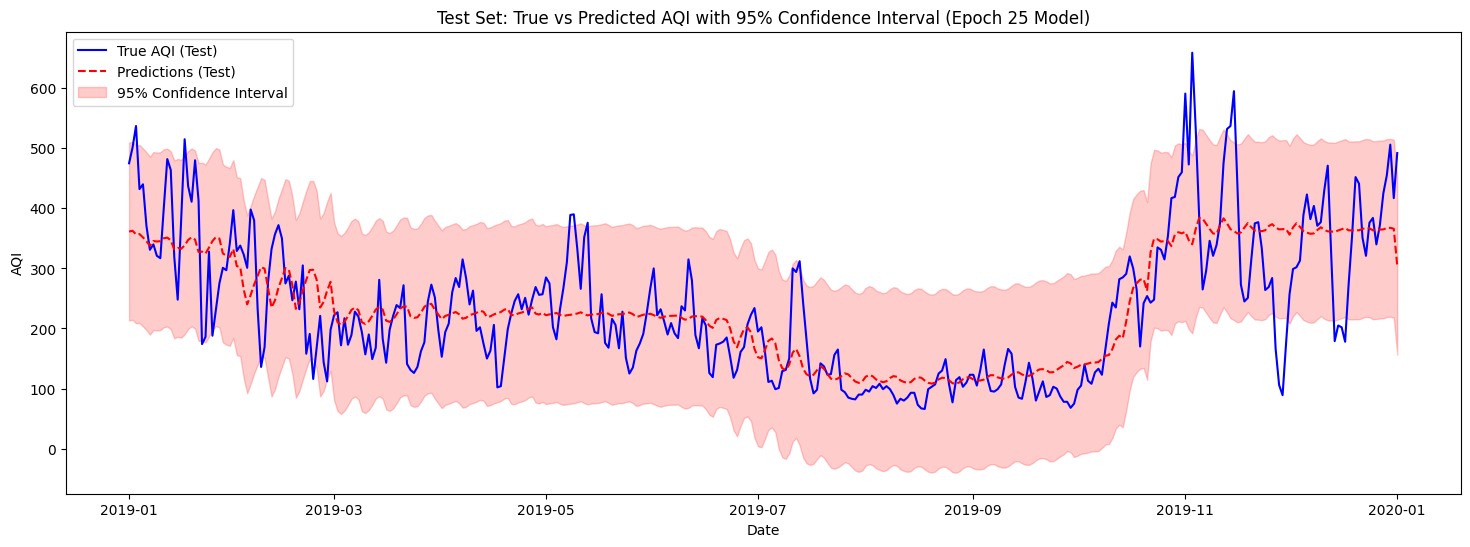

MSE: 5722.5998
RMSE: 75.6479
MAE: 55.5677
Overestimation Error: 50.9906
Underestimation Error: 62.0119


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ===========================
# Data Loading and Preprocessing
# ===========================

df = pd.read_csv('/content/air_quality_ts.csv')
df.rename(columns={'AQI': 'y'}, inplace=True)
df = df.sort_values('Date')
df.reset_index(inplace=True, drop=True)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
# We only keep the target column initially; features will be added next.
columns = ['y']
df = df[columns]

def add_features(df):
    df = df.copy()
    # Add basic date features
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day

    # Create cyclic features for seasonality
    df['dayofyear_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

    return df

# Add the cyclic and basic date features
df = add_features(df)

# Add an overall day index to capture the trend.
df['overall_day_index'] = (df.index - df.index.min()).days
df['overall_day_index'] = df['overall_day_index'] / df['overall_day_index'].max()

# Normalize/scale features
df.loc[:, 'year'] = (df['year'] - 2000.0) / 20
df.loc[:, 'y'] = df['y'] / 700
df.loc[:, 'dayofmonth'] = df['dayofmonth'] / 30.0
df.loc[:, 'dayofweek'] = df['dayofweek'] / 7.0
df.loc[:, 'month'] = df['month'] / 12

# ===========================
# Splitting Data
# ===========================

df_train = df.loc[df.index < '2019-01-01']
df_test = df.loc[df.index >= '2019-01-01']
X_train = df_train.drop('y', axis=1).values
y_train = df_train['y'].values
X_test = df_test.drop('y', axis=1).values
y_test = df_test['y'].values

# ===========================
# Dataset and DataLoader Setup
# ===========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ===========================
# Modified Neural Network for Highly Non-Linear Time Series
# ===========================
# This network uses:
# - SiLU activation (a smooth nonlinearity)
# - Batch Normalization for stable training
# - Dropout for regularization

class DeepNNNonLinearModified(nn.Module):
    def __init__(self, input_size, output_size):
        super(DeepNNNonLinearModified, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),  # Common nonlinear activation
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.layer5 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.output_layer = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.output_layer(x)
        return x

# Create an instance of the modified model and move it to the device.
model = DeepNNNonLinearModified(input_size=X_train.shape[1], output_size=1)
model = model.to(device)

# ===========================
# Prepare Data for Training
# ===========================

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# ===========================
# Training Setup
# ===========================

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
num_epochs = 500

train_losses = []
test_losses = []

# Variable to store the model state at epoch 25
epoch25_state = None

# ===========================
# Training Loop with Loss Tracking
# ===========================

best_test_loss = float('inf')
best_model_state = None

train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    epoch_train_loss = 0.0
    total_train = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs.squeeze(), y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * x.size(0)
        total_train += x.size(0)
    epoch_train_loss /= total_train
    train_losses.append(epoch_train_loss)

    # Evaluation on test data
    model.eval()
    epoch_test_loss = 0.0
    total_test = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs.squeeze(), y)
            epoch_test_loss += loss.item() * x.size(0)
            total_test += x.size(0)
    epoch_test_loss /= total_test
    test_losses.append(epoch_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

    # Save the best model state based on test loss
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        best_model_state = {k: v.clone() for k, v in model.state_dict().items()}

# After training, load the best model state for predictions.
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("\nLoaded best model state based on test loss for predictions.")


# ===========================
# Plotting Loss Curves
# ===========================

plt.figure(figsize=(10,6))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train and Test Loss vs Epoch')
plt.legend()
plt.show()

# ===========================
# Predictions and Evaluation using model from Epoch 25
# ===========================

model.eval()
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        y_pred.extend(outputs.squeeze().detach().cpu().numpy().tolist())

# Rescale predictions and true values to original scale
y_pred_actual = np.array(y_pred) * 700
y_test_actual = np.array(y_test) * 700

# Plot full time series with predictions on test set
plt.figure(figsize=(18,6))
plt.plot(df.index, df['y'] * 700, label='True Data', color='b', alpha=0.5)
plt.plot(df_test.index, y_pred_actual, label='Predicted (Test Set, Epoch 25 Model)', color='r')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Full Time Series with Model Predictions (Epoch 25)')
plt.legend()
plt.show()

# Compute 95% confidence intervals based on residuals
residuals = y_test_actual - y_pred_actual
std_residuals = np.std(residuals)
confidence_interval = 1.96 * std_residuals  # 95% confidence level
upper_bound = y_pred_actual + confidence_interval
lower_bound = y_pred_actual - confidence_interval

plt.figure(figsize=(18,6))
plt.plot(df_test.index, df_test['y'] * 700, label='True AQI (Test)', color='b')
plt.plot(df_test.index, y_pred_actual, label='Predictions (Test)', color='r', linestyle='--')
plt.fill_between(df_test.index, lower_bound, upper_bound, color='r', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Test Set: True vs Predicted AQI with 95% Confidence Interval (Epoch 25 Model)')
plt.legend()
plt.show()

# ===========================
# Evaluation Metrics
# ===========================

mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

overestimation_errors = np.where(y_pred_actual > y_test_actual, np.abs(y_pred_actual - y_test_actual), np.nan)
underestimation_errors = np.where(y_pred_actual < y_test_actual, np.abs(y_pred_actual - y_test_actual), np.nan)
overestimation_error = np.nanmean(overestimation_errors)
underestimation_error = np.nanmean(underestimation_errors)
print(f'Overestimation Error: {overestimation_error:.4f}')
print(f'Underestimation Error: {underestimation_error:.4f}')


# Part 3 - Incorporating an Exogenous Variable

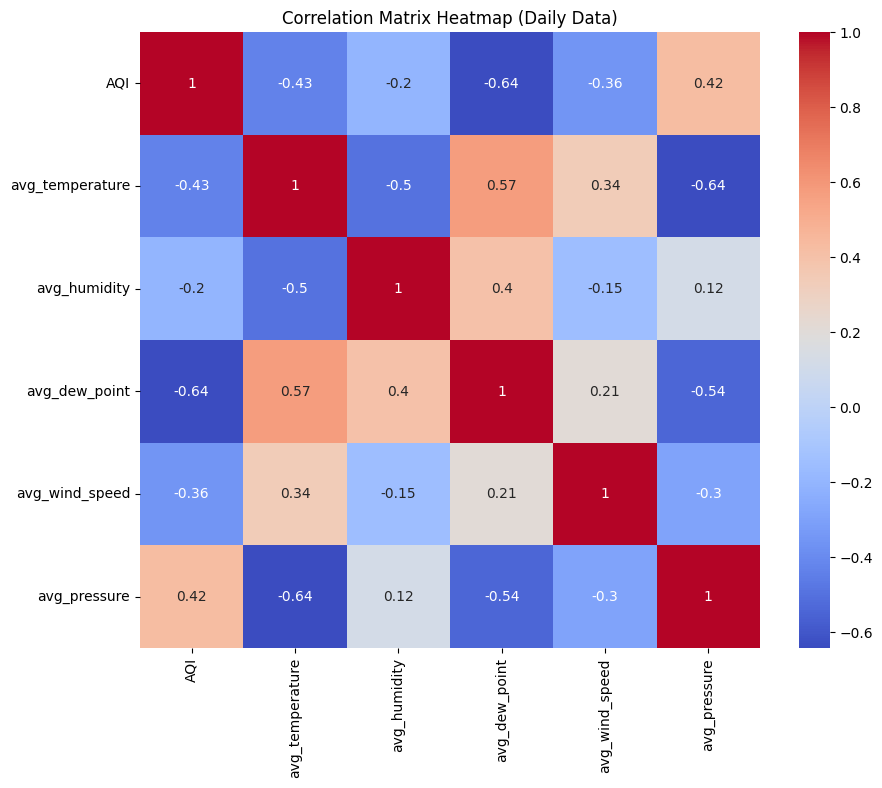

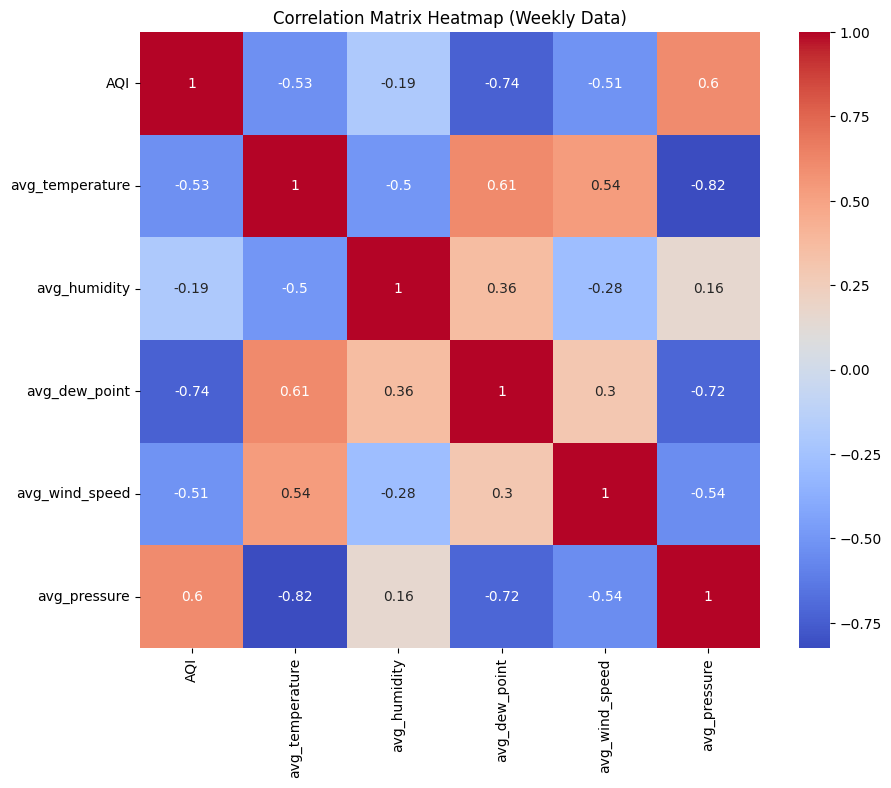

SARIMAX (Endogenous only) Summary:
                                        SARIMAX Results                                        
Dep. Variable:                                     AQI   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 52)   Log Likelihood                -273.100
Date:                                 Wed, 19 Mar 2025   AIC                            554.200
Time:                                         20:09:28   BIC                            561.848
Sample:                                     01-04-2015   HQIC                           557.113
                                          - 12-30-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6387      0.164     -3

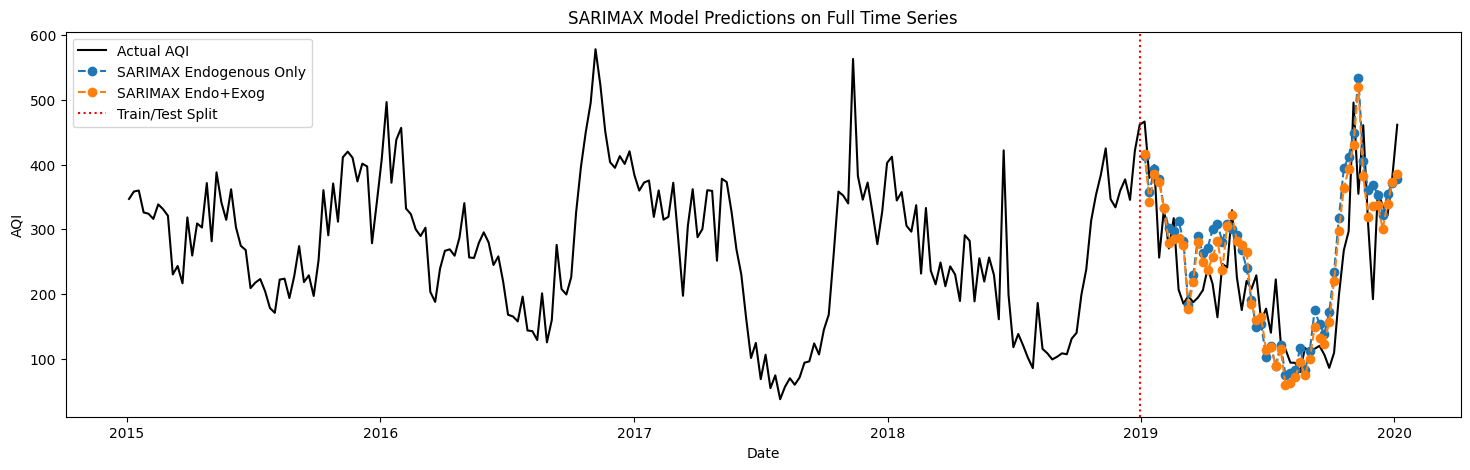

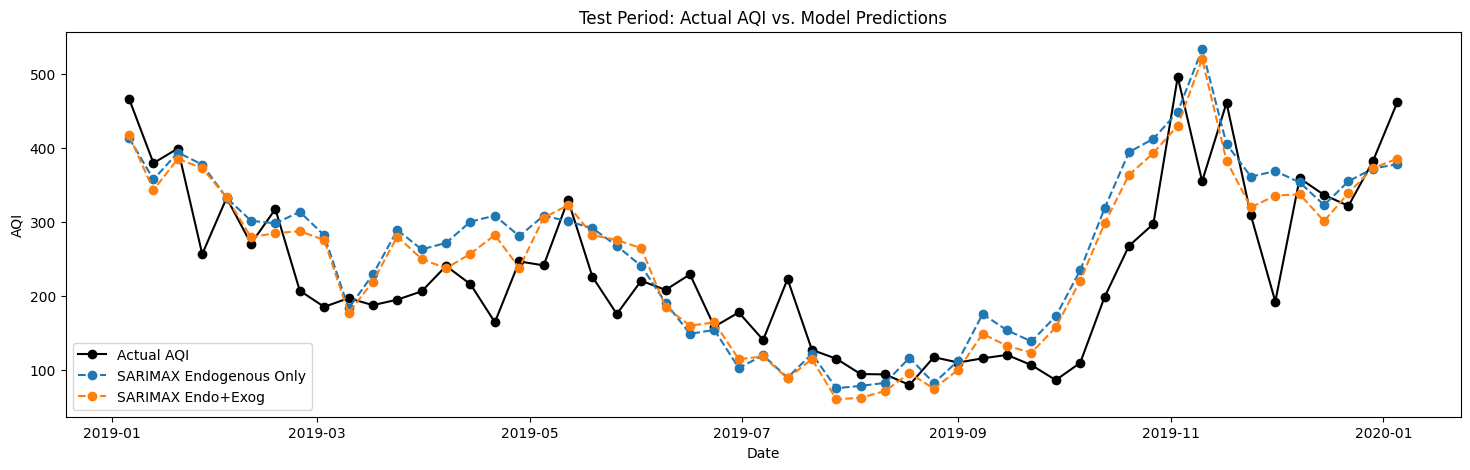

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

# --- Data Loading & Preprocessing ---
# Load air quality data
merged_df = pd.read_csv('/content/air_quality_ts.csv', parse_dates=['Date'])
merged_df.reset_index(inplace=True)

# Keep only the necessary variables: AQI and selected exogenous variables
exog_variables = ["avg_temperature", "avg_humidity", "avg_dew_point", "avg_wind_speed", "avg_pressure"]
merged_df = merged_df[["Date", "AQI"] + exog_variables]

# Set Date as index for time series analysis
merged_df.set_index('Date', inplace=True)

# --- Exploratory Analysis: Correlation Heatmaps ---
# Daily data correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap (Daily Data)")
plt.show()

# --- Transform Daily Data into Weekly Data ---
weekly_df = merged_df.resample('W').mean()

# Weekly data correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(weekly_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap (Weekly Data)")
plt.show()

# --- Train/Test Split (80/20) ---
n = len(weekly_df)
train_size = int(n * 0.8)
train_df = weekly_df.iloc[:train_size]
test_df = weekly_df.iloc[train_size:]

# --- SARIMAX Modeling ---

# Model 1: SARIMAX with endogenous variable only (AQI)
endog_train = train_df['AQI']
model_endog = SARIMAX(endog_train, order=(0, 1, 1), seasonal_order=(0, 1, 2, 52),
                      enforce_stationarity=False, enforce_invertibility=False)
results_endog = model_endog.fit(disp=False)
print("SARIMAX (Endogenous only) Summary:")
print(results_endog.summary())

# Model 2: SARIMAX with endogenous variable (AQI) and exogenous variable (avg_dew_point)
endog_train_exog = train_df['AQI']
exog_train = train_df[['avg_dew_point']]

model_exog = SARIMAX(endog_train_exog, exog=exog_train, order=(0, 1, 1), seasonal_order=(0, 1, 2, 52),
                     enforce_stationarity=False, enforce_invertibility=False)

results_exog = model_exog.fit(disp=False)
print("SARIMAX (Endogenous + Exogenous) Summary:")
print(results_exog.summary())

# --- Forecasting on Test Set ---
forecast_steps = len(test_df)

# Forecast for Model 1 (Endogenous only)
forecast_endog = results_endog.get_forecast(steps=forecast_steps)
pred_endog = forecast_endog.predicted_mean

# Forecast for Model 2 (Endogenous + Exogenous)
exog_test = test_df[['avg_dew_point']]
forecast_exog = results_exog.get_forecast(steps=forecast_steps, exog=exog_test)
pred_exog = forecast_exog.predicted_mean

# --- Calculate Error Metrics for Both Models ---
actual = test_df['AQI']

# Endogenous only model metrics
mse_endog = mean_squared_error(actual, pred_endog)
rmse_endog = np.sqrt(mse_endog)
mae_endog = mean_absolute_error(actual, pred_endog)

# Endogenous + Exogenous model metrics
mse_exog = mean_squared_error(actual, pred_exog)
rmse_exog = np.sqrt(mse_exog)
mae_exog = mean_absolute_error(actual, pred_exog)

print("\nPerformance on Test Set:")

print("\nSARIMAX (Endogenous + Exogenous):")
print(f"  MSE: {mse_exog:.3f}")
print(f"  RMSE: {rmse_exog:.3f}")
print(f"  MAE: {mae_exog:.3f}")

# --- Plotting the Full Time Series with Test Predictions ---
plt.figure(figsize=(18, 5))
plt.plot(weekly_df.index, weekly_df['AQI'], label='Actual AQI', color='black')
plt.plot(test_df.index, pred_endog, label='SARIMAX Endogenous Only', marker='o', linestyle='--')
plt.plot(test_df.index, pred_exog, label='SARIMAX Endo+Exog', marker='o', linestyle='--')
plt.axvline(train_df.index[-1], color='red', linestyle=':', label='Train/Test Split')
plt.xlabel("Date")
plt.ylabel("AQI")
plt.title("SARIMAX Model Predictions on Full Time Series")
plt.legend()
plt.show()

# --- Additional Plot: Only the Test Portion ---
plt.figure(figsize=(18, 5))
plt.plot(test_df.index, test_df['AQI'], label='Actual AQI', color='black', marker='o')
plt.plot(test_df.index, pred_endog, label='SARIMAX Endogenous Only', marker='o', linestyle='--')
plt.plot(test_df.index, pred_exog, label='SARIMAX Endo+Exog', marker='o', linestyle='--')
plt.xlabel("Date")
plt.ylabel("AQI")
plt.title("Test Period: Actual AQI vs. Model Predictions")
plt.legend()
plt.show()


# Part 4 - Change-Point Detection

In [ ]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00


## Shewhart Control Chart

First Attempt : Original Time Series, without Decomposition

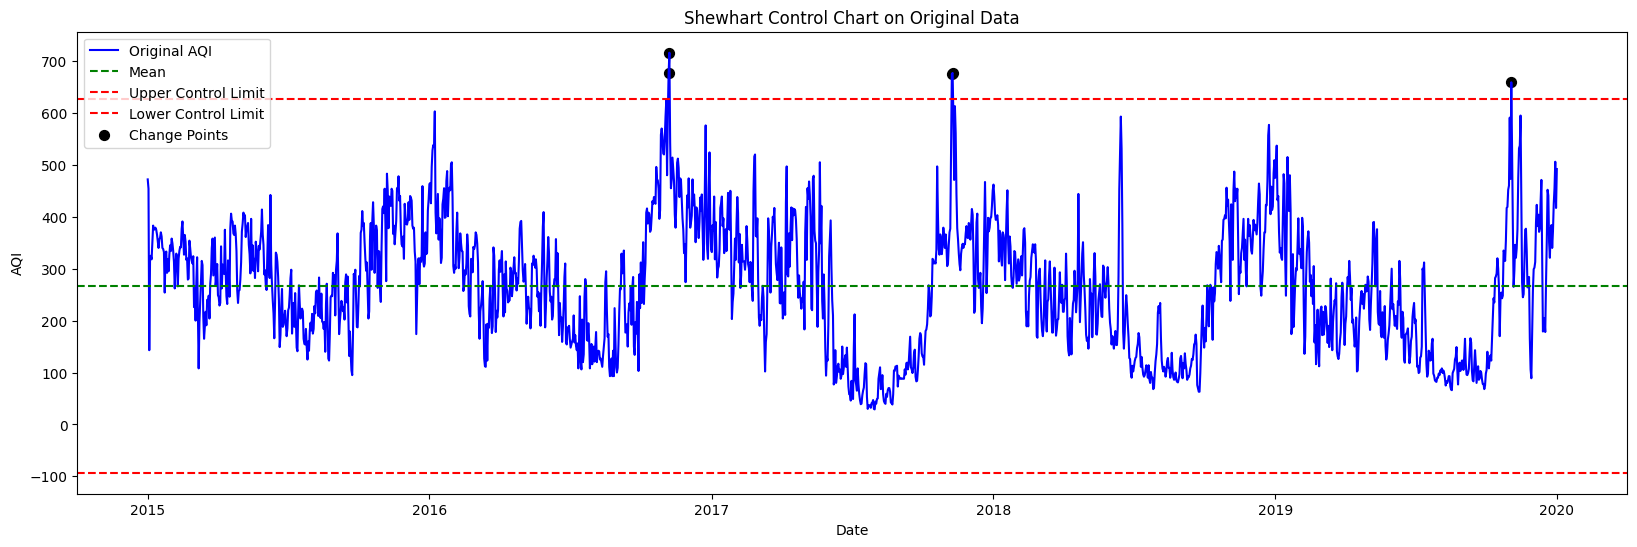

Shewhart Change Point Dates:
2016-11-06 00:00:00
2016-11-07 00:00:00
2017-11-08 00:00:00
2017-11-09 00:00:00
2019-11-03 00:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/content/air_quality_ts.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Use the original AQI time series
series = df['AQI']

# Calculate process mean and standard deviation on the original data
mean_series = series.mean()
std_series = series.std()

# Define control limits (using the 3-sigma rule)
ucl = mean_series + 3 * std_series
lcl = mean_series - 3 * std_series

# Identify change points where AQI exceeds the control limits
shewhart_points = series[(series > ucl) | (series < lcl)].index

# Plot the original time series along with control limits and change points
plt.figure(figsize=(20, 6))
plt.plot(series.index, series, label='Original AQI', color='blue')
plt.axhline(mean_series, color='green', linestyle='--', label='Mean')
plt.axhline(ucl, color='red', linestyle='--', label='Upper Control Limit')
plt.axhline(lcl, color='red', linestyle='--', label='Lower Control Limit')
plt.scatter(shewhart_points, series.loc[shewhart_points], color='black', marker='o', s=50, label='Change Points')
plt.title('Shewhart Control Chart on Original Data')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()

# Print the full dates of detected change points
print("Shewhart Change Point Dates:")
for dt in shewhart_points:
    print(dt.strftime("%Y-%m-%d %H:%M:%S"))


Second Attempt : Decomposed Time Series

1. Only Trend

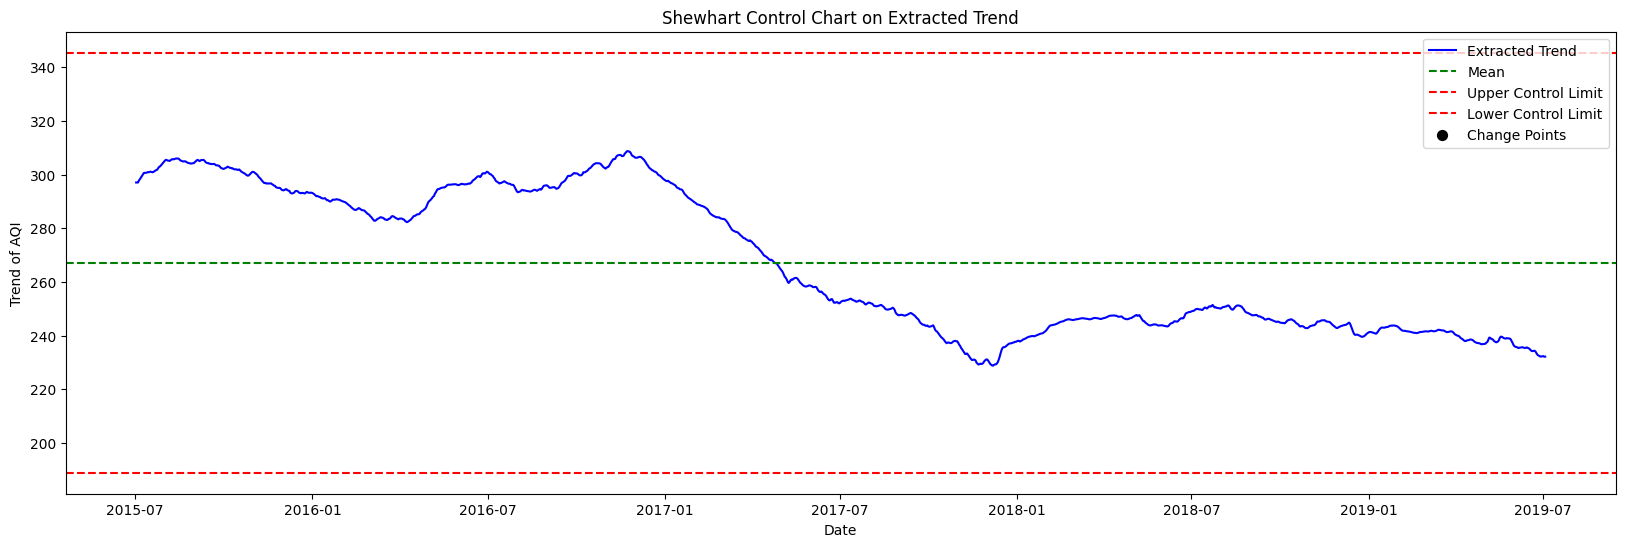

Shewhart Change Point Dates:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the data
df = pd.read_csv('/content/air_quality_ts.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Perform seasonal decomposition to extract the trend component
decomposition = seasonal_decompose(df['AQI'], model='additive', period=365)
trend = decomposition.trend

# Calculate process mean and standard deviation on the extracted trend (ignoring NaN values)
mean_trend = trend.mean()
std_trend = trend.std()

# Define control limits using the 3-sigma rule
ucl = mean_trend + 3 * std_trend
lcl = mean_trend - 3 * std_trend

# Identify change points where the trend exceeds the control limits
# Drop NaN values from trend to ensure proper indexing
trend_valid = trend.dropna()
shewhart_points = trend_valid[(trend_valid > ucl) | (trend_valid < lcl)].index

# Plot the extracted trend along with the control limits and detected change points
plt.figure(figsize=(20, 6))
plt.plot(trend.index, trend, label='Extracted Trend', color='blue')
plt.axhline(mean_trend, color='green', linestyle='--', label='Mean')
plt.axhline(ucl, color='red', linestyle='--', label='Upper Control Limit')
plt.axhline(lcl, color='red', linestyle='--', label='Lower Control Limit')
plt.scatter(shewhart_points, trend.loc[shewhart_points], color='black', marker='o', s=50, label='Change Points')
plt.title('Shewhart Control Chart on Extracted Trend')
plt.xlabel('Date')
plt.ylabel('Trend of AQI')
plt.legend()
plt.show()

# Print the full dates of detected change points
print("Shewhart Change Point Dates:")
for dt in shewhart_points:
    print(dt.strftime("%Y-%m-%d %H:%M:%S"))


2. Only Residuals

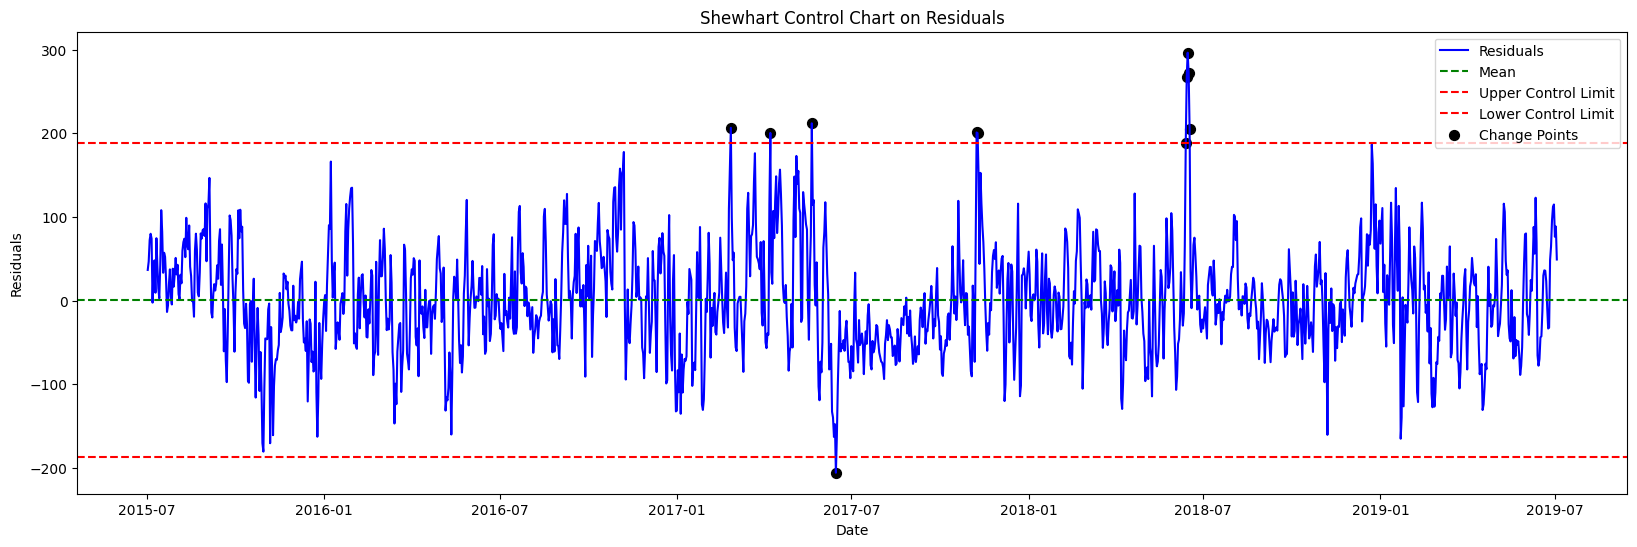

Shewhart Change Point Dates:
2017-02-26 00:00:00
2017-04-08 00:00:00
2017-05-21 00:00:00
2017-06-15 00:00:00
2017-11-08 00:00:00
2017-11-09 00:00:00
2018-06-13 00:00:00
2018-06-14 00:00:00
2018-06-15 00:00:00
2018-06-16 00:00:00
2018-06-17 00:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the data
df = pd.read_csv('/content/air_quality_ts.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Perform seasonal decomposition to extract the residuals
decomposition = seasonal_decompose(df['AQI'], model='additive', period=365)
residuals = decomposition.resid

# Calculate process mean and standard deviation on the residuals (ignoring NaN values)
residuals_valid = residuals.dropna()
mean_resid = residuals_valid.mean()
std_resid = residuals_valid.std()

# Define control limits using the 3-sigma rule
ucl = mean_resid + 3 * std_resid
lcl = mean_resid - 3 * std_resid

# Identify change points where residuals exceed the control limits
shewhart_points = residuals_valid[(residuals_valid > ucl) | (residuals_valid < lcl)].index

# Plot the residuals along with control limits and detected change points
plt.figure(figsize=(20, 6))
plt.plot(residuals.index, residuals, label='Residuals', color='blue')
plt.axhline(mean_resid, color='green', linestyle='--', label='Mean')
plt.axhline(ucl, color='red', linestyle='--', label='Upper Control Limit')
plt.axhline(lcl, color='red', linestyle='--', label='Lower Control Limit')
plt.scatter(shewhart_points, residuals.loc[shewhart_points], color='black', marker='o', s=50, label='Change Points')
plt.title('Shewhart Control Chart on Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Print the full dates of detected change points
print("Shewhart Change Point Dates:")
for dt in shewhart_points:
    print(dt.strftime("%Y-%m-%d %H:%M:%S"))


## Segmentation

### Trend Change Point Detection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from statsmodels.tsa.seasonal import seasonal_decompose
import ipywidgets as widgets
from ipywidgets import interact

# 1. Load your data
df = pd.read_csv('/content/air_quality_ts.csv')

# Update these column names to match your CSV
time_col = "Date"
value_col = "AQI"

# 2. Convert timestamp to datetime (if needed) and sort the dataframe
if time_col in df.columns:
    df[time_col] = pd.to_datetime(df[time_col])
    df.sort_values(by=time_col, inplace=True)

# 3. Extract the signal and create a time-indexed series
time_data = df[time_col] if time_col in df.columns else np.arange(len(df))
signal = df[value_col].values
signal_series = pd.Series(signal, index=time_data)

# 4. Extract the trend using seasonal decomposition
# Adjust seasonal_period based on your data frequency (e.g., 365 for daily data with yearly seasonality)
seasonal_period = 365
decomposition = seasonal_decompose(signal_series, model='additive', period=seasonal_period)
trend = decomposition.trend.dropna()  # Drop NaN boundaries

def run_segmentation(min_size=100, jump=5, n_breakpoints=2, model='l2'):
    """
    This function performs dynamic programming segmentation on the extracted trend using the
    given parameters and then plots the trend along with the detected change points, including
    segment means and ±1 standard deviation bands.
    """
    # Set up dynamic programming segmentation with user-specified parameters
    algo = rpt.Dynp(model=model, min_size=min_size, jump=jump)
    algo.fit(trend.values)
    bkps = algo.predict(n_bkps=n_breakpoints)

    plt.figure(figsize=(17, 4))
    plt.plot(trend.index, trend.values, label="Extracted Trend", color="blue")

    # Mark change points (except the final breakpoint, which is the end of the signal)
    for cp in bkps[:-1]:
        plt.axvline(trend.index[cp], color="red", linestyle="--", lw=1.5,
                    label="Change Point" if cp==bkps[0] else "")

    # Define segment boundaries: start at index 0 then each breakpoint
    segments = [0] + bkps
    cmap = plt.get_cmap("tab10")
    n_segments = len(segments) - 1

    for i in range(n_segments):
        seg_start = segments[i]
        seg_end = segments[i+1]
        segment_values = trend.values[seg_start:seg_end]
        segment_index = trend.index[seg_start:seg_end]

        # Compute segment statistics
        seg_mean = np.mean(segment_values)
        seg_std = np.std(segment_values)
        seg_var = seg_std**2

        # Plot segment mean and ±1 standard deviation band
        plt.hlines(seg_mean, xmin=segment_index[0], xmax=segment_index[-1],
                   colors=cmap(i), linestyles="--", lw=1.5,
                   label=f"Segment {i+1} Mean" if i==0 else "")
        plt.fill_between(segment_index, seg_mean - seg_std, seg_mean + seg_std,
                         color=cmap(i), alpha=0.2)

        # Annotate segment with mean and variance at its midpoint
        mid_x = segment_index[0] + (segment_index[-1] - segment_index[0]) / 2
        plt.text(mid_x, seg_mean, f"μ={seg_mean:.2f}\nσ²={seg_var:.2f}", fontsize=8,
                 color=cmap(i), verticalalignment="center", horizontalalignment="center",
                 bbox=dict(facecolor="white", alpha=0.6, edgecolor=cmap(i), boxstyle="round"))

    plt.title(f"Dynamic Programming Segmentation\n(min_size={min_size}, jump={jump}, n_breakpoints={n_breakpoints}, model={model})", fontsize=16)
    plt.xlabel("Time")
    plt.ylabel("AQI (Trend)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Create interactive widgets to tune the parameters
interact(run_segmentation,
         min_size=widgets.IntSlider(min=50, max=500, step=10, value=100, description='Min Size'),
         jump=widgets.IntSlider(min=1, max=20, step=1, value=5, description='Jump'),
         n_breakpoints=widgets.IntSlider(min=1, max=10, step=1, value=2, description='Breakpoints'),
         model=widgets.Dropdown(options=['l2', 'l1', 'rbf'], value='l2', description='Model'));


interactive(children=(IntSlider(value=100, description='Min Size', max=500, min=50, step=10), IntSlider(value=…

### Residuals Change Point Detection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from statsmodels.tsa.seasonal import seasonal_decompose
import ipywidgets as widgets
from ipywidgets import interact

# 1. Load your data
df = pd.read_csv('/content/air_quality_ts.csv')

# Update these column names to match your CSV
time_col = "Date"
value_col = "AQI"

# 2. Convert timestamp to datetime (if needed) and sort the dataframe
if time_col in df.columns:
    df[time_col] = pd.to_datetime(df[time_col])
    df.sort_values(by=time_col, inplace=True)

# 3. Extract the signal and create a time-indexed series
time_data = df[time_col] if time_col in df.columns else np.arange(len(df))
signal = df[value_col].values
signal_series = pd.Series(signal, index=time_data)

# 4. Extract the trend and residuals using seasonal decomposition.
# Adjust seasonal_period based on your data frequency (e.g., 365 for daily data with yearly seasonality)
seasonal_period = 365
decomposition = seasonal_decompose(signal_series, model='additive', period=seasonal_period)
# For this analysis we work with the residuals (dropping NaN boundaries)
residuals = decomposition.resid.dropna()

def plot_errors(min_size=100, jump=5, max_breakpoints=10, model='l2'):
    """
    For candidate numbers of breakpoints from 1 to max_breakpoints,
    this function computes the segmentation cost (error) on the extracted residuals.
    It then plots the segmentation cost as a function of the number of breakpoints.
    """
    errors = []
    candidate_bkps = range(1, max_breakpoints + 1)
    for n in candidate_bkps:
        # Instantiate and fit the segmentation algorithm on residuals
        algo = rpt.Dynp(model=model, min_size=min_size, jump=jump)
        algo.fit(residuals.values)
        bkps = algo.predict(n_bkps=n)
        # Compute the segmentation cost (error)
        cost = algo.cost.sum_of_costs(bkps)
        errors.append(cost)

    plt.figure(figsize=(10, 4))
    plt.plot(list(candidate_bkps), errors, marker='o', linestyle='--')
    plt.title("Segmentation Error vs Number of Breakpoints")
    plt.xlabel("Number of Breakpoints")
    plt.ylabel("Segmentation Cost")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

def run_segmentation(n_breakpoints=2, min_size=100, jump=5, model='l2'):
    """
    Performs dynamic programming segmentation on the extracted residuals using the specified parameters.
    Plots the residuals along with the detected change points, segment means, and ±1 standard deviation bands.
    """
    # Fit segmentation on residuals
    algo = rpt.Dynp(model=model, min_size=min_size, jump=jump)
    algo.fit(residuals.values)
    bkps = algo.predict(n_bkps=n_breakpoints)

    plt.figure(figsize=(17, 4))
    plt.plot(residuals.index, residuals.values, label="Extracted Residuals", color="blue")

    # Mark change points (except the final breakpoint, which is the end of the signal)
    for cp in bkps[:-1]:
        plt.axvline(residuals.index[cp], color="red", linestyle="--", lw=1.5,
                    label="Change Point" if cp == bkps[0] else "")

    # Define segment boundaries: start at index 0 then each breakpoint
    segments = [0] + bkps
    cmap = plt.get_cmap("tab10")
    n_segments = len(segments) - 1

    for i in range(n_segments):
        seg_start = segments[i]
        seg_end = segments[i+1]
        segment_values = residuals.values[seg_start:seg_end]
        segment_index = residuals.index[seg_start:seg_end]

        # Compute segment statistics
        seg_mean = np.mean(segment_values)
        seg_std = np.std(segment_values)
        seg_var = seg_std**2

        # Plot segment mean and ±1 standard deviation band
        plt.hlines(seg_mean, xmin=segment_index[0], xmax=segment_index[-1],
                   colors=cmap(i), linestyles="--", lw=1.5,
                   label=f"Segment {i+1} Mean" if i == 0 else "")
        plt.fill_between(segment_index, seg_mean - seg_std, seg_mean + seg_std,
                         color=cmap(i), alpha=0.2)

        # Annotate segment with mean and variance at its midpoint
        mid_x = segment_index[0] + (segment_index[-1] - segment_index[0]) / 2
        plt.text(mid_x, seg_mean, f"μ={seg_mean:.2f}\nσ²={seg_var:.2f}", fontsize=8,
                 color=cmap(i), verticalalignment="center", horizontalalignment="center",
                 bbox=dict(facecolor="white", alpha=0.6, edgecolor=cmap(i), boxstyle="round"))

    plt.title(f"Dynamic Programming Segmentation on Residuals\n(min_size={min_size}, jump={jump}, n_breakpoints={n_breakpoints}, model={model})", fontsize=16)
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Interactive widget to visualize segmentation error vs number of breakpoints
interact(plot_errors,
         min_size=widgets.IntSlider(min=20, max=500, step=10, value=100, description='Min Size'),
         jump=widgets.IntSlider(min=1, max=20, step=1, value=5, description='Jump'),
         max_breakpoints=widgets.IntSlider(min=1, max=20, step=1, value=10, description='Max Breakpoints'),
         model=widgets.Dropdown(options=['l2', 'l1', 'rbf'], value='l2', description='Model'));

# Interactive widget to run segmentation on the residuals with a chosen number of breakpoints
interact(run_segmentation,
         min_size=widgets.IntSlider(min=20, max=500, step=10, value=100, description='Min Size'),
         jump=widgets.IntSlider(min=1, max=20, step=1, value=5, description='Jump'),
         n_breakpoints=widgets.IntSlider(min=1, max=10, step=1, value=2, description='Breakpoints'),
         model=widgets.Dropdown(options=['l2', 'l1', 'rbf'], value='l2', description='Model'));


interactive(children=(IntSlider(value=100, description='Min Size', max=500, min=20, step=10), IntSlider(value=…

interactive(children=(IntSlider(value=2, description='Breakpoints', max=10, min=1), IntSlider(value=100, descr…